# 1. Introduction


The outcome of a young person’s education can shape the trajectory of their life, but not every pupil’s journey after secondary school is equal. Across England, some schools consistently send students into sustained education or employment after Key Stage 4, while others struggle to do so. What drives this disparity? Can we predict it?

This notebook explores a real-world education dataset containing school census data, performance tables, and pupil destination outcomes. By analysing and combining these sources, we aim to uncover what school-level features, such as SEN percentages, FSM eligibility, and cohort size may be linked to poor pupil outcomes.

The goal of this notebook is to show how a typical data science workflow unfolds in practice: from formulating a hypothesis, to exploring the data visually, engineering meaningful features, and finally building and interpreting predictive models. Along the way, you’ll see examples of plotting, cleaning, regression modelling, and SHAP-based explanation.

This project was developed with python 3.13.0

# 2. Import Modules <a id="import-modules"></a>

The following code block imports all necessary libraries required for data exploration, visualization, preprocessing, model building, evaluation, and interpretation. These imports include common Python libraries for data science such as `pandas`, `numpy`, `matplotlib`, `seaborn`, machine learning modules from `scikit-learn`, and SHAP for model interpretation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from scipy.stats import norm as normal_dist
from IPython.display import display_html
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Load Datasets <a id="load-datasets"></a>


In this section, the three core datasets used for analysis are loaded:

- `england_census.csv`: Contains school-level demographic and contextual data, such as pupil characteristics (e.g. SEN, FSM).
- `england_ks4-pupdest.csv`: Tracks pupil destinations after Key Stage 4 (e.g. education, employment, or not sustained).
- `england_ks4final.csv`: Includes academic performance metrics such as Progress 8 and Attainment 8 scores.

## 3.1 Import Files

In [129]:
census_df = pd.read_csv('Data/england_census.csv')
pupdest_df = pd.read_csv('Data/england_ks4-pupdest.csv')
results_df = pd.read_csv('Data/england_ks4final.csv')

## 3.2 Readability Modifications

To improve the readability of visualisations, I created a dictionary to map abbreviated `NFTYPE` school codes to their full school type descriptions. This mapping is applied directly in the analysis so that charts (like boxplots of Progress 8 scores) display clear and interpretable school type names instead of cryptic codes.

In [130]:
# Define NFTYPE abbreviation mapping
school_type_map = {
    'AC': 'Academy Sponsor Led',
    'CY': 'Community School',
    'VA': 'Voluntary Aided School',
    'VC': 'Voluntary Controlled School',
    'FD': 'Foundation School',
    'FA': 'Free School',
    'CTC': 'City Technology College',
    'AP': 'Alternative Provision',
    'SP': 'Special School',
    'IN': 'Independent School',
    'NM': 'Non-Maintained Special',
    'FS': 'Further Education',
    'TC': 'Technical College',
    'SU': 'Studio School',
    'UF': 'University Technical College'
}

## 3.3 Null Value Handling

### 3.3.1 Convert null Data

This code block converts all missing type of values to 1 common value of null / nan

In [131]:
null_placeholders = ['SUPP', 'NP', 'NA', 'RE']
for placeholder in null_placeholders:
    census_df.replace(placeholder, np.nan, inplace=True)
    pupdest_df.replace(placeholder, np.nan, inplace=True)
    results_df.replace(placeholder, np.nan, inplace=True)

### 3.3.2 Visualise null Data

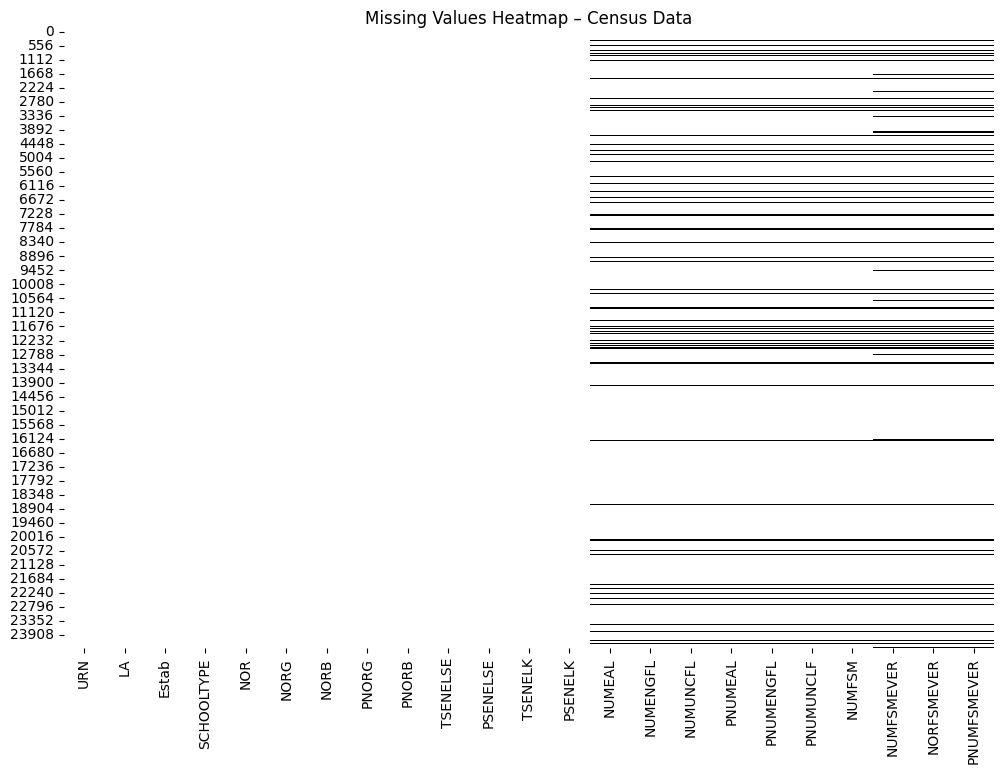

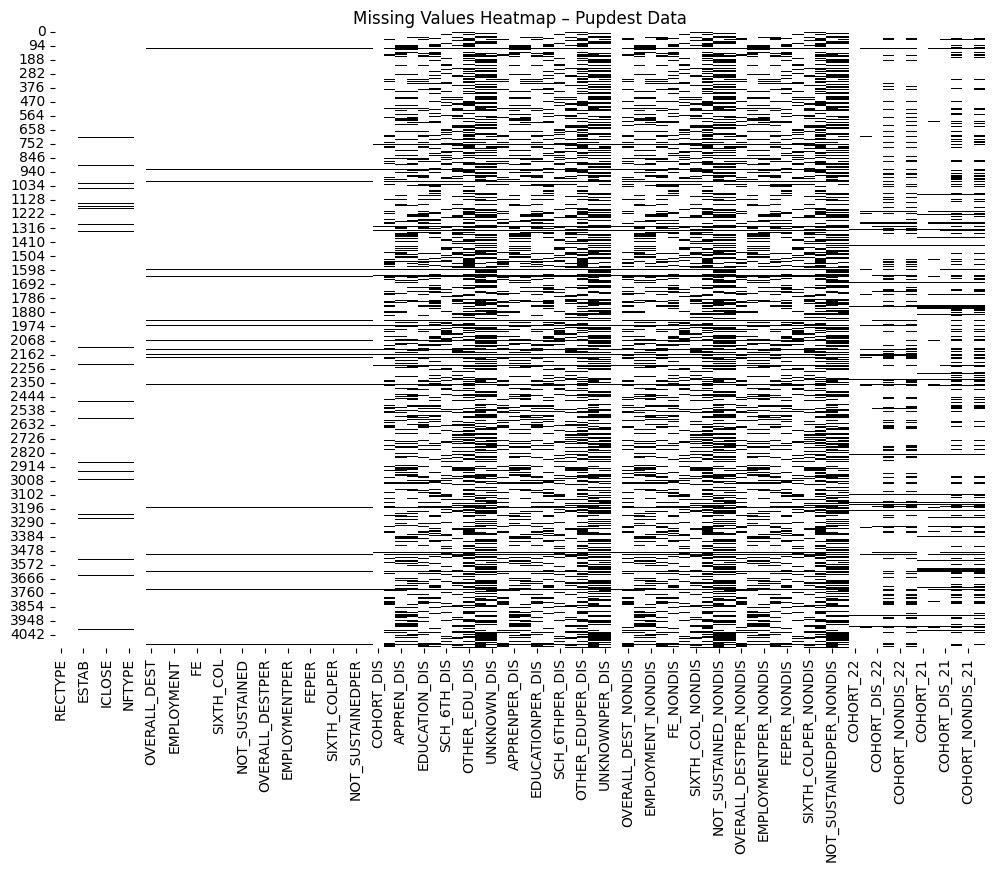

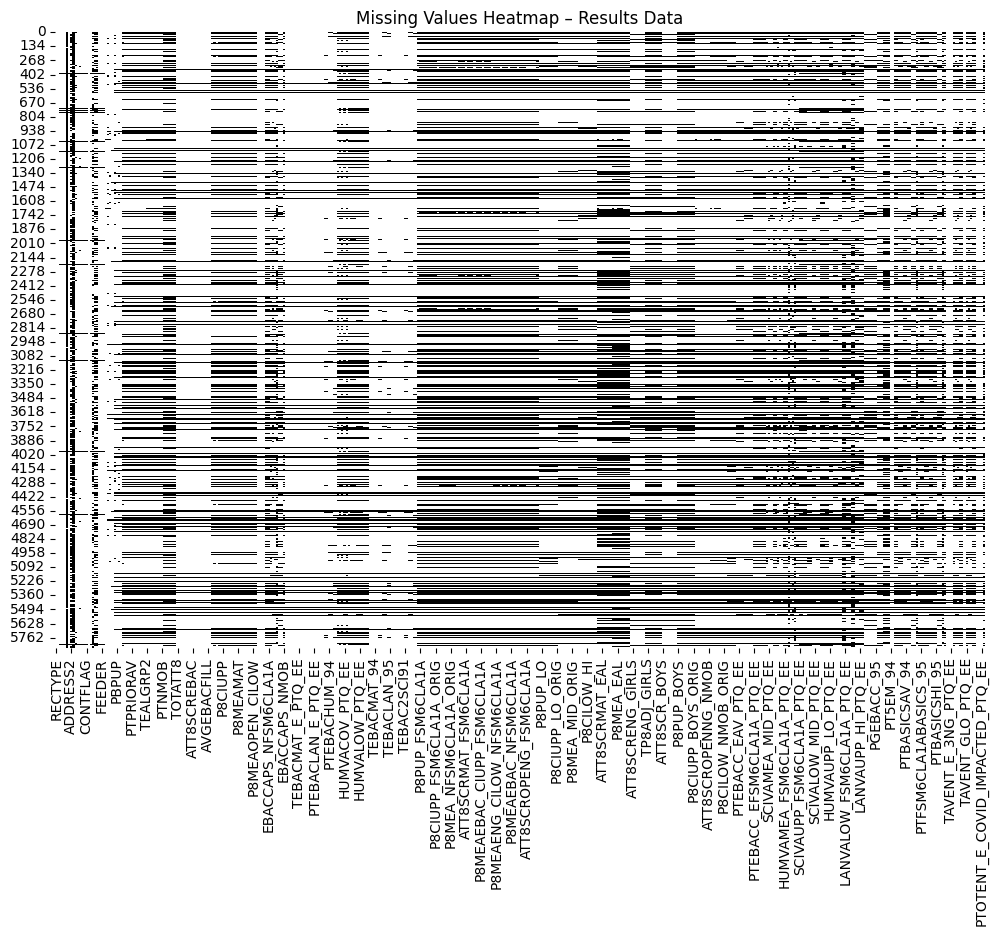

In [132]:
data_frames = {
    'Census Data': census_df,
    'Pupdest Data': pupdest_df,
    'Results Data': results_df
}

for name, df in data_frames.items():
    # Create a DataFrame where NaNs are 1 and everything else is 0
    data_for_heatmap = df.isnull().astype(int)

    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(data_for_heatmap, cbar=False, cmap='binary')
    plt.title(f'Missing Values Heatmap – {name}')
    plt.show()

# 4. Data Exploration

At the outset of this project, I hypothesised that certain school-level contextual features would be strongly associated with poorer pupil outcomes after Key Stage 4. In particular, I expected that:
- Schools with a higher proportion of pupils requiring SEN support would have lower Progress 8 scores and a higher percentage of pupils not sustaining education or employment destinations.
- Schools with higher deprivation indicators — such as free school meal (FSM) eligibility would similarly struggle to sustain positive destinations.
- Cohort size might play a role, with smaller schools potentially facing greater challenges in supporting vulnerable pupils.
- Gender imbalance within the school (very high proportions of either boys or girls) might also be linked to less favourable outcomes.

These hypotheses guided the structure of the subsequent exploration.
I first visualise sustained destination outcomes nationally, then move into exploring individual school-level characteristics — including SEN support levels, cohort size, and deprivation metrics — to understand their distributions and relationships.
Finally, I combine these insights by merging datasets and constructing models to formally test whether these contextual features are predictive of Progress 8 and pupil destination outcomes.

## 4.1 Initial Data Exploration

Before diving into models, it was essential to gain an intuitive understanding of the data. I began by exploring patterns in pupil destinations, in particular which schools had high rates of ‘sustained’ education or employment, and which did not. This exploration helped refine the hypotheses and suggested new areas to investigate, such as the role of cohort size and SEN support.


### 4.1.1 Inspecting Dataset Structure

In [133]:
census_df.head()

URN     LA Estab            SCHOOLTYPE   NOR  NORG  NORB   PNORG  \
0  100000  201.0  3614  State-funded primary   244   112   132   45.9%   
1  100001  201.0  6005    Independent school   764   764     0  100.0%   
2  100002  201.0  6006    Independent school   267   103   164   38.6%   
3  100003  201.0  6007    Independent school  1084     0  1084    0.0%   
4  100005  202.0  1048  State-funded nursery   123    60    63   48.8%   

    PNORB  TSENELSE  ... NUMEAL  NUMENGFL NUMUNCFL  PNUMEAL  PNUMENGFL  \
0   54.1%        11  ...  128.0     116.0      0.0    52.5%      47.5%   
1    0.0%         0  ...    NaN       NaN      NaN      NaN        NaN   
2   61.4%         0  ...    NaN       NaN      NaN      NaN        NaN   
3  100.0%         0  ...    NaN       NaN      NaN      NaN        NaN   
4   51.2%         1  ...   29.0      94.0      0.0    23.6%      76.4%   

   PNUMUNCLF NUMFSM NUMFSMEVER NORFSMEVER  PNUMFSMEVER  
0       0.0%   53.0       50.0      205.0        24.4%  
1        NaN    NaN        NaN        NaN          NaN  
2        NaN    NaN        NaN        NaN          NaN  
3        NaN    NaN        NaN        NaN          NaN  
4       0.0%   43.0        NaN        NaN          NaN  

[5 rows x 23 columns]

In [134]:
pupdest_df.head()

RECTYPE    LEA   ESTAB       URN  ICLOSE                        SCHNAME  \
0       2  371.0  7002.0  106818.0     0.0  Doncaster School for the Deaf   
1       1  371.0  4036.0  138116.0     0.0             Campsmount Academy   
2       2  371.0  7016.0  147829.0     0.0   North Ridge Community School   
3       1  371.0  4040.0  137899.0     0.0              Hungerhill School   
4       1  371.0  4012.0  146639.0     0.0             The Laurel Academy   

  NFTYPE  COHORT OVERALL_DEST APPREN  ... COHORT_DIS_22  \
0   NMSS       2          NaN    NaN  ...           NaN   
1    ACC     143          120      7  ...            42   
2   ACCS       7            7      0  ...             2   
3    ACC     249          237     12  ...            35   
4     AC     121          115      6  ...            59   

  OVERALL_DESTPER_DIS_22 COHORT_NONDIS_22 OVERALL_DESTPER_NONDIS_22 COHORT_21  \
0                    NaN              NaN                       NaN       5.0   
1                    86%              100                       93%     123.0   
2                    NaN                5                       NaN       4.0   
3                    94%              193                       98%     230.0   
4                    90%               58                       93%     118.0   

  OVERALL_DESTPER_21 COHORT_DIS_21 OVERALL_DESTPER_DIS_21 COHORT_NONDIS_21  \
0                NaN           NaN                    NaN              NaN   
1                94%            33                    91%               90   
2                NaN           NaN                    NaN              NaN   
3                98%            42                    93%              188   
4                88%            59                    83%               59   

  OVERALL_DESTPER_NONDIS_21  
0                       NaN  
1                       96%  
2                       NaN  
3                       99%  
4                       93%  

[5 rows x 82 columns]

In [135]:
results_df.head()

RECTYPE    LEA   ESTAB       URN                          SCHNAME  \
0        1  201.0  6007.0  100003.0            City of London School   
1        1  201.0  6005.0  100001.0  City of London School for Girls   
2        1  201.0  6000.0  100544.0               David Game College   
3        4  201.0     NaN       NaN                              NaN   
4        1  202.0  4285.0  100053.0           Acland Burghley School   

  SCHNAME_AC                   ADDRESS1  ADDRESS2 ADDRESS3    TOWN  ...  \
0        NaN  107 Queen Victoria Street       NaN      NaN  London  ...   
1        NaN          St Giles' Terrace  Barbican      NaN  London  ...   
2        NaN            31 Jewry Street    London      NaN     NaN  ...   
3        NaN                        NaN       NaN      NaN     NaN  ...   
4        NaN              Burghley Road       NaN      NaN  London  ...   

  TAVENT_G_PTQ_EE  TAVENT_GLO_PTQ_EE TAVENT_GAV_PTQ_EE TAVENT_GHI_PTQ_EE  \
0             3.1                NaN               NaN               NaN   
1             6.3                NaN               NaN               NaN   
2               1                NaN               NaN               NaN   
3             NaN                NaN               NaN               NaN   
4             7.5                5.8               7.3               8.2   

   TAVENT_GFSM6CLA1A_PTQ_EE  TAVENT_GNFSM6CLA1A_PTQ_EE TTOTENT_E_TOTAL_PTQ_EE  \
0                       NaN                        NaN                    560   
1                       NaN                        NaN                    626   
2                       NaN                        NaN                     50   
3                       NaN                        NaN                    NaN   
4                       6.6                          8                   1378   

  TTOTENT_E_COVID_IMPACTED_PTQ_EE PTOTENT_E_COVID_IMPACTED_PTQ_EE  \
0                               0                              0%   
1                               0                              0%   
2                               0                              0%   
3                             NaN                             NaN   
4                               0                              0%   

      P8_BANDING  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4  Below average  

[5 rows x 429 columns]

In [136]:
# Check number of rows and columns in each dataset
print("Census:", census_df.shape)
print("PupDest:", pupdest_df.shape)
print("Results:", results_df.shape)

Census: (24447, 23)
PupDest: (4134, 82)
Results: (5864, 429)


In [137]:
# Display column names
print("Census Columns:", census_df.columns.tolist())
print("PupDest Columns:", pupdest_df.columns.tolist())
print("Results Columns:", results_df.columns.tolist())

Census Columns: ['URN', 'LA', 'Estab', 'SCHOOLTYPE', 'NOR', 'NORG', 'NORB', 'PNORG', 'PNORB', 'TSENELSE', 'PSENELSE', 'TSENELK', 'PSENELK', 'NUMEAL', 'NUMENGFL', 'NUMUNCFL', 'PNUMEAL', 'PNUMENGFL', 'PNUMUNCLF', 'NUMFSM', 'NUMFSMEVER', 'NORFSMEVER', 'PNUMFSMEVER']
PupDest Columns: ['RECTYPE', 'LEA', 'ESTAB', 'URN', 'ICLOSE', 'SCHNAME', 'NFTYPE', 'COHORT', 'OVERALL_DEST', 'APPREN', 'EMPLOYMENT', 'EDUCATION', 'FE', 'SCH_6TH', 'SIXTH_COL', 'OTHER_EDU', 'NOT_SUSTAINED', 'UNKNOWN', 'OVERALL_DESTPER', 'APPRENPER', 'EMPLOYMENTPER', 'EDUCATIONPER', 'FEPER', 'SCH_6THPER', 'SIXTH_COLPER', 'OTHER_EDUPER', 'NOT_SUSTAINEDPER', 'UNKNOWNPER', 'COHORT_DIS', 'OVERALL_DEST_DIS', 'APPREN_DIS', 'EMPLOYMENT_DIS', 'EDUCATION_DIS', 'FE_DIS', 'SCH_6TH_DIS', 'SIXTH_COL_DIS', 'OTHER_EDU_DIS', 'NOT_SUSTAINED_DIS', 'UNKNOWN_DIS', 'OVERALL_DESTPER_DIS', 'APPRENPER_DIS', 'EMPLOYMENTPER_DIS', 'EDUCATIONPER_DIS', 'FEPER_DIS', 'SCH_6THPER_DIS', 'SIXTH_COLPER_DIS', 'OTHER_EDUPER_DIS', 'NOT_SUSTAINEDPER_DIS', 'UNKNOWNPER

In [138]:
# Quick glance at datatypes and nulls
census_df.info()
pupdest_df.info()
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24447 entries, 0 to 24446
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   URN          24447 non-null  object 
 1   LA           24444 non-null  float64
 2   Estab        24447 non-null  object 
 3   SCHOOLTYPE   24447 non-null  object 
 4   NOR          24447 non-null  int64  
 5   NORG         24447 non-null  int64  
 6   NORB         24447 non-null  int64  
 7   PNORG        24447 non-null  object 
 8   PNORB        24447 non-null  object 
 9   TSENELSE     24447 non-null  int64  
 10  PSENELSE     24447 non-null  object 
 11  TSENELK      24447 non-null  int64  
 12  PSENELK      24447 non-null  object 
 13  NUMEAL       22026 non-null  float64
 14  NUMENGFL     22026 non-null  float64
 15  NUMUNCFL     22026 non-null  float64
 16  PNUMEAL      22026 non-null  object 
 17  PNUMENGFL    22026 non-null  object 
 18  PNUMUNCLF    22026 non-null  object 
 19  NUMF

In [139]:
# Separate columns by data type
num_cols = results_df.select_dtypes(include='number').columns.tolist()
cat_cols = results_df.select_dtypes(include='object').columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['RECTYPE', 'LEA', 'ESTAB', 'URN', 'TELNUM', 'CONTFLAG', 'ICLOSE', 'FEEDER', 'TPUP', 'SENE4', 'SEN_ALL4', 'SENK4']
Categorical columns: ['SCHNAME', 'SCHNAME_AC', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'TOWN', 'PCODE', 'PCON_CODE', 'PCON_NAME', 'NFTYPE', 'RELDENOM', 'ADMPOL', 'ADMPOL_PT', 'EGENDER', 'AGERANGE', 'TOTPUPS', 'NUMBOYS', 'NUMGIRLS', 'BPUP', 'PBPUP', 'GPUP', 'PGPUP', 'KS2ASS', 'TPRIORLO', 'PTPRIORLO', 'TPRIORAV', 'PTPRIORAV', 'TPRIORHI', 'PTPRIORHI', 'TFSM6CLA1A', 'PTFSM6CLA1A', 'TNOTFSM6CLA1A', 'PTNOTFSM6CLA1A', 'TEALGRP2', 'PTEALGRP2', 'TEALGRP1', 'PTEALGRP1', 'TEALGRP3', 'PTEALGRP3', 'TNMOB', 'PTNMOB', 'PSENE4', 'PSEN_ALL4', 'PSENK4', 'TOTATT8', 'ATT8SCR', 'TOTATT8ENG', 'ATT8SCRENG', 'TOTATT8MAT', 'ATT8SCRMAT', 'TOTATT8EBAC', 'ATT8SCREBAC', 'TOTATT8OPEN', 'ATT8SCROPEN', 'TOTATT8OPENG', 'ATT8SCROPENG', 'TOTATT8OPENNG', 'ATT8SCROPENNG', 'AVGEBACFILL', 'AVGOPENFILL', 'P8PUP', 'TP8ADJ', 'P8MEACOV', 'P8MEA', 'P8CILOW', 'P8CIUPP', 'P8MEA_ORIG', 'P8CILOW_ORIG', 'P8C

### 4.1.2 Fixing of data

The dataset includes entries for Local Authorities (LAs), which are administrative bodies rather than individual schools. Since this analysis focuses specifically on **school-level performance and characteristics**, these rows are not relevant and should be removed to ensure accuracy and consistency in the results.

In [140]:
la_rows = pupdest_df[pupdest_df["RECTYPE"] == "LA"]
la_rows

RECTYPE    LEA  ESTAB  URN  ICLOSE SCHNAME NFTYPE  COHORT OVERALL_DEST  \
25        LA  371.0    NaN  NaN     NaN     NaN    NaN    3250         2956   
52        LA  344.0    NaN  NaN     NaN     NaN    NaN    3665         3395   
66        LA  802.0    NaN  NaN     NaN     NaN    NaN    2259         2167   
76        LA  340.0    NaN  NaN     NaN     NaN    NaN    1198         1015   
99        LA  887.0    NaN  NaN     NaN     NaN    NaN    3349         3125   
...      ...    ...    ...  ...     ...     ...    ...     ...          ...   
4085      LA  846.0    NaN  NaN     NaN     NaN    NaN    2294         2179   
4102      LA  894.0    NaN  NaN     NaN     NaN    NaN    2158         2017   
4117      LA  314.0    NaN  NaN     NaN     NaN    NaN    1782         1719   
4130      LA  868.0    NaN  NaN     NaN     NaN    NaN    1644         1568   
4132      LA  420.0    NaN  NaN     NaN     NaN    NaN      15           15   

     APPREN  ... COHORT_DIS_22 OVERALL_DESTPER_DIS_22 COHORT_NONDIS_22  \
25      139  ...           970                    84%             2185   
52      103  ...          1015                    89%             2585   
66      102  ...           425                    90%             1815   
76       48  ...           580                    79%              570   
99       96  ...           780                    88%             2390   
...     ...  ...           ...                    ...              ...   
4085     37  ...           520                    88%             1705   
4102     73  ...           580                    89%             1590   
4117     18  ...           275                    92%             1555   
4130     27  ...           235                    88%             1360   
4132      1  ...             5                    NaN               10   

     OVERALL_DESTPER_NONDIS_22 COHORT_21 OVERALL_DESTPER_21 COHORT_DIS_21  \
25                         95%    3060.0                92%           945   
52                         96%    3511.0                94%          1075   
66                         97%    2200.0                97%           405   
76                         94%    1051.0                86%           510   
99                         96%    3091.0                95%           725   
...                        ...       ...                ...           ...   
4085                       96%    2281.0                95%           575   
4102                       96%    2051.0                95%           535   
4117                       98%    1767.0                96%           310   
4130                       96%    1590.0                96%           230   
4132                       NaN      18.0                94%            SN   

     OVERALL_DESTPER_DIS_21 COHORT_NONDIS_21 OVERALL_DESTPER_NONDIS_21  
25                      85%             2115                       95%  
52                      88%             2435                       97%  
66                      94%             1795                       97%  
76                      78%              540                       94%  
99                      89%             2365                       97%  
...                     ...              ...                       ...  
4085                    89%             1705                       97%  
4102                    88%             1515                       97%  
4117                    94%             1455                       97%  
4130                    92%             1360                       96%  
4132                    NaN               15                       NaN  

[150 rows x 82 columns]

In [141]:
pupdest_df = pupdest_df[pupdest_df["RECTYPE"] != "LA"]

## 4.2 Pupdest Data Exploration

This section explores the `pupdest_df` dataset, which contains information about pupil destinations after completing Key Stage 4 (KS4).

The dataset includes variables indicating whether pupils moved on to education, employment, apprenticeships, or became classified as "not sustained" (i.e. without a confirmed destination). These outcomes are important indicators of long-term success and provide valuable context when evaluating school performance. 

Note: Destination outcomes are only tracked for the first two terms after KS4, providing a short-term snapshot that may not reflect longer-term pupil outcomes.

The goal of this exploration is to:
- Understand the distribution of post-16 destination outcomes
- Identify how many pupils are at risk of not sustaining a destination
- Detect potential patterns across schools, such as high rates of "not sustained" destinations

This analysis will later support the creation of risk indicators and inform predictive modelling of at-risk schools or student groups.

### 4.2.1 Distribution of Sustained Positive Destinations Across Schools

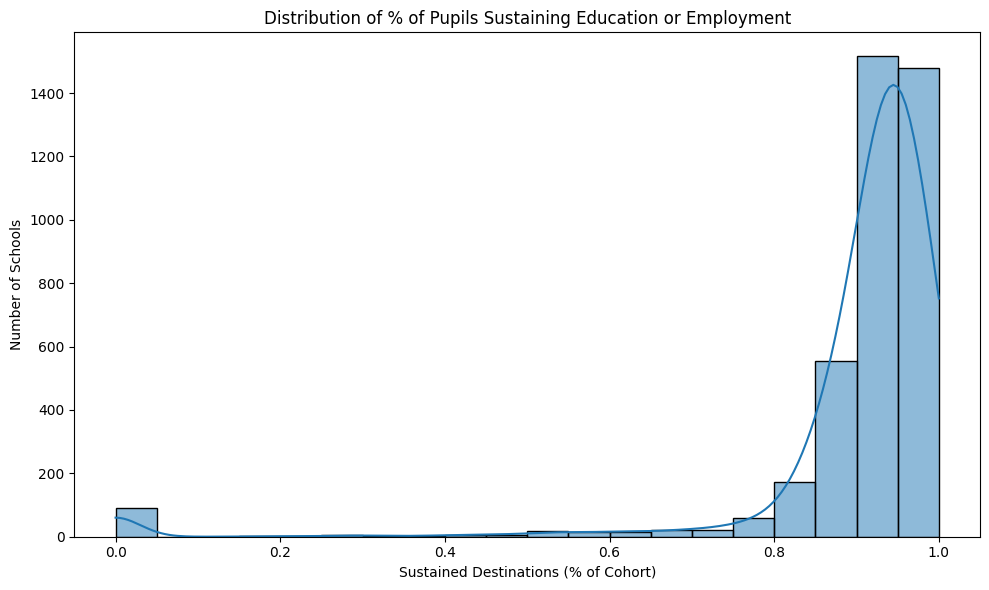

In [ ]:
# Step 1: Copy the original dataset
dest_df = pupdest_df.copy()

# Step 2: Ensure OVERALL_DEST and COHORT are numeric
dest_df['OVERALL_DEST'] = pd.to_numeric(dest_df['OVERALL_DEST'], errors='coerce')
dest_df['COHORT'] = pd.to_numeric(dest_df['COHORT'], errors='coerce')

# Step 3: Calculate % of pupils sustaining destinations
dest_df['DEST_PCT'] = dest_df['OVERALL_DEST'] / dest_df['COHORT']

# Step 4: Replace inf and NaN values resulting from division
dest_df['DEST_PCT'] = dest_df['DEST_PCT'].replace([np.inf, -np.inf], np.nan)
dest_df['DEST_PCT'] = dest_df['DEST_PCT'].fillna(0)

# Step 5: Plot the distribution of sustained destination percentages
plt.figure(figsize=(10, 6))
sns.histplot(dest_df['DEST_PCT'], bins=20, kde=True)
plt.title("Distribution of % of Pupils Sustaining Education or Employment")
plt.xlabel("Sustained Destinations (% of Cohort)")
plt.ylabel("Number of Schools")
plt.tight_layout()
plt.show()

The distribution of sustained positive destinations as a percentage of each school’s cohort reveals a stark pattern. While most schools succeed in sustaining the vast majority of their pupils in education or employment, often above 90%, there is a long tail of schools where outcomes are dramatically worse. A small but significant number of schools show sustained destination rates below 20%, raising concerns about persistent structural disadvantage or contextual challenges.

The distribution is heavily right-skewed, with most schools clustered near the upper end, but with a noticeable spread toward the lower end that cannot be ignored. This visualisation reinforced my hypothesis that not all schools are equally able to support their pupils beyond Key Stage 4, and that exploring the characteristics of those outlier schools could yield valuable insight.

### 4.2.2 Distribution of School Cohort Sizes (Under 1000)

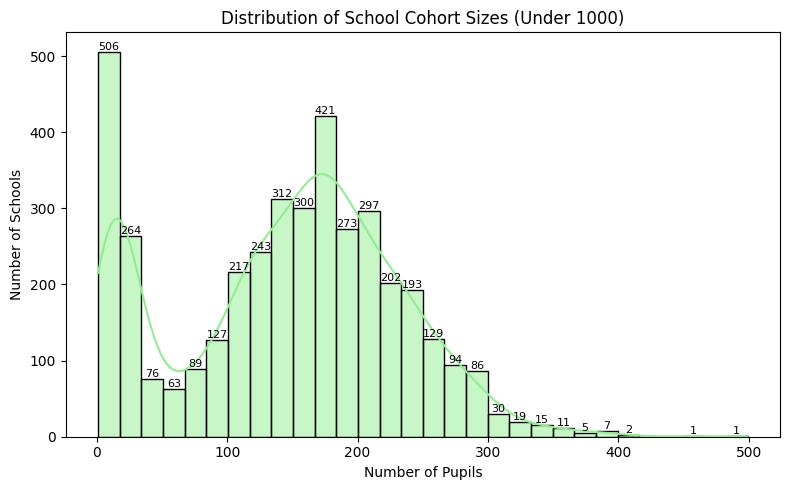

In [ ]:
limit = 1000
# Filter out extreme cohort values
filtered_df = pupdest_df[pupdest_df["COHORT"] < limit]  # or 500, depending on your dataset

# Plot again
plt.figure(figsize=(8, 5))
histplot = sns.histplot(filtered_df["COHORT"], bins=30, kde=True, color="lightgreen")

# Label bar counts
for patch in histplot.patches:
    height = patch.get_height()
    if height > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            height,
            f"{int(height)}",
            ha='center', va='bottom', fontsize=8
        )

plt.title(f"Distribution of School Cohort Sizes (Under {limit})")
plt.xlabel("Number of Pupils")
plt.ylabel("Number of Schools")
plt.tight_layout()
plt.show()

Exploring the distribution of school cohort sizes revealed an interesting pattern. While a number of schools have mid-sized cohorts around 150–200 pupils, there is a noticeable concentration of very small schools with fewer than 25 pupils. The distribution tails off sharply as cohort sizes increase, suggesting that small schools are more common in the dataset than initially expected. This raised the question of whether smaller schools might face greater challenges in sustaining pupil destinations compared to larger institutions.

### 4.2.3 Stacked Destination Rates for Sample 

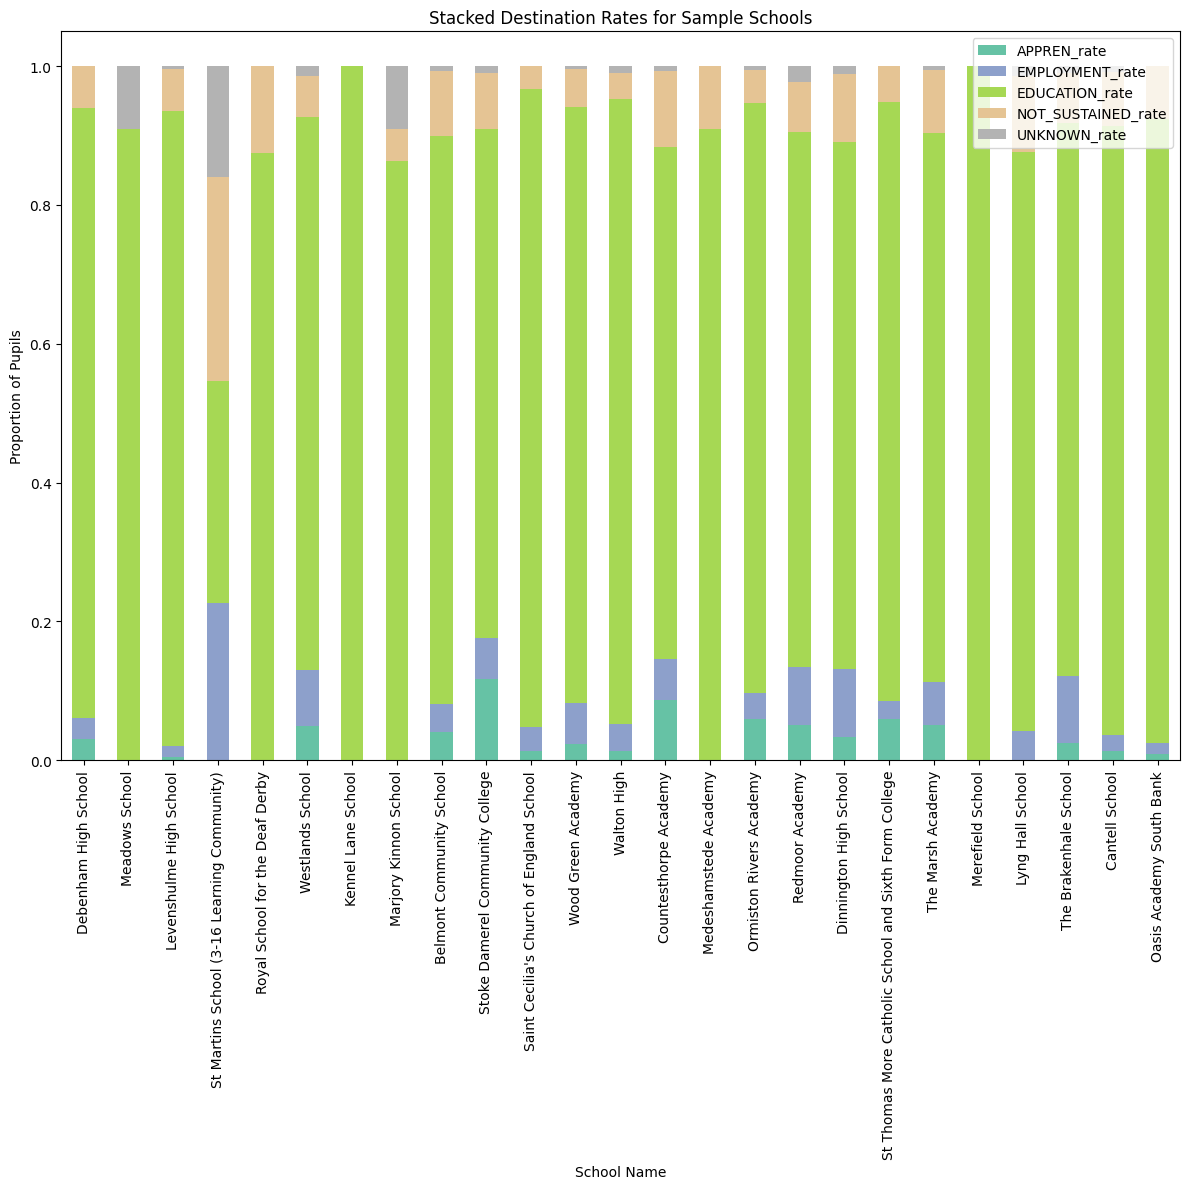

In [153]:
sample_size = 25

# Normalize each destination by cohort size
df_norm = pupdest_df.copy()

# Convert columns to numeric
cols_to_convert = ["APPREN", "EMPLOYMENT", "EDUCATION", "NOT_SUSTAINED", "UNKNOWN"]
df_norm[cols_to_convert] = df_norm[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Create rate columns
df_norm["APPREN_rate"] = df_norm["APPREN"] / df_norm["COHORT"]
df_norm["EMPLOYMENT_rate"] = df_norm["EMPLOYMENT"] / df_norm["COHORT"]
df_norm["EDUCATION_rate"] = df_norm["EDUCATION"] / df_norm["COHORT"]
df_norm["NOT_SUSTAINED_rate"] = df_norm["NOT_SUSTAINED"] / df_norm["COHORT"]
df_norm["UNKNOWN_rate"] = df_norm["UNKNOWN"] / df_norm["COHORT"]

# SAMPLE and include school name
df_sample = df_norm[["SCHNAME", "APPREN_rate", "EMPLOYMENT_rate", "EDUCATION_rate",
                     "NOT_SUSTAINED_rate", "UNKNOWN_rate"]].sample(n=sample_size)

# Set school name as index
df_sample.set_index("SCHNAME", inplace=True)

# Plot
df_sample.plot(kind="bar", stacked=True, figsize=(12, 12), colormap="Set2")
plt.title("Stacked Destination Rates for Sample Schools")
plt.ylabel("Proportion of Pupils")
plt.xlabel("School Name")
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

This stacked bar chart visualises the distribution of post-16 destinations across a random sample of 25 schools. While education remains the dominant pathway in nearly all cases and often accounts for the vast majority of pupils, the chart reveals important variations

Some schools show higher proportions of pupils entering employment or apprenticeships, suggesting a stronger vocational focus or local labour market alignment. A few schools stand out with noticeable rates of pupils not sustaining destinations or falling into unknown categories. These outliers raise important questions about the contextual or structural challenges those schools may face.

This variation supports the wider hypothesis that school-level characteristics influence post-16 outcomes. By visualising destination types as proportions of the cohort, this plot provides a more nuanced view of what “success” looks like, not just whether pupils go somewhere, but where they go and how consistently schools support sustained progression.

### 4.2.4 Education vs Not Sustained Outcomes (Cohort Coloured)

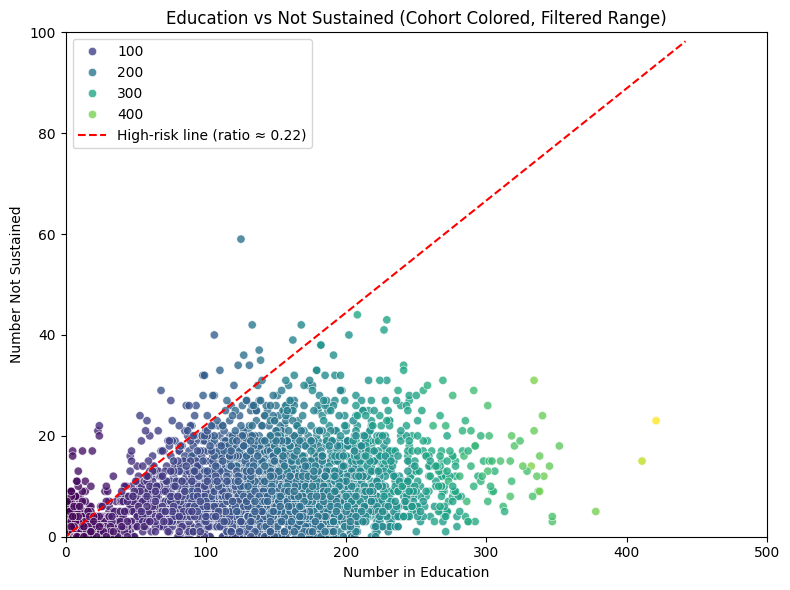

In [154]:
# Create a safe working copy for plotting only
plot_df = pupdest_df.copy()

# Ensure numeric types
plot_df["NOT_SUSTAINED"] = pd.to_numeric(plot_df["NOT_SUSTAINED"], errors="coerce")
plot_df["EDUCATION"] = pd.to_numeric(plot_df["EDUCATION"], errors="coerce")
plot_df["COHORT"] = pd.to_numeric(plot_df["COHORT"], errors="coerce")

# Create the ratio column, avoiding divide-by-zero
plot_df["RISK_RATIO"] = plot_df["NOT_SUSTAINED"] / plot_df["EDUCATION"].replace(0, pd.NA)

# Drop rows with missing values
plot_df = plot_df.dropna(subset=["RISK_RATIO", "EDUCATION", "NOT_SUSTAINED", "COHORT"])

# Define plot limits
x_limit = 500
y_limit = 100

# Filter to only data within display range
plot_df = plot_df[
    (plot_df["EDUCATION"] <= x_limit) & 
    (plot_df["NOT_SUSTAINED"] <= y_limit)
].copy()

# Calculate 95th percentile threshold of the risk ratio
risk_threshold = plot_df["RISK_RATIO"].quantile(0.95)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x="EDUCATION", y="NOT_SUSTAINED",
    hue="COHORT", palette="viridis", alpha=0.8
)

# Add high-risk threshold line
x_vals = plt.xlim()
plt.plot(x_vals, [risk_threshold * x for x in x_vals], 'r--', label=f"High-risk line (ratio ≈ {risk_threshold:.2f})")

plt.title("Education vs Not Sustained (Cohort Colored, Filtered Range)")
plt.xlabel("Number in Education")
plt.ylabel("Number Not Sustained")
plt.xlim(0, x_limit)
plt.ylim(0, y_limit)
plt.legend()
plt.tight_layout()
plt.show()

This scatterplot compares the number of pupils in sustained education against those not sustaining any positive destination, with each point representing a school. Most schools cluster near the bottom-left, where not sustained numbers remain low — particularly as education numbers rise. This aligns with expectations: higher engagement in education tends to correlate with fewer dropouts.

The red dashed line represents a threshold — roughly 22% of pupils not sustained relative to those in education. Schools above this line may signal higher-risk cases, where a disproportionately large share of pupils leave education without a sustained outcome. While these outliers are less common, they are notable and spread across different cohort sizes.

Larger schools appear to experience fewer extreme cases, but the variation among medium-sized schools suggests that size alone doesn’t fully explain performance. This visual reinforces the need to explore deeper structural or contextual features, such as SEN rates, deprivation levels, or school type, to understand why some schools fall significantly above this risk threshold.

### 4.2.5 Education vs % Not Sustained (Cohort Coloured, Filtered Range)

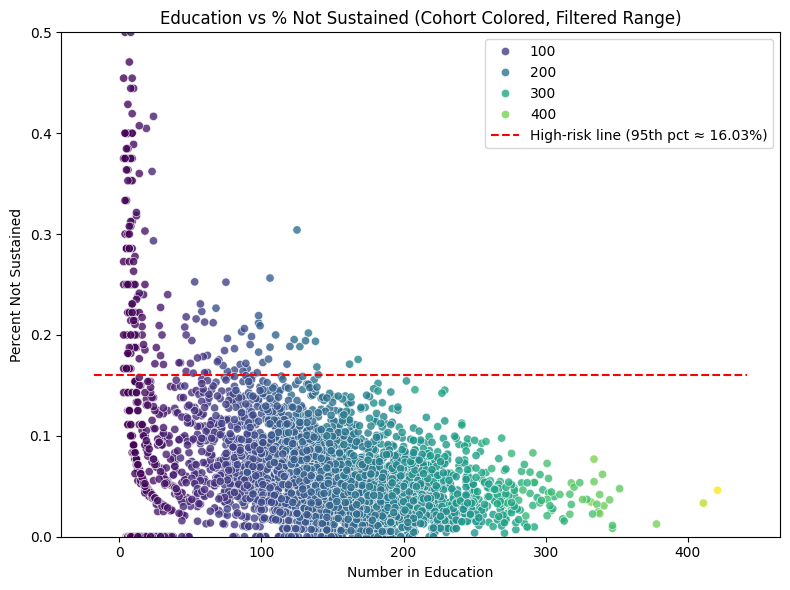

In [155]:
# ✅ Step 1: Create a clean local copy
plot_df = pupdest_df.copy()

# ✅ Step 2: Ensure numeric types
plot_df["NOT_SUSTAINED"] = pd.to_numeric(plot_df["NOT_SUSTAINED"], errors="coerce")
plot_df["EDUCATION"] = pd.to_numeric(plot_df["EDUCATION"], errors="coerce")
plot_df["COHORT"] = pd.to_numeric(plot_df["COHORT"], errors="coerce")

# ✅ Step 3: Compute metrics
plot_df["RISK_RATIO"] = plot_df["NOT_SUSTAINED"] / plot_df["EDUCATION"].replace(0, pd.NA)
plot_df["NOT_SUSTAINED_PCT"] = plot_df["NOT_SUSTAINED"] / plot_df["COHORT"]

# ✅ Step 4: Drop NaNs for clean plotting
df_ratio = plot_df.dropna(subset=["RISK_RATIO", "EDUCATION", "NOT_SUSTAINED_PCT", "COHORT"])

# ✅ Step 5: Set percentile threshold
risk_threshold = df_ratio["NOT_SUSTAINED_PCT"].quantile(0.95)

# ✅ Step 6: Filter to visible range
x_limit = 500
y_limit_pct = 0.5  # 50% not sustained

plot_df = df_ratio[
    (df_ratio["EDUCATION"] <= x_limit) & 
    (df_ratio["NOT_SUSTAINED_PCT"] <= y_limit_pct)
].copy()

# ✅ Step 7: Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x="EDUCATION",
    y="NOT_SUSTAINED_PCT",
    hue="COHORT",
    palette="viridis",
    alpha=0.8
)

# ✅ Step 8: Add high-risk line
x_vals = plt.xlim()
plt.plot(x_vals, [risk_threshold] * 2, 'r--', label=f"High-risk line (95th pct ≈ {risk_threshold:.2%})")

# ✅ Final labels and styling
plt.title("Education vs % Not Sustained (Cohort Colored, Filtered Range)")
plt.xlabel("Number in Education")
plt.ylabel("Percent Not Sustained")
plt.ylim(0, y_limit_pct)
plt.legend()
plt.tight_layout()
plt.show()

Shifting from raw counts to percentages, this chart offers a clearer picture of which schools may be disproportionately affected by poor post-16 outcomes. Rather than just looking at the number of pupils not sustaining destinations, this plot captures the risk level relative to each school’s size. What emerges is a striking pattern: schools with smaller cohorts tend to show greater variability, and many exceed the 95th percentile threshold — marked by the red line at approximately 16%.

While larger schools generally appear to maintain more stable outcomes, with low percentages of pupils not sustained, the smaller schools cluster with higher rates, even if their absolute numbers remain low. This reinforces the hypothesis that smaller institutions may face structural or contextual challenges that increase the risk of dropout or disengagement.

By combining this proportional view with earlier raw-value scatterplots, we gain a more complete picture: it’s not just the number of pupils at risk that matters, it’s how many relative to the size of the school. This insight is a critical turning point in the analysis, and provides a strong rationale to further explore school characteristics among those that exceed this high-risk threshold.

### 4.2.6 Top 10 Schools by Risk Ratio (Not Sustained / Education)

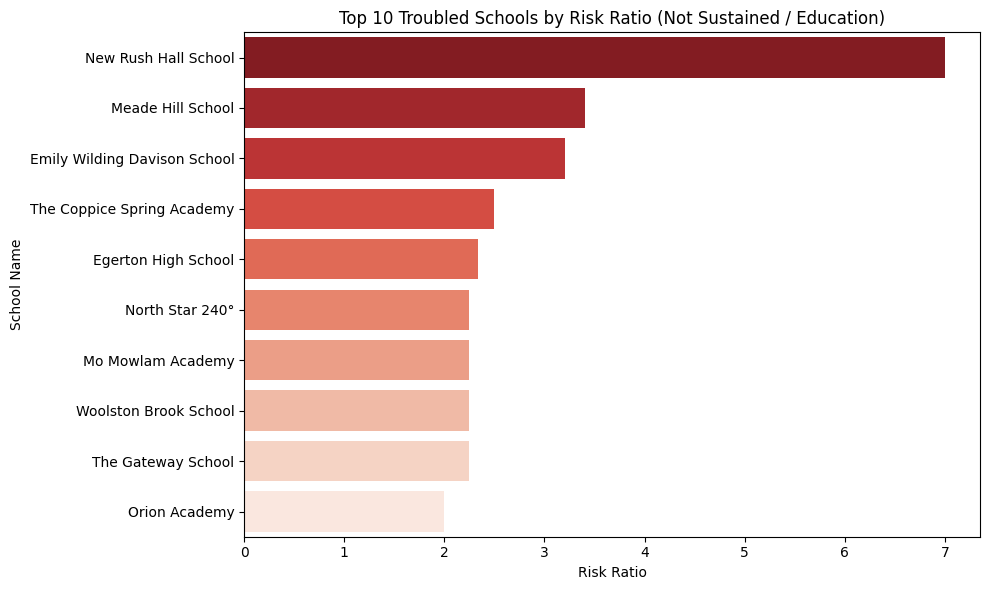

In [156]:
# Step 1: Create a local working copy
plot_df = pupdest_df.copy()

# Step 2: Ensure numeric types
plot_df["NOT_SUSTAINED"] = pd.to_numeric(plot_df["NOT_SUSTAINED"], errors="coerce")
plot_df["EDUCATION"] = pd.to_numeric(plot_df["EDUCATION"], errors="coerce")
plot_df["COHORT"] = pd.to_numeric(plot_df["COHORT"], errors="coerce")

# Step 3: Calculate risk ratio
plot_df["RISK_RATIO"] = plot_df["NOT_SUSTAINED"] / plot_df["EDUCATION"].replace(0, pd.NA)

# Step 4: Drop NaNs for clean processing
df_ratio = plot_df.dropna(subset=["RISK_RATIO", "EDUCATION", "NOT_SUSTAINED", "COHORT", "SCHNAME"]).copy()

# Step 5: Set 95th percentile threshold
risk_threshold = df_ratio["RISK_RATIO"].quantile(0.95)

# Step 6: Flag high-risk schools
df_ratio["ABOVE_RISK_LINE"] = df_ratio["NOT_SUSTAINED"] > (risk_threshold * df_ratio["EDUCATION"])

# Step 7: Extract top troubled schools
top_troubled = (
    df_ratio[df_ratio["ABOVE_RISK_LINE"]]
    .copy()
    .sort_values(by="RISK_RATIO", ascending=False)
    [["SCHNAME", "COHORT", "EDUCATION", "NOT_SUSTAINED", "RISK_RATIO"]]
    .head(10)
)

# Step 8: Sort for plotting
top_troubled_sorted = top_troubled.sort_values(by="RISK_RATIO", ascending=False).copy()

# Step 9: Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_troubled_sorted,
    x="RISK_RATIO",
    y="SCHNAME",
    hue="SCHNAME",  # fix for seaborn future warning
    palette="Reds_r",
    legend=False
)

plt.title("Top 10 Troubled Schools by Risk Ratio (Not Sustained / Education)")
plt.xlabel("Risk Ratio")
plt.ylabel("School Name")
plt.tight_layout()
plt.show()

This chart highlights the ten schools with the highest relative risk of pupils not sustaining positive destinations, measured as the ratio of pupils not sustained to those in education. These schools stand out as extreme outliers when compared to national patterns, with risk ratios that far exceed the 95th percentile threshold established earlier in the analysis.

Viewed in the context of the earlier scatter plots, these schools cluster well above the high-risk line, raising urgent questions about what structural or contextual factors may be at play. Some show ratios approaching or exceeding 7:1 meaning that for every pupil progressing in education, many more are falling through the cracks.

Rather than treating these schools as statistical anomalies, this analysis treats them as key focal points for deeper investigation. Understanding what sets these institutions apart, whether it’s size, SEN concentration, funding structure, or local context, may hold the key to designing more effective, targeted interventions.

## 4.3 Census Data Exploration

Having examined pupil destinations directly, the next step was to understand the school-level context behind those outcomes. This section explores the `census_df` dataset, which provides rich information about the demographic and structural makeup of each school, the environment in which pupils experience their education.

Key variables include:
- The proportion of pupils with Special Educational Needs (SEN)
- Free School Meals (FSM) eligibility as a proxy for deprivation
- Rates of English as an Additional Language (EAL)
- Gender balance and overall cohort size

These characteristics form the backdrop against which school performance and destination outcomes unfold. By visualising and analysing them, we begin to surface patterns and disparities, for instance, whether high SEN rates or socioeconomic disadvantage correlate with lower Progress 8 scores or sustained destinations.

This exploration builds the foundation for the predictive modelling to come. It moves us from simply observing outcomes to understanding the underlying pressures and risk factors that shape then, a critical step in identifying which schools may need targeted support.

### 4.3.1 Distribution of Pupils with EHC Plans by School

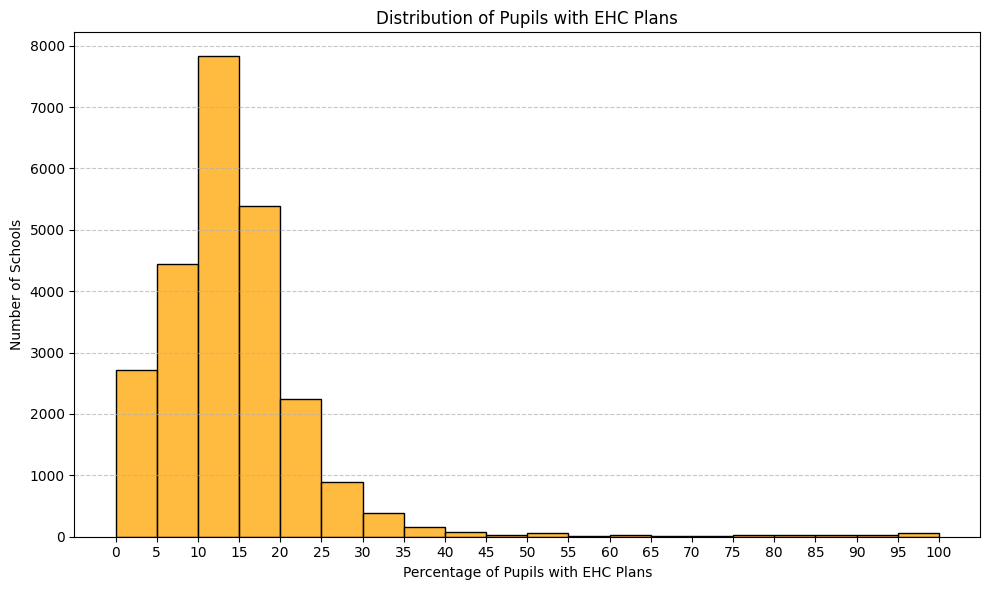

In [ ]:
# Convert to numeric safely (handle '%' signs or text like 'NA')
census_df["PSENELK"] = pd.to_numeric(
    census_df["PSENELK"].astype(str).str.replace('%', '', regex=False), errors='coerce'
)

# Plot full distribution
plt.figure(figsize=(10, 6))
sns.histplot(census_df["PSENELK"].dropna(), bins=np.arange(0, 101, 5), color="orange", edgecolor='black')

plt.title("Distribution of Pupils with EHC Plans")
plt.xlabel("Percentage of Pupils with EHC Plans")
plt.ylabel("Number of Schools")
plt.xticks(np.arange(0, 101, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This histogram shows the distribution of pupils with Education, Health and Care (EHC) Plans across schools. The data reveals that most schools fall within a 5% to 20% range, with a pronounced concentration between 10% and 15%. This clustering suggests a relatively consistent level of high-needs provision across much of the sector.

However, the long tail stretching toward the far right is just as important. A smaller group of schools report extremely high proportions of pupils with EHC Plans, sometimes upwards of 50%, and in rare cases, near total enrolment. These outliers almost certainly reflect specialist or alternative provision settings, where supporting pupils with complex or significant needs is the school’s core mission.

This distribution reinforces the importance of accounting for contextual factors when interpreting school outcomes. A school supporting a large proportion of pupils with EHC Plans may face unique challenges that affect both attainment and pupil destinations, challenges that won’t be visible through metrics alone. Recognising this uneven distribution of need is a key step in building fair, insight-driven models later in the analysis.

### 4.3.2 SEN Support Percentage by School Type (Capped at <50%)

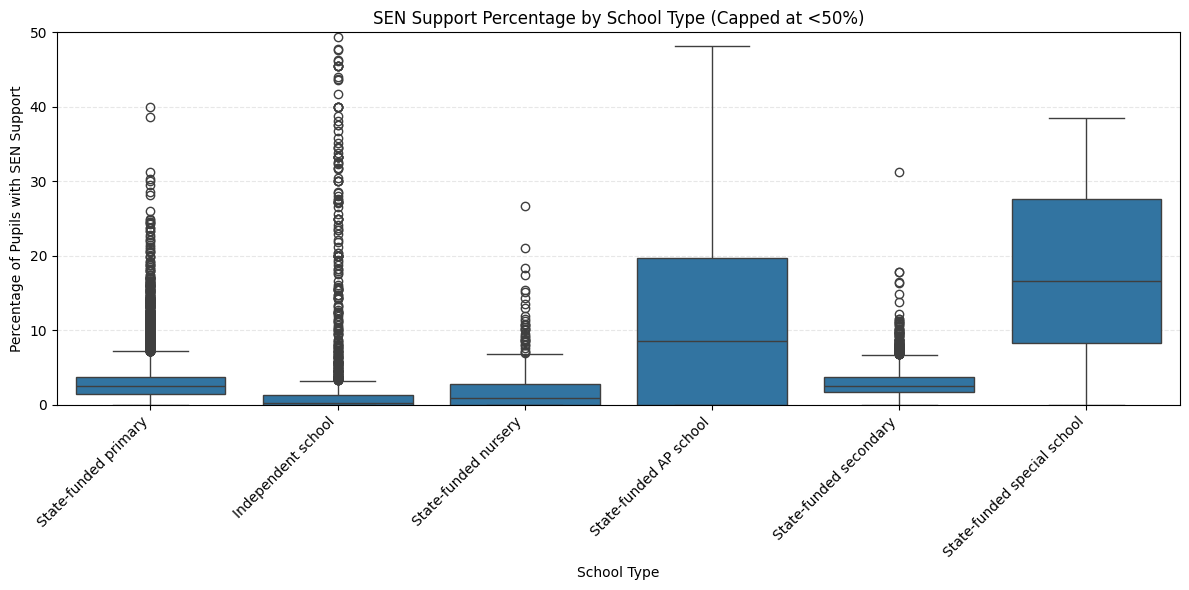

In [ ]:
# Convert PSENELSE to numeric (in case of strings or '%')
census_df["PSENELSE"] = pd.to_numeric(
    census_df["PSENELSE"].astype(str).str.replace('%', '', regex=False),
    errors="coerce"
)

# Plot with capped y-axis (< 50%)
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=census_df[census_df["PSENELSE"] < 50],
    x="SCHOOLTYPE", y="PSENELSE"
)

plt.xticks(rotation=45, ha="right")
plt.title("SEN Support Percentage by School Type (Capped at <50%)")
plt.xlabel("School Type")
plt.ylabel("Percentage of Pupils with SEN Support")
plt.ylim(0, 50)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

This boxplot reveals stark differences in the distribution of SEN support across school types. As expected, state-funded special schools and alternative provision (AP) schools exhibit both the highest and most varied percentages of pupils receiving SEN support. These settings are specifically designed to meet the needs of pupils requiring more intensive interventions, and the spread within these categories reflects the diversity of those needs.

In contrast, mainstream schools, particularly state-funded primaries and secondaries, show much lower and more tightly clustered SEN support levels. This consistency suggests more standardised intake patterns and perhaps more limited capacity for intensive SEN provision.

Independent schools, meanwhile, present an interesting case: while their median SEN support is low, the spread is wide, indicating that some may serve highly specialised cohorts while others serve none at all. This variability points to non-uniform identification practices or niche provision models within the independent sector.

This breakdown underscores how structural role and funding type shape a school’s SEN profile, an important consideration when comparing performance metrics or pupil outcomes across sectors.

### 4.3.3 Distribution of SEN Support (as Percentage of Pupils)

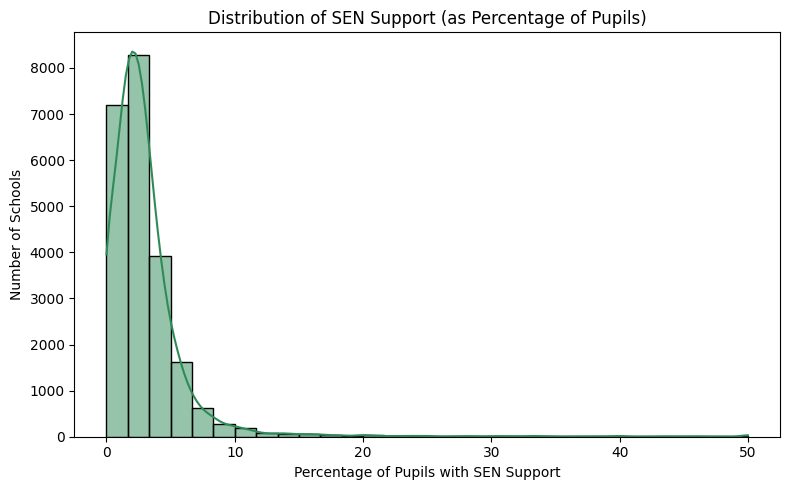

In [ ]:
# Convert PSENELSE to numeric if not already
census_df["PSENELSE"] = pd.to_numeric(
    census_df["PSENELSE"].astype(str).str.replace("%", ""), errors="coerce"
)

# Optional: filter extreme percentages if needed
filtered = census_df[census_df["PSENELSE"] <= 50]

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(filtered["PSENELSE"], bins=30, kde=True, color="seagreen")
plt.title("Distribution of SEN Support (as Percentage of Pupils)")
plt.xlabel("Percentage of Pupils with SEN Support")
plt.ylabel("Number of Schools")
plt.tight_layout()
plt.show()

This distribution reveals that the vast majority of schools have relatively low levels of pupils receiving SEN support, with a sharp peak just below 5%. The shape of the curve, heavily right-skewed, suggests that while intensive SEN support is present in the system, it is concentrated in a small number of schools.

These outliers likely reflect specialist or alternative provision environments, where schools are designed to support higher-needs pupils through targeted interventions. The rarity of high SEN support percentages among mainstream schools underscores how need is not evenly distributed across the education system.

This finding builds on earlier insights from the census data, highlighting how contextual differences between schools, not just performance metrics, shape pupil experiences. As we continue to explore pupil outcomes like Progress 8 and sustained destinations, this imbalance in SEN support will be a key variable to account for in both modelling and interpretation.

### 4.3.4 Top 20 Schools with Highest Boy-to-Girl Ratio

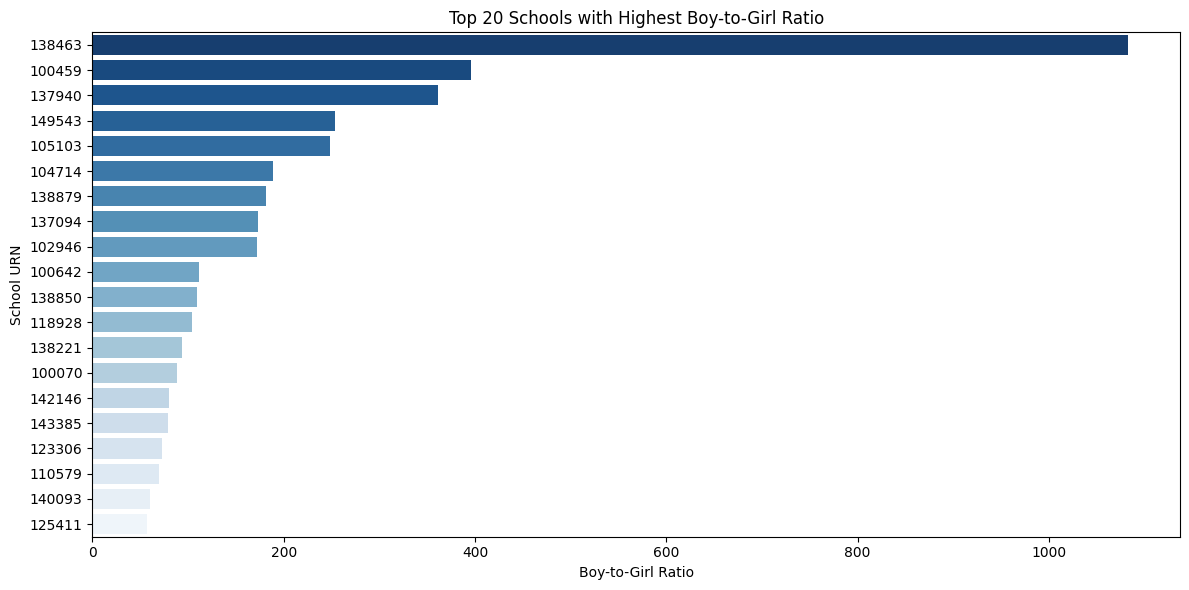

In [157]:
# Convert to numeric and calculate total & ratio
census_df["NORB"] = pd.to_numeric(census_df["NORB"], errors="coerce")  # Boys
census_df["NOR"] = pd.to_numeric(census_df["NOR"], errors="coerce")    # Total
census_df["GIRLS"] = census_df["NOR"] - census_df["NORB"]

# Filter valid rows and compute boy-to-girl ratio
census_df = census_df.dropna(subset=["NORB", "GIRLS"])
census_df = census_df[census_df["GIRLS"] > 0]  # avoid division by zero
census_df["BOY_GIRL_RATIO"] = census_df["NORB"] / census_df["GIRLS"]

# Sort and display top 20
top_ratio = census_df.sort_values("BOY_GIRL_RATIO", ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_ratio,
    x="BOY_GIRL_RATIO",
    y="URN",
    hue="URN",           # Add this to avoid FutureWarning
    palette="Blues_r",
    dodge=False,         # Ensure bars don't split
    legend=False         # Hide duplicate legend
)
plt.title("Top 20 Schools with Highest Boy-to-Girl Ratio")
plt.xlabel("Boy-to-Girl Ratio")
plt.ylabel("School URN")
plt.tight_layout()
plt.show()

This chart highlights the top 20 schools with the most imbalanced gender ratios, measured by the number of boys relative to girls on roll. While most schools on the list show significant male over-representation, one school stands out as an extreme outlier, with a boy-to-girl ratio far exceeding even the second-ranked institution.

Such an extreme imbalance may point to a legitimate context, for example, a boys-only school, or a specialist setting catering to boys with specific behavioural or SEND needs. Alternatively, it could indicate a data quality issue, such as a near-zero recorded number of girls creating an inflated ratio through division.

Regardless of the cause, this school’s outlier status is a reminder that not all datasets are clean, and not all anomalies are errors. Sometimes, they reflect underlying structural differences within the system. These high-ratio schools may have distinct pupil needs, different pastoral challenges, or operate under alternative models, all of which may influence outcomes like attainment and sustained destinations. As such, they warrant closer inspection before being included in comparative performance analyses.

### 4.3.5 Top 20 Schools by Boy-to-Girl Ratio (with Actual Counts)

In [ ]:
# Show top 20 schools with actual boy/girl numbers and ratios
top_ratio_table = top_ratio[["URN", "NORB", "GIRLS", "BOY_GIRL_RATIO"]].copy()
top_ratio_table["BOY_GIRL_RATIO"] = top_ratio_table["BOY_GIRL_RATIO"].round(2)

# Display the table
print(top_ratio_table.to_string(index=False))

   URN  NORB  GIRLS  BOY_GIRL_RATIO
138463  1083      1         1083.00
100459   396      1          396.00
137940  1084      3          361.33
149543   762      3          254.00
105103   993      4          248.25
104714  1324      7          189.14
138879   724      4          181.00
137094  1036      6          172.67
102946  1553      9          172.56
100642   557      5          111.40
138850   986      9          109.56
118928   935      9          103.89
138221   937     10           93.70
100070   266      3           88.67
142146    80      1           80.00
143385   864     11           78.55
123306   363      5           72.60
110579   210      3           70.00
140093   120      2           60.00
125411   453      8           56.62


This table provides a closer look at the schools behind the extreme gender ratios highlighted in the previous chart. In every case, the inflated boy-to-girl ratios are driven not by unusually high numbers of boys, but by vanishingly small counts of girls, sometimes as low as one or two in a school of several hundred pupils. The mathematical effect is dramatic: when the denominator is this small, the resulting ratios soar, in some cases exceeding 1000 to 1.

While these figures are technically accurate, they demand careful interpretation. They likely reflect boys-only institutions, specialist alternative provision, or schools with specific behavioural or SEND remits where male over-representation is common. In such contexts, skewed gender ratios are not necessarily anomalies, they are features of the institutional design.

Rather than excluding these schools from analysis outright, this finding underscores the importance of embedding contextual awareness into any comparative metrics. Gender balance, like SEN concentration or cohort size, is not a random variable, it is often a function of a school’s purpose. As such, it should be accounted for explicitly when modelling performance or assessing fairness.

### 4.3.6 Distribution of EAL % Across Schools

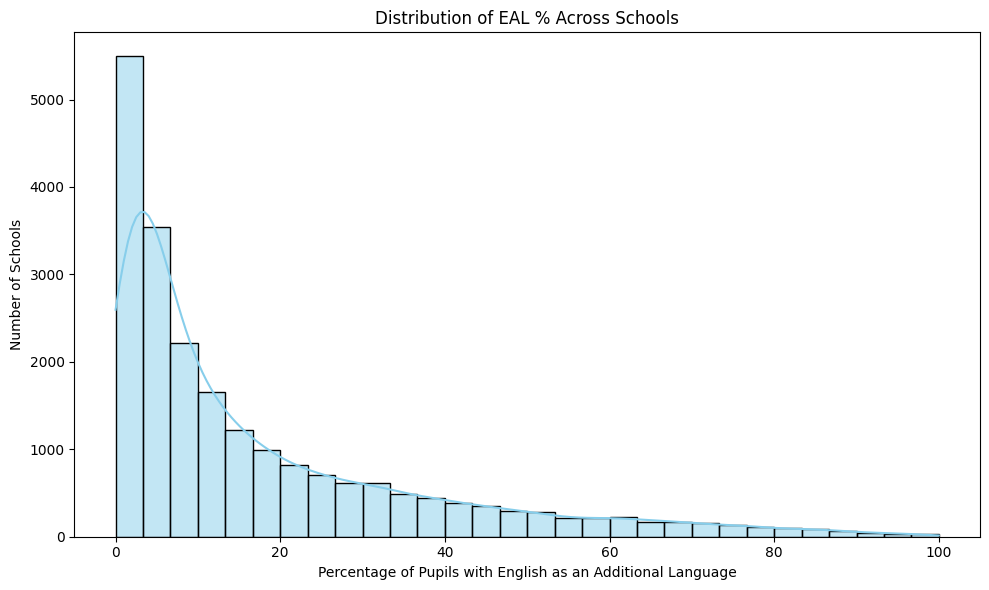

In [ ]:
# Clean PNUMEAL column
plot_df = census_df.copy()
plot_df["PNUMEAL"] = (
    plot_df["PNUMEAL"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .replace(["SUPP", "NP"], pd.NA)
    .astype(float)
)

# Drop missing
plot_df = plot_df.dropna(subset=["PNUMEAL"])

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(plot_df["PNUMEAL"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of EAL % Across Schools")
plt.xlabel("Percentage of Pupils with English as an Additional Language")
plt.ylabel("Number of Schools")
plt.tight_layout()
plt.show()

This distribution of pupils with English as an Additional Language (EAL) reveals a system marked by imbalance. Most schools report relatively low proportions of EAL pupils, with a steep concentration in the 0–10% range. But beyond that early drop-off lies a long, stretched tail, a smaller group of schools where 50%, 70%, or even more than 90% of pupils speak a language other than English at home.

This extreme skew suggests that linguistic diversity is not evenly distributed across the school system. Instead, it is concentrated in a subset of schools likely located in urban centres or areas with high levels of migration and mobility. These schools may face unique challenges around language acquisition, cultural integration, and parental engagement, factors that may in turn influence educational outcomes and sustained destinations.

Recognising this distribution is essential not only for contextual fairness in comparative analysis, but also for policy design. Schools at the far end of this distribution are not simply outliers, they are hubs of linguistic complexity and rich cultural variation. Future analysis will explore whether these schools exhibit different trends in Progress 8 or destination stability compared to their less diverse counterparts.

### 4.3.7 EAL % Distribution by School Type

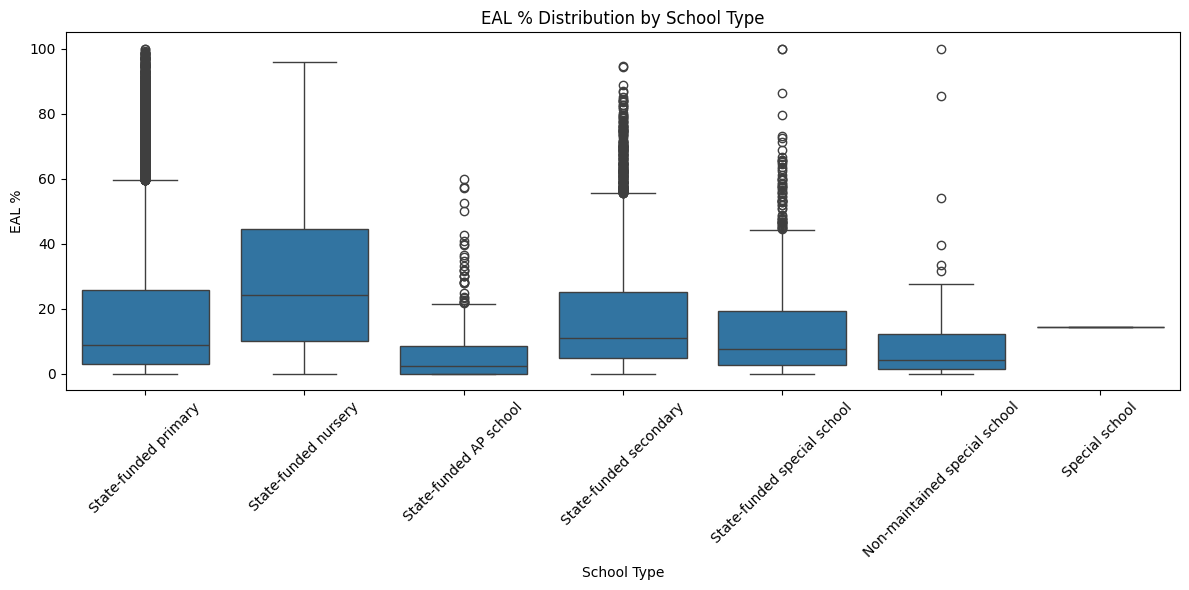

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x="SCHOOLTYPE", y="PNUMEAL")
plt.title("EAL % Distribution by School Type")
plt.xlabel("School Type")
plt.ylabel("EAL %")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This boxplot reveals how the proportion of pupils with English as an Additional Language (EAL) varies by school type. Among all categories, state-funded primary, secondary, and nursery schools show the widest range, with some reporting EAL percentages approaching 100%. These school types also have the highest median values, underscoring their role as the front line of language support in England’s education system.

In contrast, special schools and alternative provision (AP) settings tend to serve far fewer EAL pupils. Their lower medians and tighter interquartile ranges suggest more homogeneous language profiles. This likely reflects the specific remits of these schools,  many of which focus on pupils with SEND or behavioural needs, where linguistic diversity may be less of a systemic factor.

What this chart highlights is a concentration of EAL needs in mainstream settings, especially in the early stages of education. These patterns are not random; they reflect local demographic dynamics, such as urban density and recent migration trends, which shape catchment intakes. As with SEN and gender balance, this structural variation should be factored into any model assessing school outcomes, because linguistic diversity brings both complexity and opportunity.

### 4.3.8 SEN % vs EAL % Across Schools (Coloured by FSM %)

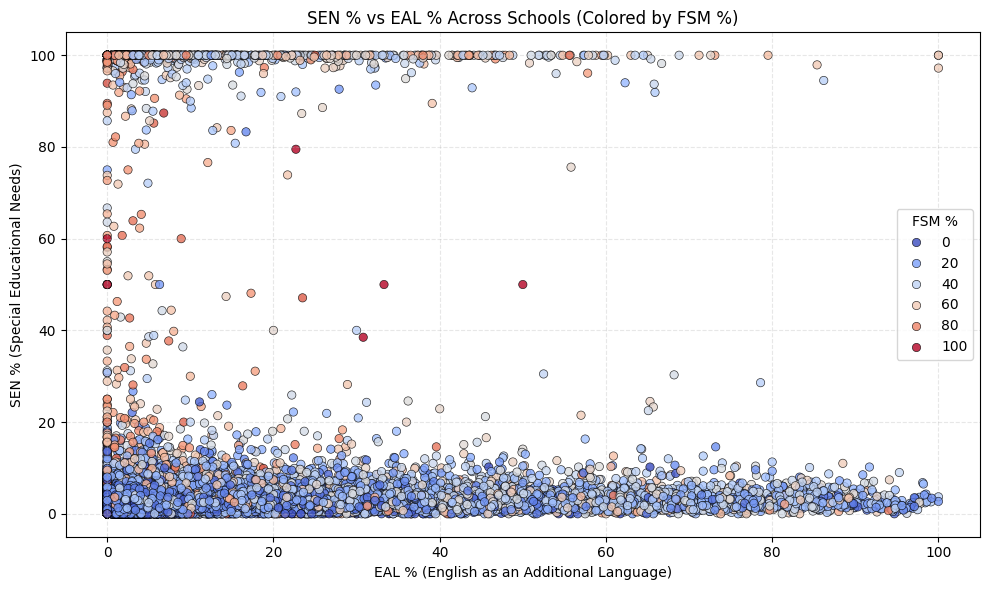

In [ ]:
# Make a copy of your census data
plot_df = census_df.copy()

# Clean PNUMEAL (EAL %) and PSENELSE (SEN %) columns
plot_df["PNUMEAL"] = (
    plot_df["PNUMEAL"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .replace(["SUPP", "NP"], pd.NA)
    .astype(float)
)

plot_df["PSENELSE"] = (
    plot_df["PSENELSE"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .replace(["SUPP", "NP"], pd.NA)
    .astype(float)
)

# Add FSM % column (clean it first)
plot_df["PNUMFSMEVER"] = (
    plot_df["PNUMFSMEVER"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .replace(["SUPP", "NP"], pd.NA)
    .astype(float)
)

# Drop missing values in the new color variable
plot_df = plot_df.dropna(subset=["PNUMFSMEVER"])

# Plot with color mapped to FSM %
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x="PNUMEAL", 
    y="PSENELSE", 
    hue="PNUMFSMEVER",         # Color by FSM %
    palette="coolwarm",     # You can try 'viridis', 'magma', etc.
    alpha=0.8,
    edgecolor="black"
)

plt.title("SEN % vs EAL % Across Schools (Colored by FSM %)")
plt.xlabel("EAL % (English as an Additional Language)")
plt.ylabel("SEN % (Special Educational Needs)")
plt.legend(title="FSM %")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

This scatterplot explores the relationship between three key indicators of pupil context: the percentage of pupils with Special Educational Needs (SEN), those with English as an Additional Language (EAL), and eligibility for Free School Meals (FSM), shown through colour shading. What becomes immediately clear is that these forms of disadvantage do not consistently overlap. Schools with high SEN rates may have low EAL levels, and vice versa. Similarly, FSM percentages are scattered across the entire plot, showing no discernible trend with either axis.

This lack of alignment suggests that disadvantage in schools is multidimensional and fragmented, not all high-need schools look the same, and different types of need cluster in different contexts. One school may struggle with linguistic diversity, another with deprivation, and another with high levels of learning support requirements, but rarely all three in equal measure.

This reinforces a key insight in the analysis: no single measure of disadvantage tells the full story. As we move toward modelling outcomes, it will be essential to treat these variables as complementary, not interchangeable. Aggregating or substituting one for another risks flattening the complexity that real schools face.

## 4.4 Results Data Exploration

Having explored pupil characteristics and school contexts, the next stage of the journey turns to academic performance. This section draws on the results_df dataset, which captures how schools performed at Key Stage 4 (KS4) — the critical endpoint of compulsory education in England.

The dataset includes several core accountability metrics:
- Progress 8 (P8MEA) – tracking pupil progress from Key Stage 2 to KS4 across eight subjects, and often used as a headline measure of school effectiveness.
- Attainment 8 – providing a raw score of pupil achievement across English, Maths, EBacc subjects, and other qualifications.
- EBacc entry and achievement rates – offering insight into subject breadth and curriculum ambition.
- GCSE pass rates (grades 9–4 and 9–5) in English and Maths – benchmarks for academic thresholds.

This section aims to uncover how these performance measures are distributed across schools, identify outliers — both high and low — and begin to link performance with the contextual data explored earlier. In doing so, we lay the academic groundwork for interpreting post-16 outcomes and for building fair, context-aware predictive models later in the analysis.

### 4.4.1 Top & Bottom 50 Schools by Progress 8 Score

/var/folders/lr/k4gd23sn6wxcry0p64dztv0c0000gn/T/ipykernel_63382/2647682836.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=combined_df, x='P8MEA', y='SCHNAME', palette='gray')  # Neutral placeholder


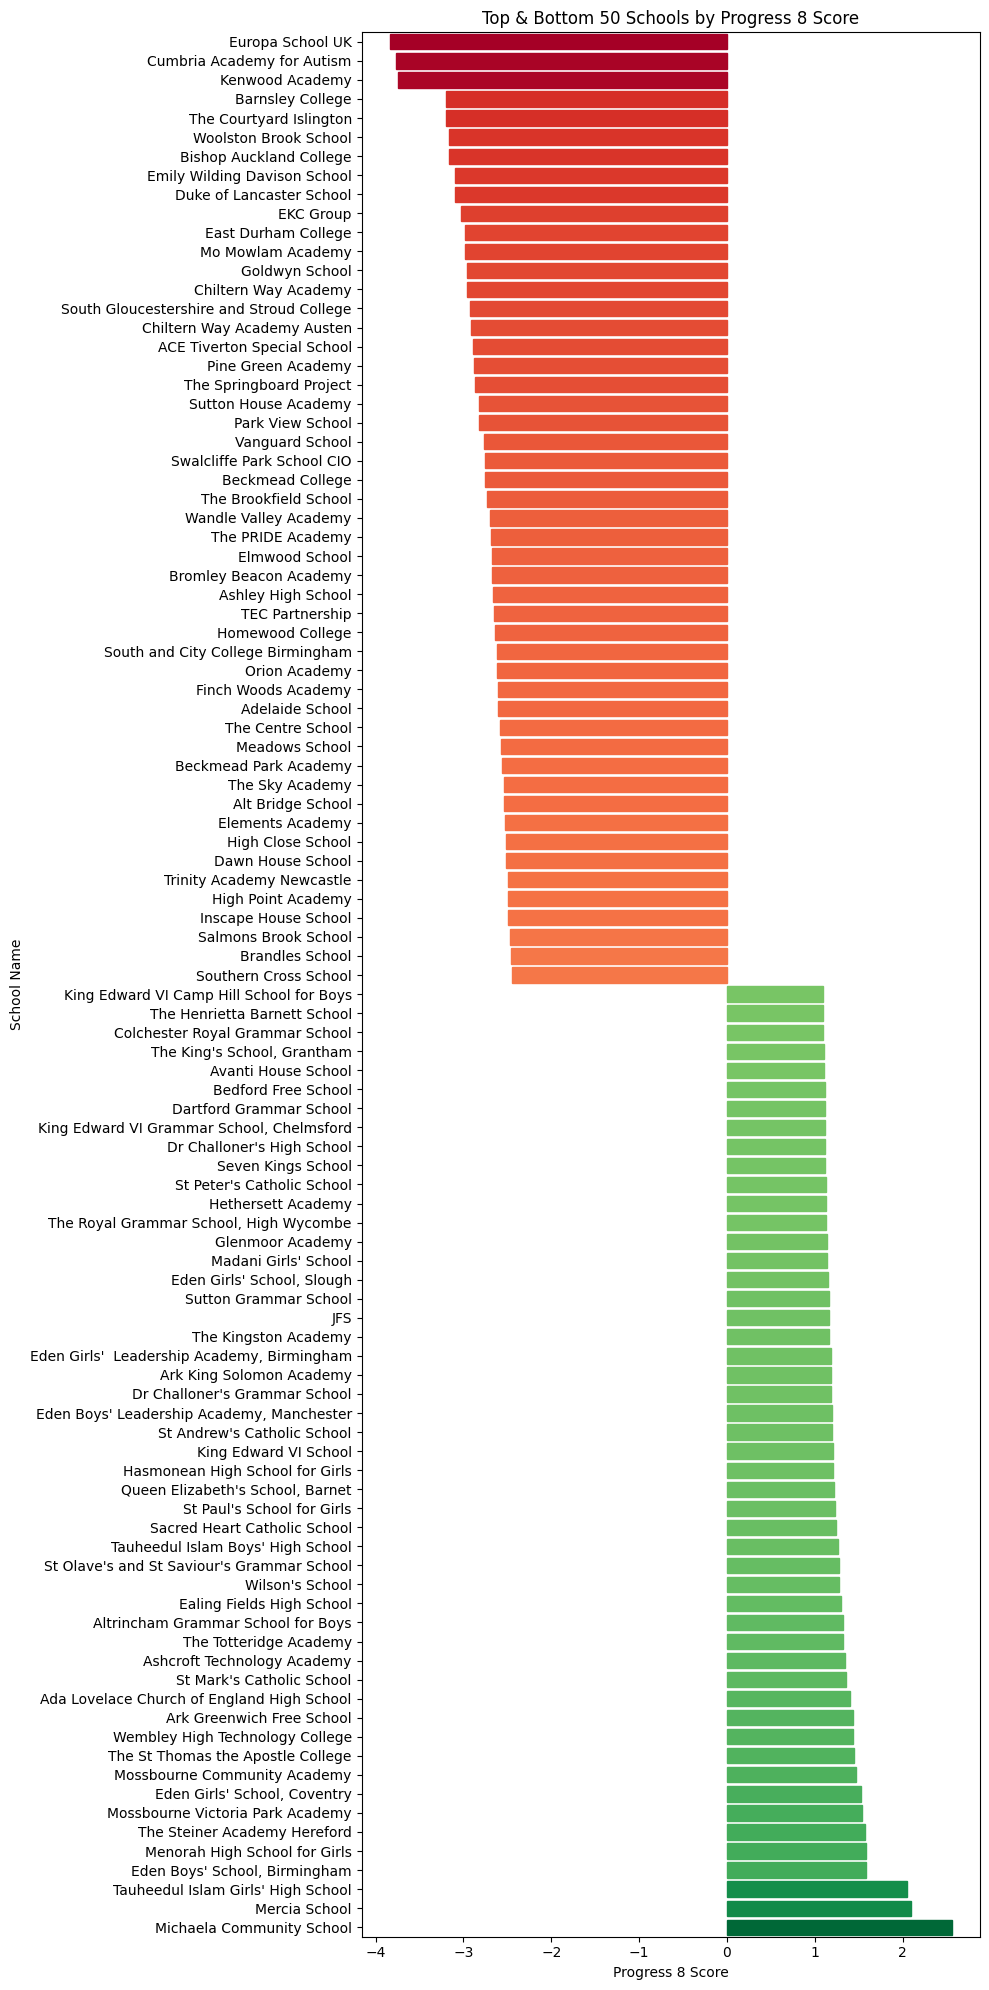

In [ ]:
# Clean P8MEA
results_df1 = results_df[results_df['P8MEA'] != 'NP'].copy()
results_df1['P8MEA'] = pd.to_numeric(results_df1['P8MEA'], errors='coerce')

# Sort and combine top & bottom 50
sorted_df = results_df1[['SCHNAME', 'P8MEA']].dropna().sort_values(by='P8MEA')
combined_df = pd.concat([
    sorted_df.head(50),
    sorted_df.tail(50)
])

# Reset index for plotting
combined_df = combined_df.reset_index(drop=True)

# Create color scale based on P8MEA
cmap = get_cmap('RdYlGn')  # Red = low, Green = high
norm = Normalize(
    vmin=results_df1['P8MEA'].min(),
    vmax=results_df1['P8MEA'].max()
)
colors = [cmap(norm(value)) for value in combined_df['P8MEA']]

# Plot
plt.figure(figsize=(10, 20))  # Taller figure for long plot
sns.barplot(data=combined_df, x='P8MEA', y='SCHNAME', palette=colors)
plt.title("Top & Bottom 50 Schools by Progress 8 Score")
plt.xlabel("Progress 8 Score")
plt.ylabel("School Name")
plt.tight_layout()
plt.show()

This chart visualises the stark contrasts in academic progress made by pupils across schools in England, as measured by the Progress 8 accountability score. The spread is dramatic: some schools achieve scores above +2, an exceptional level of value-added progress, while others dip below -3, indicating that pupils, on average, performed significantly below expectations compared to similar peers nationally.

This isn’t just statistical noise; it reflects deep and persistent disparities in educational opportunity. The top-performing schools are predominantly grammar schools or faith-based institutions, which may benefit from selective intake, stable funding, and highly engaged parental communities. In contrast, many of the lowest scoring schools include alternative provision (AP), special schools, or colleges, where pupil cohorts often present with higher levels of need, disruption, or disadvantage.

What this plot reveals is that not all schools are working with the same foundations, and so not all Progress 8 scores mean the same thing. This reinforces the argument that performance data must be contextualised, not only in terms of pupil background but also school mission and structural constraints. These insights provide a crucial anchor for your modelling and fairness frameworks in the sections that follow.

### 4.4.2 Distribution of Progress 8 Scores

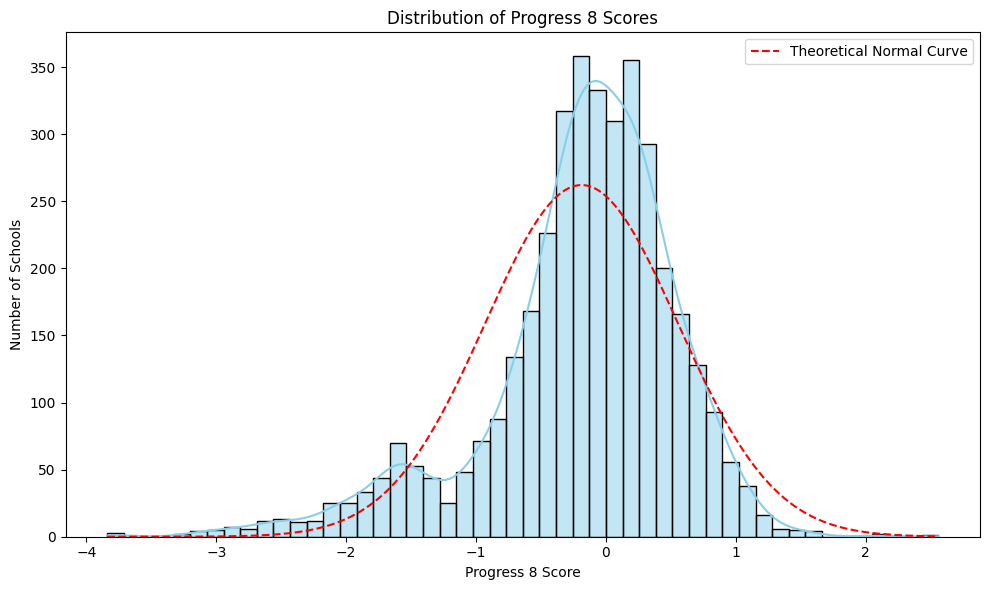

In [ ]:
# Convert to numeric, coercing errors
results_df['P8MEA'] = pd.to_numeric(results_df['P8MEA'], errors='coerce')

# Drop NaNs
p8_clean = results_df['P8MEA'].dropna()

# Calculate mean and std for normal distribution
mean = p8_clean.mean()
std = p8_clean.std()

# Create x values for normal curve
x = np.linspace(p8_clean.min(), p8_clean.max(), 500)
normal_curve = normal_dist.pdf(x, mean, std) * len(p8_clean) * (p8_clean.max() - p8_clean.min()) / 50  # scale to match histogram

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(p8_clean, bins=50, kde=True, color='skyblue', stat='count', edgecolor='black')
plt.plot(x, normal_curve, color='red', linestyle='--', label='Theoretical Normal Curve')
plt.title('Distribution of Progress 8 Scores')
plt.xlabel('Progress 8 Score')
plt.ylabel('Number of Schools')
plt.legend()
plt.tight_layout()
plt.show()

This histogram illustrates the national distribution of Progress 8 scores, the government’s headline measure of academic progress between Key Stage 2 and Key Stage 4. As intended by design, the distribution is approximately normal and centred around zero, indicating that most schools are performing close to the expected benchmark when averaged nationally.

But a closer look reveals a notable anomaly: a secondary peak around -1.5. This bump, not characteristic of a true normal distribution, suggests the presence of a distinct subgroup of consistently underperforming schools. Their concentration in the lower tail of the distribution raises important questions, not about random variation, but about structural factors that may be pulling these schools downward.

This visual insight aligns with earlier findings: school performance is not solely a function of internal quality, but also shaped by contextual pressures such as pupil intake, funding limitations, SEN concentrations, or school type (e.g. alternative provision or specialist settings). As such, this second mode in the data isn’t a statistical blip, it’s a signal worth investigating. Later sections will test whether these schools can be identified through their contextual profiles and whether interventions can be better targeted as a result.

### 4.4.3 Progress 8 Scores by School Type

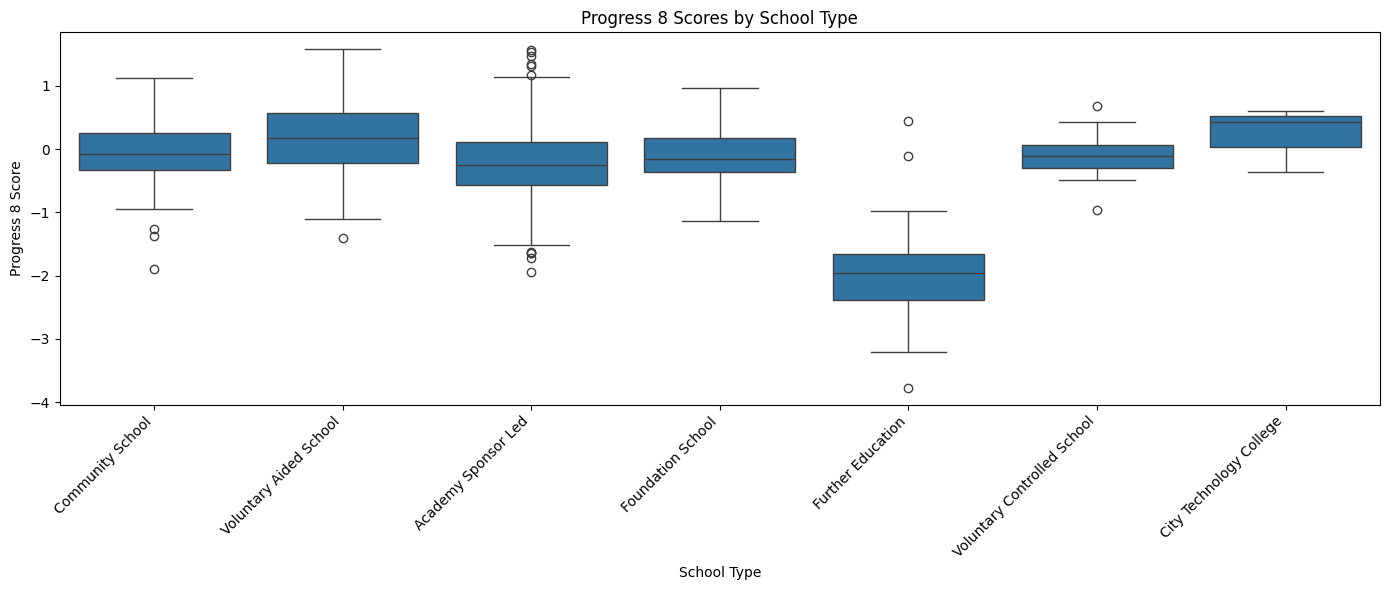

In [ ]:
# Clean and filter Progress 8 values
df1 = results_df[results_df['P8MEA'] != 'NP'].copy()
df1['P8MEA'] = pd.to_numeric(df1['P8MEA'], errors='coerce')

# Map school type codes to full names
df1['School Type'] = df1['NFTYPE'].map(school_type_map)

# Drop rows with missing mapped types or P8 scores
df1 = df1.dropna(subset=['P8MEA', 'School Type'])

# Plot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df1, x='School Type', y='P8MEA')
plt.title('Progress 8 Scores by School Type')
plt.xticks(rotation=45, ha='right')
plt.xlabel('School Type')
plt.ylabel('Progress 8 Score')
plt.tight_layout()
plt.show()

This boxplot underscores how school structure and designation can shape academic progress as measured by Progress 8. While most mainstream school types, including Community, Foundation, and Academies, cluster closely around the national average, the story is very different at the margins.

Further Education (FE) settings show strikingly lower performance, with a median far below zero and a wide band of extreme negative outliers. These schools often serve non-traditional or high-need learners, including those who may have struggled in other settings, a factor that likely depresses measured progress. In contrast, City Technology Colleges and Voluntary Aided Schools post some of the highest median scores in the dataset, with relatively narrow interquartile ranges, suggesting stable, consistently high performance.

These differences likely stem from more than teaching quality alone. They reflect intake profiles, funding arrangements, and institutional remits. Selective or faith-based schools may benefit from motivated families and fewer contextual barriers, while alternative providers carry a heavier burden of disadvantage.

This chart reinforces the importance of not treating Progress 8 scores as stand-alone indicators of school quality. Understanding what kind of school we’re looking at, and who it serves, is essential for making fair comparisons and for targeting support where it’s needed most.

## 4.5 Pupdest & Census Dataset Joining

As the investigation deepened, it became clear that no single dataset could tell the full story. To uncover the relationships between school context, performance, and pupil outcomes, I brought together multiple data sources, each offering a different lens on the system. The key to this integration was the URN (Unique Reference Number), a shared identifier across all schools.

Before merging, I standardised the URN fields across datasets, resolving inconsistencies in formatting and datatype. This preprocessing step ensured a clean and reliable join between the census_df (capturing demographic and structural characteristics) and the pupdest_df (focusing on pupil destinations after Key Stage 4).

The resulting merged_df opened the door to richer, more multidimensional analysis, allowing me to directly examine how features like cohort size, SEN rates, or EAL percentages relate to key outcomes such as Progress 8 scores or sustained education and employment.

Rather than viewing schools through isolated metrics, this unified dataset allows patterns to emerge across domains, revealing more of the underlying forces that shape educational success or compound disadvantage.

In [ ]:
# Drop rows where URN is NaN
pupdest_df = pupdest_df[pupdest_df['URN'].notna()]

# Now safely convert to int then string
pupdest_df['URN'] = pupdest_df['URN'].astype(int).astype(str)

# Also clean the census URN column
census_df['URN'] = census_df['URN'].astype(str).str.strip()

In [ ]:
merged_df = pd.merge(census_df, pupdest_df, on='URN', how='inner') # keeps rows that are in both datasets
merged_df.shape

(3844, 108)

In [ ]:
# Check data type of URNs
print(merged_df['URN'].dtype)
print(results_df['URN'].dtype)

object
float64


In [ ]:
results_df1 = results_df.copy()
# Step 1: Convert to float first (handles '100003.0' style strings)
results_df1['URN'] = pd.to_numeric(results_df['URN'], errors='coerce')

# Step 2: Drop rows with NaNs (if any, or handle differently)
results_df1 = results_df.dropna(subset=['URN'])

# Step 3: Convert to int, then to string
results_df1['URN'] = results_df1['URN'].astype(int).astype(str)

/var/folders/lr/k4gd23sn6wxcry0p64dztv0c0000gn/T/ipykernel_63382/3149883778.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df1['URN'] = results_df1['URN'].astype(int).astype(str)


In [ ]:
merged_results_df = pd.merge(merged_df, results_df1, on='URN', how='inner')
merged_results_df.shape
#merged_results_df.head()


(3844, 536)

In [ ]:
# Convert columns safely
merged_df["OVERALL_DEST"] = pd.to_numeric(merged_df["OVERALL_DEST"], errors="coerce")
merged_df["COHORT"] = pd.to_numeric(merged_df["COHORT"], errors="coerce")

# Avoid divide-by-zero and calculate DEST_RATIO
merged_df = merged_df[merged_df["COHORT"] > 0]
merged_df["DEST_RATIO"] = merged_df["OVERALL_DEST"] / merged_df["COHORT"]

## 4.6 Pupdest & Census Dataset Exploration

This integrated approach supports deeper insight into **patterns of success and disparity**, helping to identify which school characteristics may be associated with stronger or weaker pupil destinations.

### 4.6.1 SEN Support (%) vs Proportion of Sustained Destinations

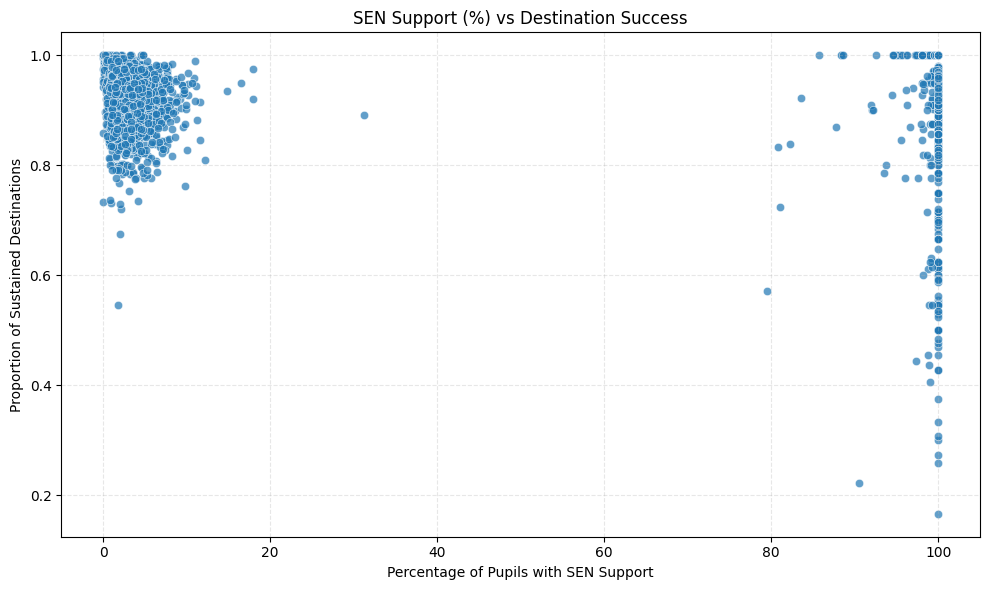

In [ ]:
# Create a temporary copy for exploration
plot_df = merged_df.copy()

# Clean PSENELSE non-destructively
plot_df["PSENELSE"] = pd.to_numeric(
    plot_df["PSENELSE"].astype(str).str.replace("%", ""), 
    errors="coerce"
)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x="PSENELSE", y="DEST_RATIO", alpha=0.7)
plt.title("SEN Support (%) vs Destination Success")
plt.xlabel("Percentage of Pupils with SEN Support")
plt.ylabel("Proportion of Sustained Destinations")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

This scatterplot reveals a striking polarisation in the data: schools tend to cluster at either end of the spectrum when it comes to the proportion of pupils receiving Special Educational Needs (SEN) support. On one side, we see mainstream schools with relatively low SEN percentages, on the other, specialist settings where nearly the entire cohort receives SEN support.

What’s particularly revealing is that both groups include schools with strong destination outcomes, suggesting that high SEN intake does not preclude success. However, the schools with near-total SEN representation display much greater variability, with some achieving excellent sustained destinations and others struggling. This spread reflects the diversity of specialist provision, ranging from highly resourced therapeutic environments to underfunded alternative settings serving highly complex pupils.

The implication is clear: interpreting destination data without understanding school context risks misrepresenting what success looks like. For some schools, sustaining 70% of a high-needs cohort in education or employment is a significant achievement. This chart highlights the need for outcome frameworks that are not only statistically robust but also sensitive to institutional mission and pupil need.

### 4.6.2 School Size vs Proportion of Sustained Destinations

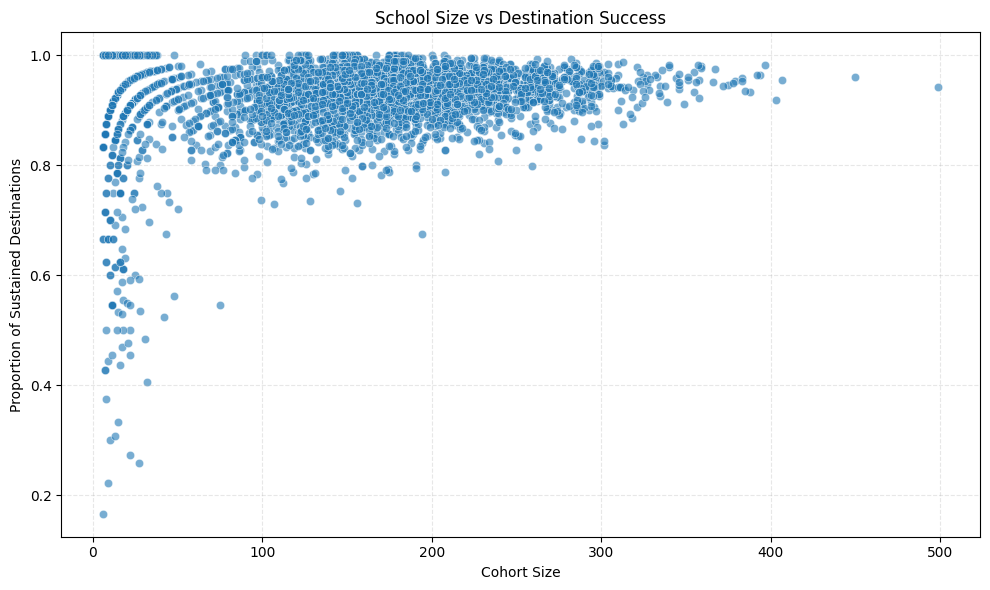

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="COHORT", y="DEST_RATIO", alpha=0.6)
plt.title("School Size vs Destination Success")
plt.xlabel("Cohort Size")
plt.ylabel("Proportion of Sustained Destinations")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

This scatterplot highlights a clear pattern: larger schools tend to achieve higher and more consistent rates of sustained destinations after Key Stage 4. As cohort size increases, the proportion of pupils remaining in education or employment converges tightly around 90–100%, forming a dense cluster of stable outcomes.

In contrast, small schools, particularly those with cohorts under 50, display far greater variability. While some perform exceptionally well, many fall well below the national average, with a few recording destination rates as low as 20%. This wider spread among small schools likely reflects a mix of factors: limited curriculum breadth, stretched pastoral support, or a higher concentration of vulnerable pupils, all of which can disproportionately affect outcomes in smaller settings.

Rather than indicating underperformance alone, this variability suggests that scale matters. Larger institutions may benefit from economies of support, broader post-16 pathways, and more robust tracking systems, advantages that smaller schools may struggle to replicate.

Cohort size, alongside factors such as SEN concentration and EAL proportions, emerges as a key structural influence on pupil outcomes. Any fair assessment of school performance must recognise that institutional capacity shapes what success looks like.

### 4.6.3 Correlation Heatmap of Numeric Variables

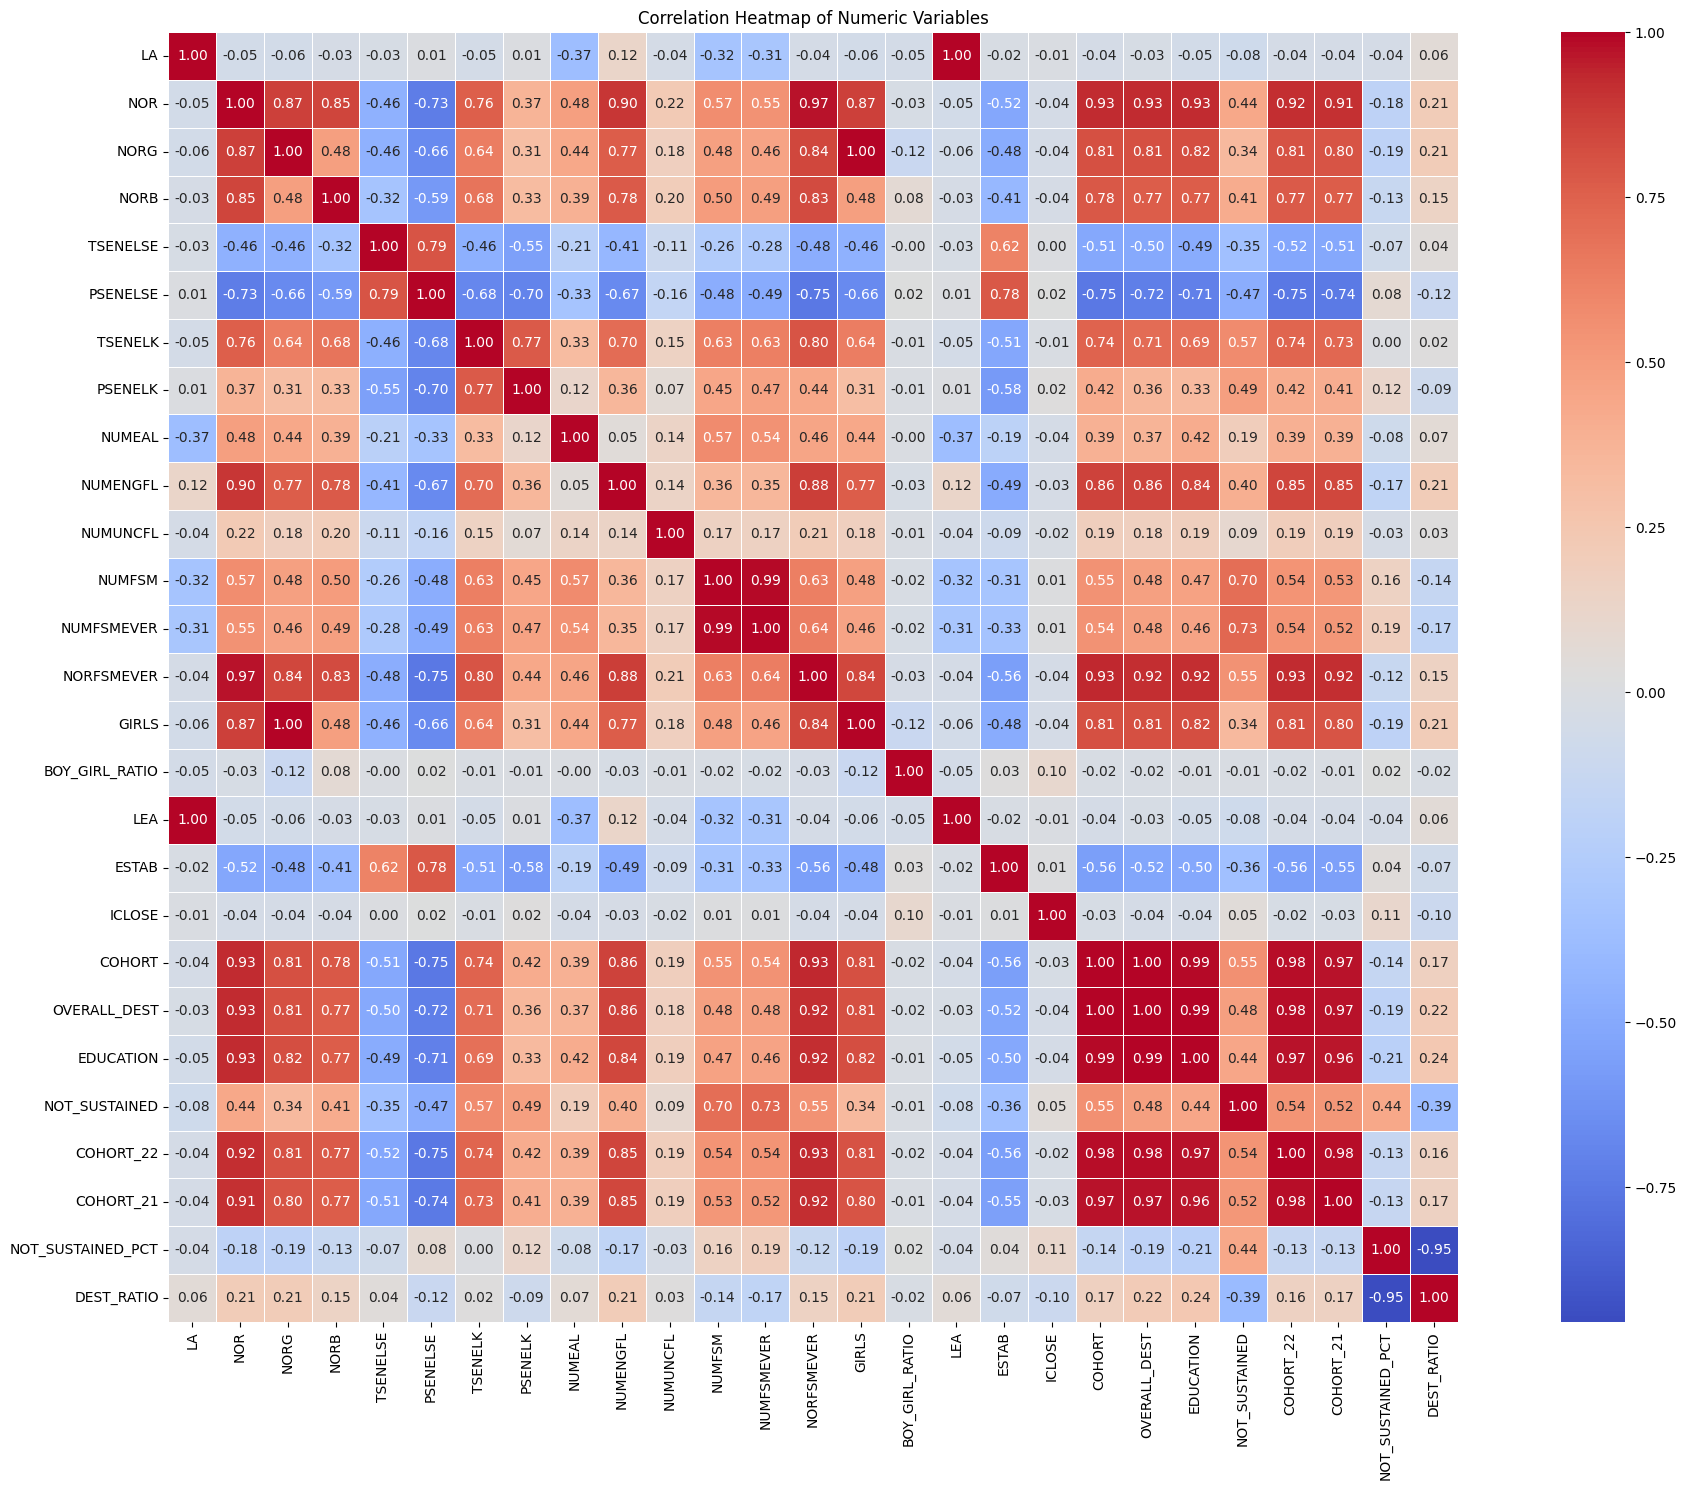

In [ ]:
# Select numeric columns only
numeric_df = merged_df.select_dtypes(include="number")

# Optional: Drop columns with too many NaNs
numeric_df = numeric_df.dropna(axis=1, thresh=int(len(numeric_df) * 0.7))  # keep columns with ≥70% data

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(21, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, square=True)
plt.title("Correlation Heatmap of Numeric Variables")
plt.tight_layout()
plt.show()

This heatmap offers a bird’s-eye view of how numeric variables in the merged dataset relate to one another. At first glance, it confirms several expected relationships. Structural variables like NORG (number of girls), NORB (number of boys), and NOR (total cohort) are tightly correlated, as are count-based deprivation indicators like NUMFSM and NUMFSMEVER, which naturally scale with school size. Likewise, outcome variables such as EDUCATION, OVERALL_DEST, and DEST_RATIO predictably cluster together, reflecting overlapping or derived measures of pupil destinations.

However, the deeper value of this visual is less clear-cut. Many of the strongest correlations simply reflect data design rather than discovery, for instance, that multiple variables are derived from the same totals or are variants of the same concept. Meanwhile, the more conceptually interesting variables, such as BOY_GIRL_RATIO, NOT_SUSTAINED_PCT, or FSM counts, show only weak to moderate correlations with outcome metrics. This doesn’t mean they’re unimportant, but it does suggest that their effects are likely mediated through more complex, non-linear interactions.

This chart reinforces a key idea: while correlation matrices are useful for spotting redundancy and guiding feature reduction, they rarely surface the full complexity of relationships that matter for outcome prediction. Many of the patterns I’ve uncovered elsewhere, like the concentration of risk in small schools, or the structural variability among SEN-heavy settings, are invisible here.

In short, the heatmap provides a helpful structural overview, but its limited explanatory power highlights the need for more nuanced analysis, especially when dealing with interdependent variables and contextual effects that go beyond pairwise relationships.

## 4.7 Data Exploration of all 3 datasets (merged)

This final stage of exploratory analysis brings together the three core datasets Census, Pupdest, and KS4 Results into a single, unified DataFrame using the common URN identifier. This merge marks a pivotal point in the project, transforming previously siloed views into a holistic perspective on each school.

The resulting dataset enables layered, cross-sectional analysis that links:
- School context — characteristics like cohort size, gender balance, SEN and EAL proportions (from Census)
- Post-16 outcomes — such as sustained education or employment, or not sustained destinations (from Pupdest)
- Academic performance — including Progress 8 and Attainment 8 scores (from KS4 Results)

By viewing these dimensions side by side, we can move beyond isolated metrics and begin to explore how school structure and pupil demographics interact with performance and outcomes. This integrated lens not only allows for more robust comparisons between institutions, but also helps uncover underlying inequalities, highlight atypical cases, and generate data-driven hypotheses about what drives success and where the system may be falling short.

This merged dataset forms the analytical foundation for the next phase of work: predictive modelling, fairness assessment, and contextualised interpretation of school performance.

### 4.7.1 SEN % of Pupils in Bottom 50 Schools by Progress 8 Score

/var/folders/lr/k4gd23sn6wxcry0p64dztv0c0000gn/T/ipykernel_63382/2751364637.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/lr/k4gd23sn6wxcry0p64dztv0c0000gn/T/ipykernel_63382/2751364637.py:18: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


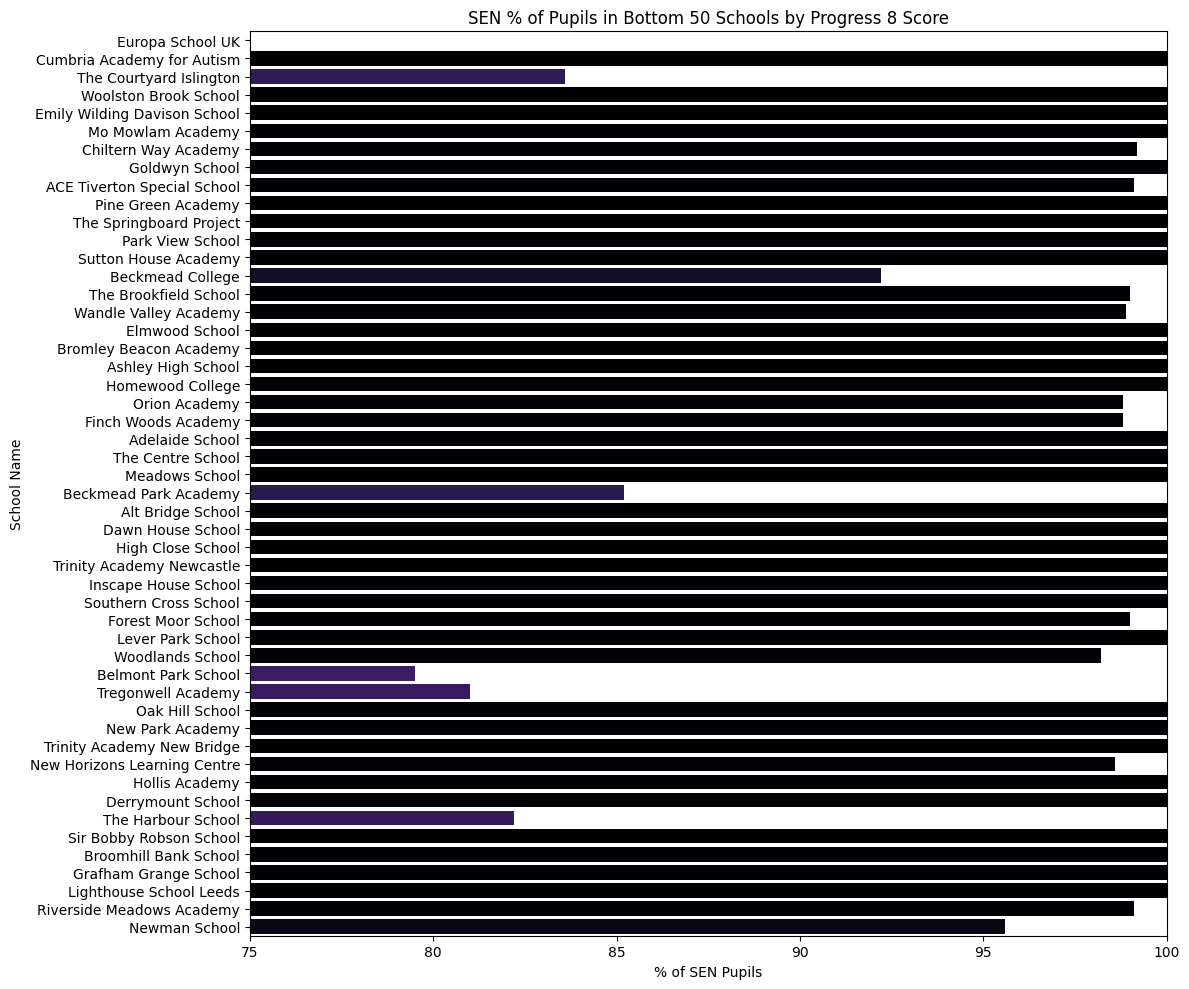

In [ ]:
# Clean Progress 8 and SEN columns
filtered_df = merged_results_df.copy()
filtered_df = filtered_df[filtered_df['P8MEA'] != 'NP']
filtered_df['P8MEA'] = pd.to_numeric(filtered_df['P8MEA'], errors='coerce')

filtered_df = filtered_df[filtered_df['PSENELSE'] != 'NP']
filtered_df['PSENELSE'] = pd.to_numeric(filtered_df['PSENELSE'], errors='coerce')

# Get bottom 50 schools by Progress 8
bottom50 = filtered_df[['SCHNAME_x', 'P8MEA', 'PSENELSE']].sort_values(by='P8MEA', ascending=True).head(50)

# Normalize values from 0 to 1 for color only
color_norm = (bottom50['PSENELSE'] - bottom50['PSENELSE'].min()) / (bottom50['PSENELSE'].max() - bottom50['PSENELSE'].min())
colors = plt.cm.magma_r(color_norm)

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(
    data=bottom50,
    x='PSENELSE',
    y='SCHNAME_x',
    palette=colors
)

plt.title("SEN % of Pupils in Bottom 50 Schools by Progress 8 Score")
plt.xlabel("% of SEN Pupils")
plt.xlim(75, 100)
plt.ylabel("School Name")
plt.tight_layout()
plt.show()

This chart reveals a striking pattern: among the 50 lowest-scoring schools by Progress 8, nearly all serve overwhelmingly high proportions of pupils with Special Educational Needs (SEN), many exceeding 90%. These are not anomalies, but a distinct subset of specialist or alternative provision settings, where traditional academic pathways are often not the primary focus.

Rather than signalling failure, this concentration highlights a deeper issue, the metrics being applied may not be well-suited to the environments they aim to assess. Progress 8 assumes a linear academic journey, but in schools supporting pupils with complex learning, behavioural, or social needs, progress often takes different forms: stability, re-engagement, or personal growth.

The insight here is clear. When schools are evaluated using measures that don’t reflect their mission or student population, there’s a risk of misunderstanding their impact. These results point to a broader question: not just how schools perform, but whether we’re measuring the right things in the right places.

### 4.7.2 Progress 8 Score vs % of Pupils with SEN Support (PSENELSE)

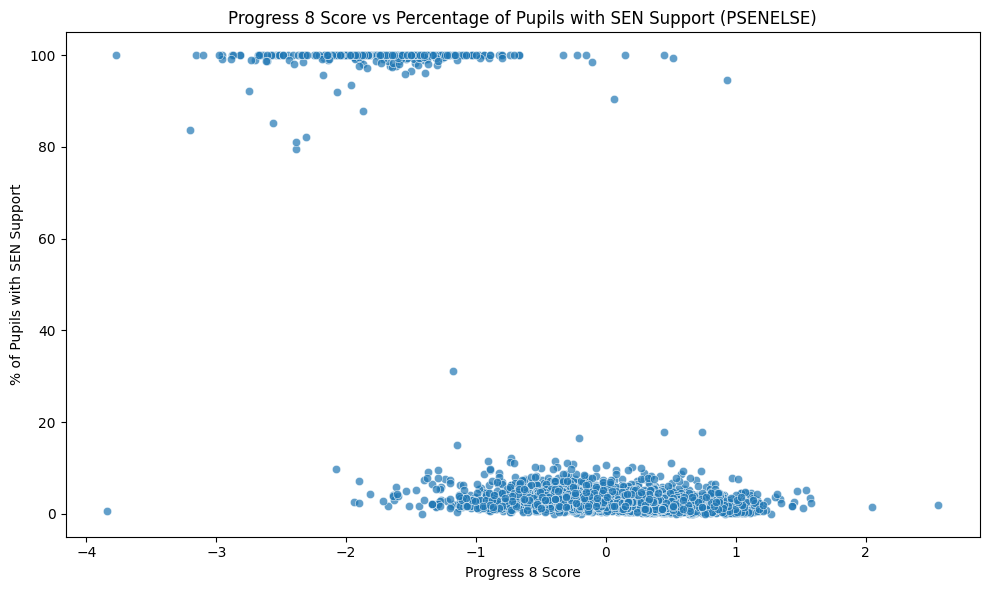

In [ ]:
# Clean and convert data
df = merged_results_df.copy()
df = df[df['P8MEA'] != 'NP']
df['P8MEA'] = pd.to_numeric(df['P8MEA'], errors='coerce')

df = df[df['PSENELSE'] != 'NP']
df['PSENELSE'] = pd.to_numeric(df['PSENELSE'], errors='coerce')

# Drop rows with missing values
df = df.dropna(subset=['P8MEA', 'PSENELSE'])

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='P8MEA', y='PSENELSE', alpha=0.7)
plt.title('Progress 8 Score vs Percentage of Pupils with SEN Support (PSENELSE)')
plt.xlabel('Progress 8 Score')
plt.ylabel('% of Pupils with SEN Support')
plt.tight_layout()
plt.show()

This scatterplot reveals a striking structural divide in the school system based on the percentage of pupils receiving SEN support. Two clearly defined clusters emerge:
- One group of schools clusters tightly around 0–20% SEN, consistent with mainstream provision.
- The other sits near the 100% SEN mark, representing specialist or alternative settings where nearly all pupils require additional support.

These two clusters exhibit very different Progress 8 profiles. The mainstream group displays a fairly typical distribution of scores, with most schools hovering around the national benchmark (0), forming the familiar bell curve expected by design. In contrast, the high-SEN group shows a much broader spread and a more negatively skewed pattern, with many schools falling well below zero.

>🧠 Key Insight:
>
>This plot offers a compelling explanation for the second mode observed in the earlier Progress 8 distribution: it likely originates from this group of high-SEN schools, whose performance profiles diverge significantly from the mainstream.

This visual reinforces a central theme in the analysis: structural context matters. The performance of schools cannot be meaningfully interpreted without recognising the radically different pupil populations they serve. Aggregating these schools into a single accountability model risks obscuring both the challenges they face and the progress they do achieve — even when that progress doesn’t conform neatly to standard metrics.

### 4.7.3 Progress 8 Score vs % of Pupils with SEN Support (Coloured by School Type)

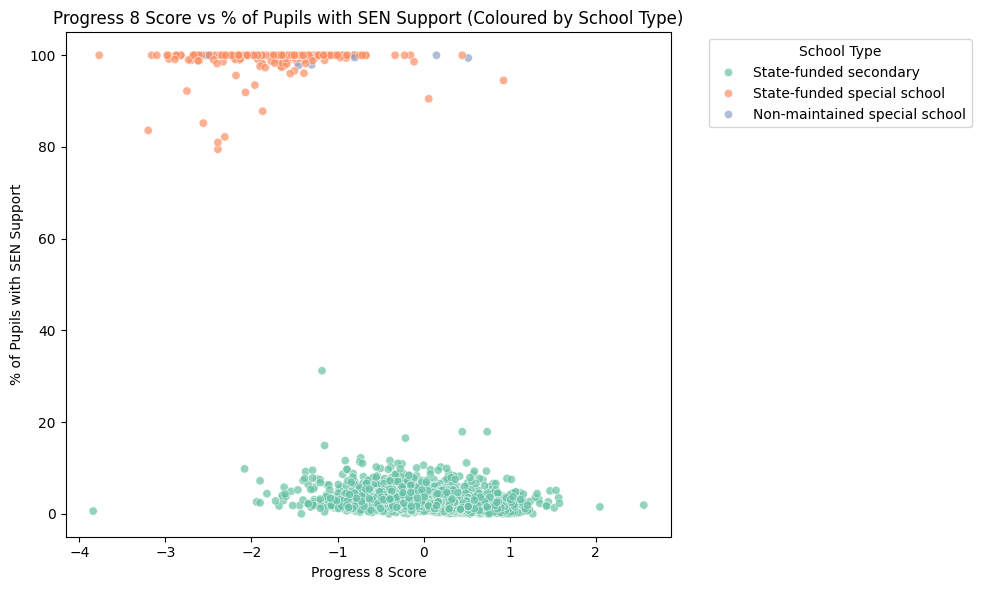

In [ ]:
# Clean and convert data
df = merged_results_df.copy()
df = df[df['P8MEA'] != 'NP']
df['P8MEA'] = pd.to_numeric(df['P8MEA'], errors='coerce')

df = df[df['PSENELSE'] != 'NP']
df['PSENELSE'] = pd.to_numeric(df['PSENELSE'], errors='coerce')

# Drop rows with missing values
df = df.dropna(subset=['P8MEA', 'PSENELSE'])

# Plot with school type hue
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='P8MEA',
    y='PSENELSE',
    hue='SCHOOLTYPE',  # Adjust this if your school type column is named differently
    alpha=0.7,
    palette='Set2'  # You can change palette to 'Set1', 'coolwarm', etc.
)

plt.title('Progress 8 Score vs % of Pupils with SEN Support (Coloured by School Type)')
plt.xlabel('Progress 8 Score')
plt.ylabel('% of Pupils with SEN Support')
plt.legend(title='School Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Building on the earlier scatterplot, I introduced school type as a colour dimension to explore whether the visible clustering in SEN percentages was driven by structural differences in provision.

The result is visually unambiguous:
- The lower cluster (0–20% SEN) consists almost entirely of state-funded secondary schools, the mainstream sector.
- The upper cluster, where SEN percentages approach 100%, is composed almost entirely of state-funded special schools and a smaller number of non-maintained special schools.

This visual confirms the hypothesis: the second “bump” observed in the Progress 8 distribution is not a statistical artefact, it’s a reflection of a fundamentally different type of school being assessed under the same accountability system.

>🧠 Key Insight:
>
>Colouring by school type reveals the structural origin of the second Progress 8 mode, it emerges from the inclusion of special and alternative provision schools, whose pupils, needs, and progress trajectories differ markedly from those in the mainstream.

This adds further weight to a central argument in this analysis: that performance measures like Progress 8 are context-blind by default. Without accounting for school type and intake profile, we risk flattening nuanced institutional differences into misleading comparisons, and potentially punishing the very schools doing the hardest work.

### 4.7.4 Distribution of Progress 8 Scores by SEN Percentage

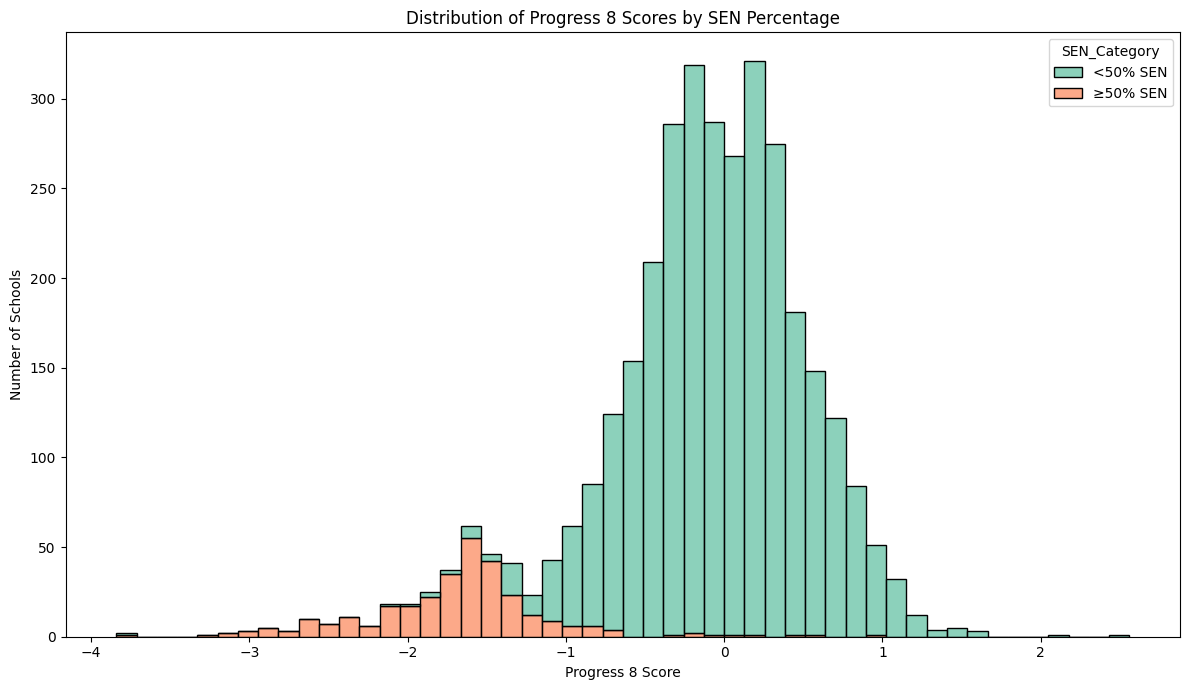

In [165]:
# Copy and clean
df = merged_results_df.copy()
df['P8MEA'] = pd.to_numeric(df['P8MEA'], errors='coerce')
df = df.dropna(subset=['P8MEA'])

# Categorise SEN %
df['SEN_Category'] = np.where(df['PSENELSE'] < 50, '<50% SEN', '≥50% SEN')

# Plot
plt.figure(figsize=(12, 7))
sns.histplot(
    data=df,
    x='P8MEA',
    hue='SEN_Category',
    bins=50,
    multiple='stack',
    edgecolor='black',
    palette='Set2',
    legend=True  # Let seaborn handle it
)

# Titles and labels
plt.title('Distribution of Progress 8 Scores by SEN Percentage')
plt.xlabel('Progress 8 Score')
plt.ylabel('Number of Schools')

# Optional: explicitly set title if needed
# plt.legend(title='SEN Category')  ← use only if seaborn doesn’t do it automatically

plt.tight_layout()
plt.show()

Graph 4.4.2 previously revealed that while Progress 8 scores across schools roughly followed a normal distribution, there was a noticeable anomaly: a secondary “bump” emerging in the lower tail, particularly around scores from -3 to -1. At the time, this deviation hinted at a possible underlying structural factor but required further investigation.

This stacked histogram, grouped by SEN concentration, makes that pattern clearer. It shows:
- Schools with ≥50% of pupils receiving SEN support disproportionately populate the lowest end of the Progress 8 distribution.
- Meanwhile, schools with <50% SEN form the bulk of the central and right-hand side of the distribution, more closely aligned with the expected bell curve.

>🧠 Key Insight:
>
>The deviation from normality observed earlier is not noise, it reflects a systematic structural difference. The presence of high-SEN schools skews the overall distribution, pulling the mean downward and introducing a second peak that wouldn’t otherwise exist in a mainstream-only dataset.

This has critical implications for interpreting national-level Progress 8 data. The assumption of normality, often baked into accountability and policy decisions, begins to unravel when structural outliers like high-SEN schools are included without adjustment. Recognising and disaggregating these subgroups is essential for fair and accurate interpretation of school performance.

### 4.7.5 FSM Eligibility Among England’s Lowest Performing Schools

/var/folders/lr/k4gd23sn6wxcry0p64dztv0c0000gn/T/ipykernel_63382/1856264798.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/lr/k4gd23sn6wxcry0p64dztv0c0000gn/T/ipykernel_63382/1856264798.py:26: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


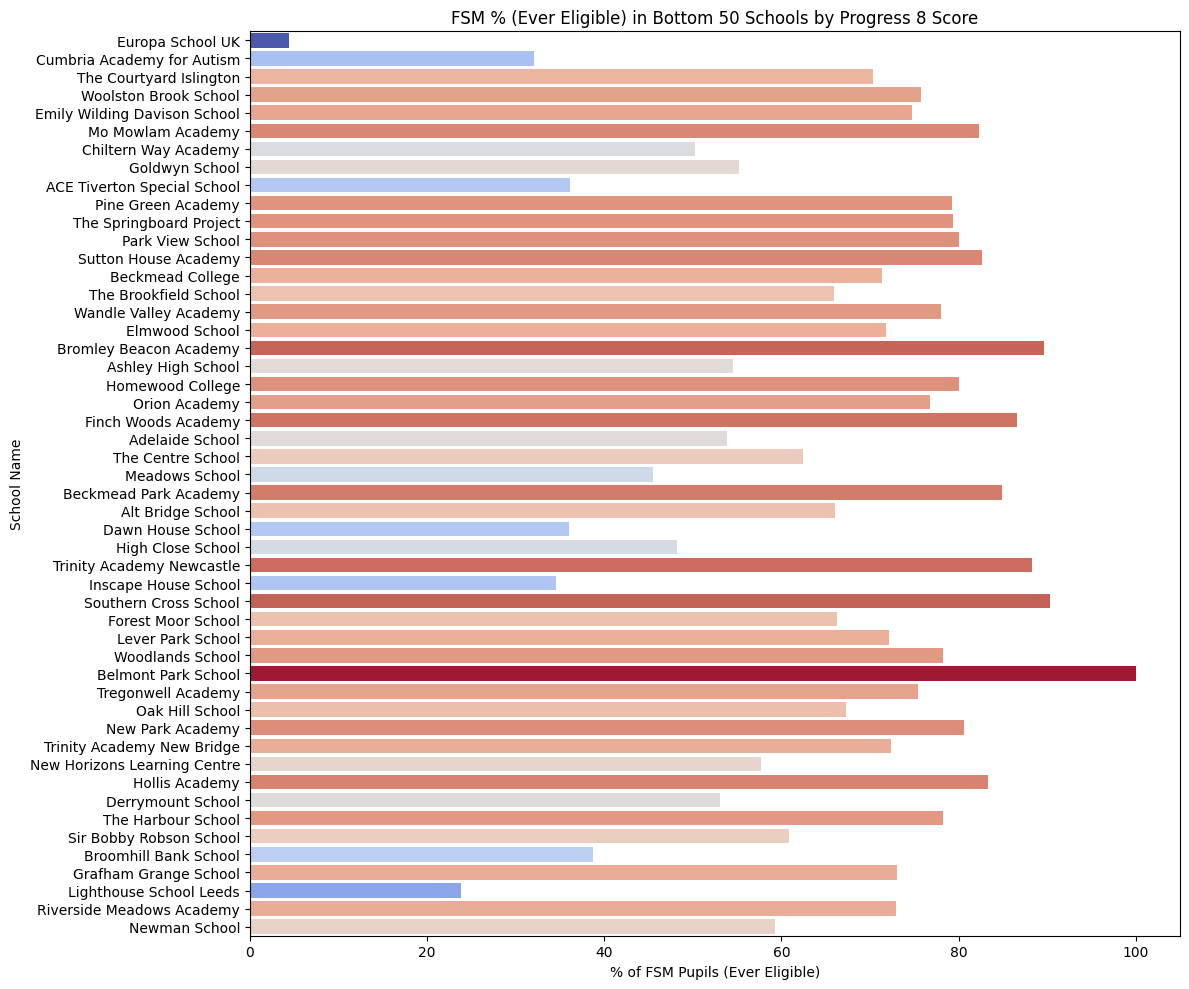

In [168]:
# Clean Progress 8 and FSM6CLA columns
filtered_df = merged_results_df.copy()
filtered_df = filtered_df[filtered_df['P8MEA'] != 'NP']
filtered_df['P8MEA'] = pd.to_numeric(filtered_df['P8MEA'], errors='coerce')

filtered_df['PNUMFSMEVER'] = (
    filtered_df['PNUMFSMEVER']
    .astype(str)
    .str.replace('%', '', regex=False)
    .replace(['NP', 'SUPP'], pd.NA)
    .astype(float)
)

# Get bottom 50 schools by Progress 8
bottom50 = filtered_df[['SCHNAME_x', 'P8MEA', 'PNUMFSMEVER']].dropna().sort_values(by='P8MEA', ascending=True).head(50)

# Normalize NUMFSMEVER values for coloring
norm = plt.Normalize(bottom50['PNUMFSMEVER'].min(), bottom50['PNUMFSMEVER'].max())
colors = plt.cm.coolwarm(norm(bottom50['PNUMFSMEVER']))
# Normalize PNUMFSMEVER for coloring
norm = plt.Normalize(bottom50['PNUMFSMEVER'].min(), bottom50['PNUMFSMEVER'].max())
colors = plt.cm.coolwarm(norm(bottom50['PNUMFSMEVER']))

# Plot with color mapped to PNUMFSMEVER
plt.figure(figsize=(12, 10))
sns.barplot(
    data=bottom50,
    x='PNUMFSMEVER',
    y='SCHNAME_x',
    palette=colors
)

plt.title("FSM % (Ever Eligible) in Bottom 50 Schools by Progress 8 Score")
plt.xlabel("% of FSM Pupils (Ever Eligible)")
plt.ylabel("School Name")
plt.tight_layout()
plt.show()

This bar chart visualises the percentage of pupils ever eligible for Free School Meals (FSM) in the 50 schools with the lowest Progress 8 scores. A clear and sobering trend emerges: most of these schools serve highly disadvantaged populations, with FSM eligibility rates frequently exceeding 70% and some approaching 100%.

While this strongly reinforces the known link between socioeconomic disadvantage and lower academic progress, the visual also tells a more nuanced story. A handful of schools appear in this bottom group despite lower FSM rates, suggesting that disadvantage is multifaceted. In these cases, other structural challenges—such as high proportions of pupils with Special Educational Needs (SEN) or alternative provision status—may be at play.

### 4.7.6 Free School Meal Eligibility vs Progress 8 Score (All Schools)

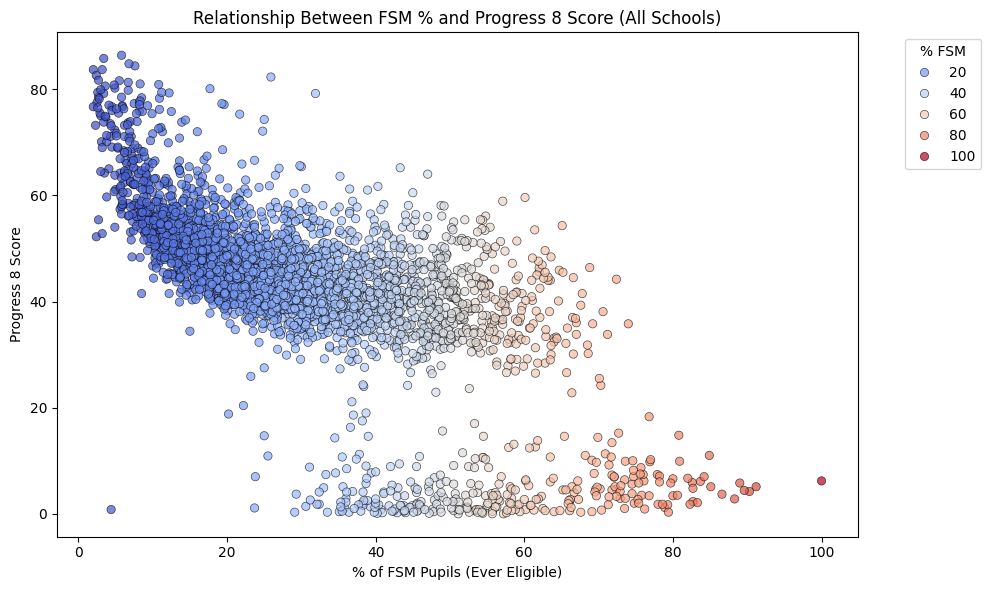

In [ ]:
# Clean a fresh copy of the data
scatter_df = merged_results_df.copy()
scatter_df = scatter_df[scatter_df['ATT8SCR'] != 'NP']
scatter_df['ATT8SCR'] = pd.to_numeric(scatter_df['ATT8SCR'], errors='coerce')

scatter_df['PNUMFSMEVER'] = (
    scatter_df['PNUMFSMEVER']
    .astype(str)
    .str.replace('%', '', regex=False)
    .replace(['NP', 'SUPP'], pd.NA)
    .astype(float)
)

# Drop rows with missing values in relevant columns
scatter_df = scatter_df.dropna(subset=['PNUMFSMEVER', 'ATT8SCR'])

# Plot the scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=scatter_df,
    x='PNUMFSMEVER',
    y='ATT8SCR',
    hue='PNUMFSMEVER',  # Optional: color points by FSM %
    palette='coolwarm',
    edgecolor='black',
    alpha=0.7
)

plt.title("Relationship Between FSM % and Progress 8 Score (All Schools)")
plt.xlabel("% of FSM Pupils (Ever Eligible)")
plt.ylabel("Progress 8 Score")
plt.legend(title='% FSM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This scatterplot explores how socioeconomic context, measured by the percentage of pupils ever eligible for Free School Meals (FSM), relates to school performance on the Progress 8 measure. The downward slope in the data is striking — as FSM percentages increase, Progress 8 scores tend to decrease.

Schools with lower levels of disadvantage (toward the left of the plot) are tightly clustered at the higher end of Progress 8 scores, while those with high FSM rates (toward the right) are far more likely to be concentrated at the lower end of the performance spectrum. The colour gradient reinforces this pattern, visually marking a socioeconomic divide in pupil outcomes.

Although some exceptions exist, with a handful of high-FSM schools achieving strong progress, the overall trend underscores the persistent link between deprivation and underperformance, a structural challenge faced by many schools across England.

### 4.7.7 Identifying At-Risk Schools by FSM % and Progress 8 Score

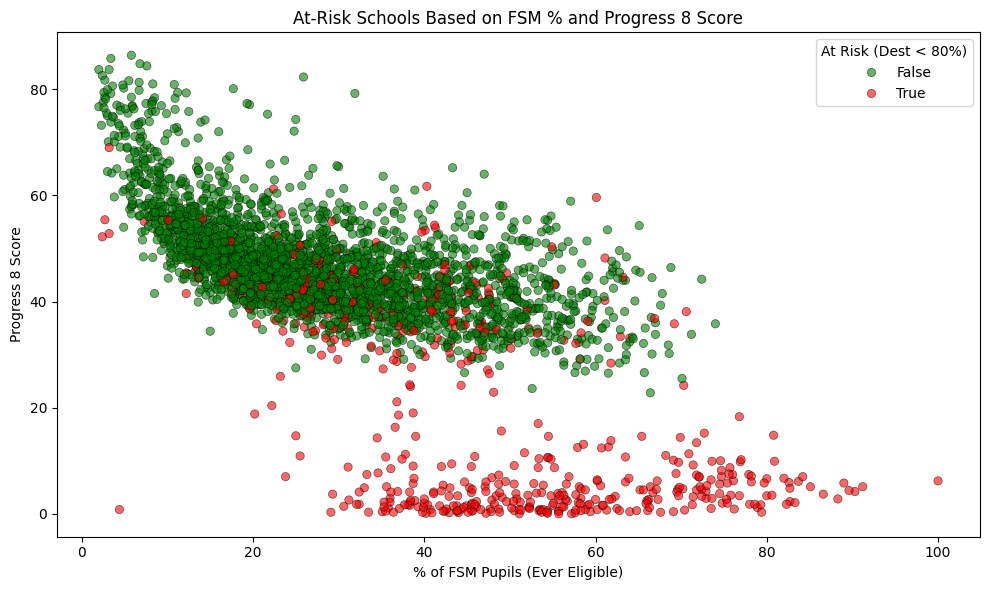

In [ ]:
# Clean a fresh copy of the data
scatter_df = merged_results_df.copy()

# Clean P8MEA
scatter_df = scatter_df[scatter_df['ATT8SCR'] != 'NP']
scatter_df['ATT8SCR'] = pd.to_numeric(scatter_df['ATT8SCR'], errors='coerce')

# Clean FSM percentage column
scatter_df['PNUMFSMEVER'] = pd.to_numeric(
    scatter_df['PNUMFSMEVER']
    .astype(str)
    .str.replace('%', '', regex=False)
    .replace(['NP', 'SUPP'], pd.NA),
    errors='coerce'
)

# Clean OVERALL_DEST
scatter_df['OVERALL_DEST'] = pd.to_numeric(
    scatter_df['OVERALL_DEST']
    .astype(str)
    .str.replace('%', '', regex=False)
    .replace(['NP', 'SUPP'], pd.NA),
    errors='coerce'
)

# Drop rows with missing values
scatter_df = scatter_df.dropna(subset=['PNUMFSMEVER', 'ATT8SCR', 'OVERALL_DEST'])

# Define "At Risk" schools: those with low destination outcomes
scatter_df['AT_RISK'] = scatter_df['OVERALL_DEST'] < 80

# Plot scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=scatter_df,
    x='PNUMFSMEVER',
    y='ATT8SCR',
    hue='AT_RISK',
    palette={True: 'red', False: 'green'},
    edgecolor='black',
    alpha=0.6
)

plt.title("At-Risk Schools Based on FSM % and Progress 8 Score")
plt.xlabel("% of FSM Pupils (Ever Eligible)")
plt.ylabel("Progress 8 Score")
plt.legend(title='At Risk (Dest < 80%)', loc='upper right')
plt.tight_layout()
plt.show()

Building on the previous visual, this chart adds another dimension: post-16 destination success. By classifying schools with fewer than 80% of pupils in sustained destinations (education or employment) as “at risk”, we can now see how multiple vulnerabilities intersect.

The red dots, which denote at-risk schools, tend to cluster in the same quadrant highlighted earlier — those with both high FSM eligibility and low Progress 8 scores. This reinforces the idea that deprivation not only affects academic progress but also longer-term outcomes. The overlap between academic underperformance and weak destinations creates a more complete picture of risk.

This view illustrates that some schools are facing multiple, compounding challenges, and a single indicator like Progress 8 or FSM rate alone may understate the complexity. By visualising risk in this layered way, we move closer to identifying where systemic support and intervention may be most urgently needed.

# 5. Prediction Models

Having explored the complex interplay between school characteristics and pupil outcomes, this section shifts focus from descriptive to predictive analysis. The aim is to move beyond pattern recognition and towards forecasting to determine which school-level factors most reliably predict post-16 destination success.

The modelling process begins with a return to the cleaned, merged dataset combining census, results, and destination information. After handling missing values and engineering new contextual features (e.g. gender imbalance, SEN-FSM interaction), the dataset is ready for machine learning workflows.

This section will:
- Establish a robust modelling pipeline, including preprocessing for numeric and categorical features.
- Train multiple regression models, from linear baselines to tree-based ensembles and boosting methods.
- Evaluate performance using cross-validated RMSE and R² to identify the best predictive approach.
- Lay the groundwork for model explainability, helping to surface the drivers behind low destination outcomes.

By doing so, this phase of the analysis translates earlier insights into actionable predictions supporting a data-driven understanding of where risk lies and where targeted support might be most needed.

## 5.1 Data Loading and Null Inspection

To ensure a clean and controlled environment for the modelling phase, the datasets are reloaded directly from disk. This step deliberately isolates the Prediction Models section from any transformations, filtering, or exploratory changes made earlier in the analysis.

By working from the original, unaltered inputs, we maintain data integrity, avoid any unintended bias introduced during exploration, and ensure that the modelling process remains fully reproducible. This clean reload establishes a consistent starting point for feature engineering, preprocessing, and model evaluation.

### 5.1.1 Load Datasets

In [ ]:
census_df = pd.read_csv('Data/england_census.csv')
pupdest_df = pd.read_csv('Data/england_ks4-pupdest.csv')
results_df = pd.read_csv('Data/england_ks4final.csv')

### 5.1.2 Standardise Missing Data

In [ ]:
null_placeholders = ['SUPP', 'NP', 'NA', 'RE']
for placeholder in null_placeholders:
    census_df.replace(placeholder, np.nan, inplace=True)
    pupdest_df.replace(placeholder, np.nan, inplace=True)
    results_df.replace(placeholder, np.nan, inplace=True)

### 5.1.3 Visualise Missing Data

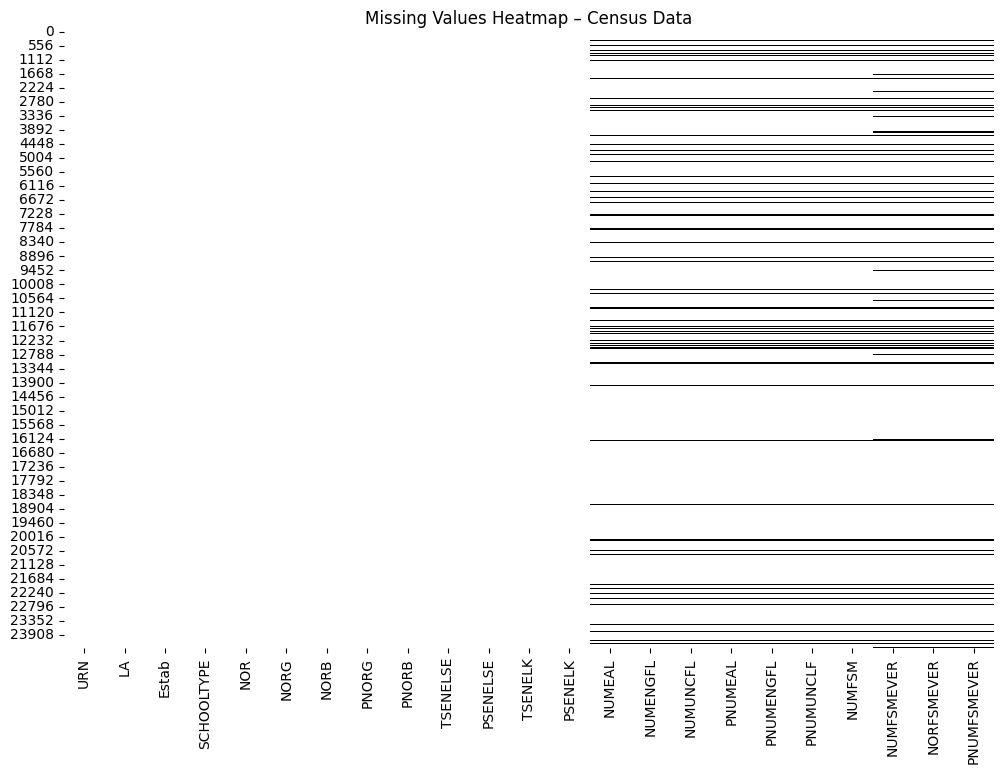

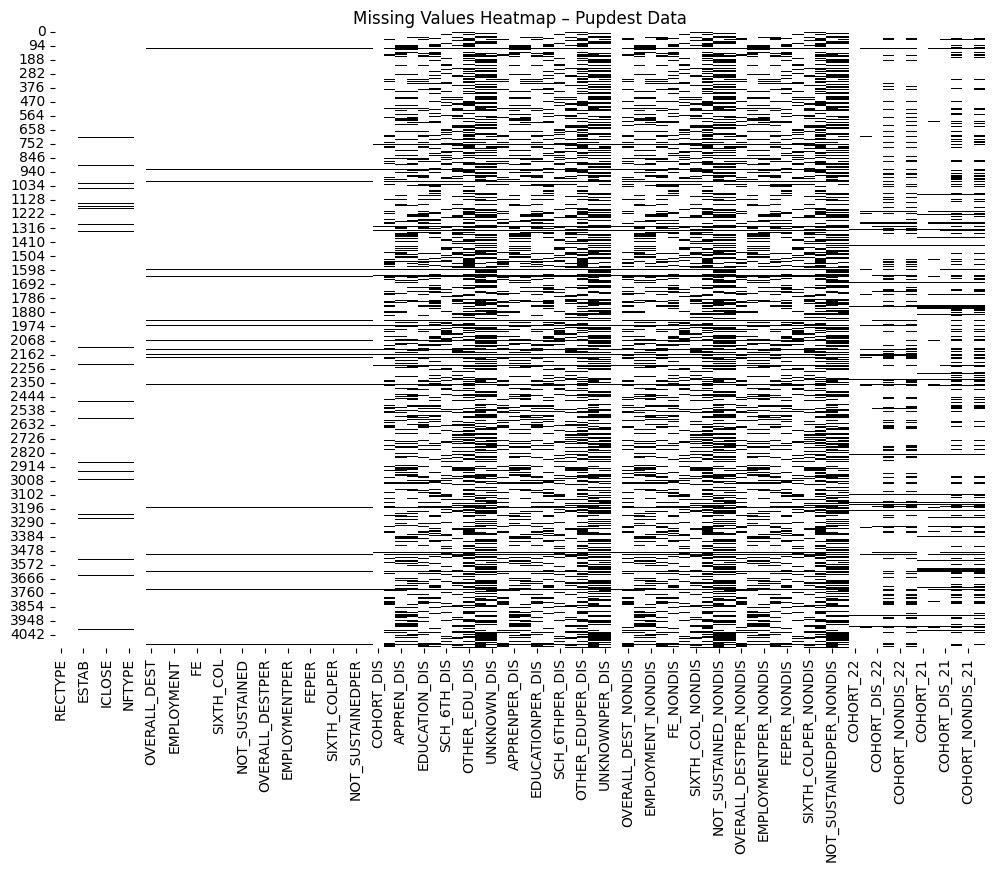

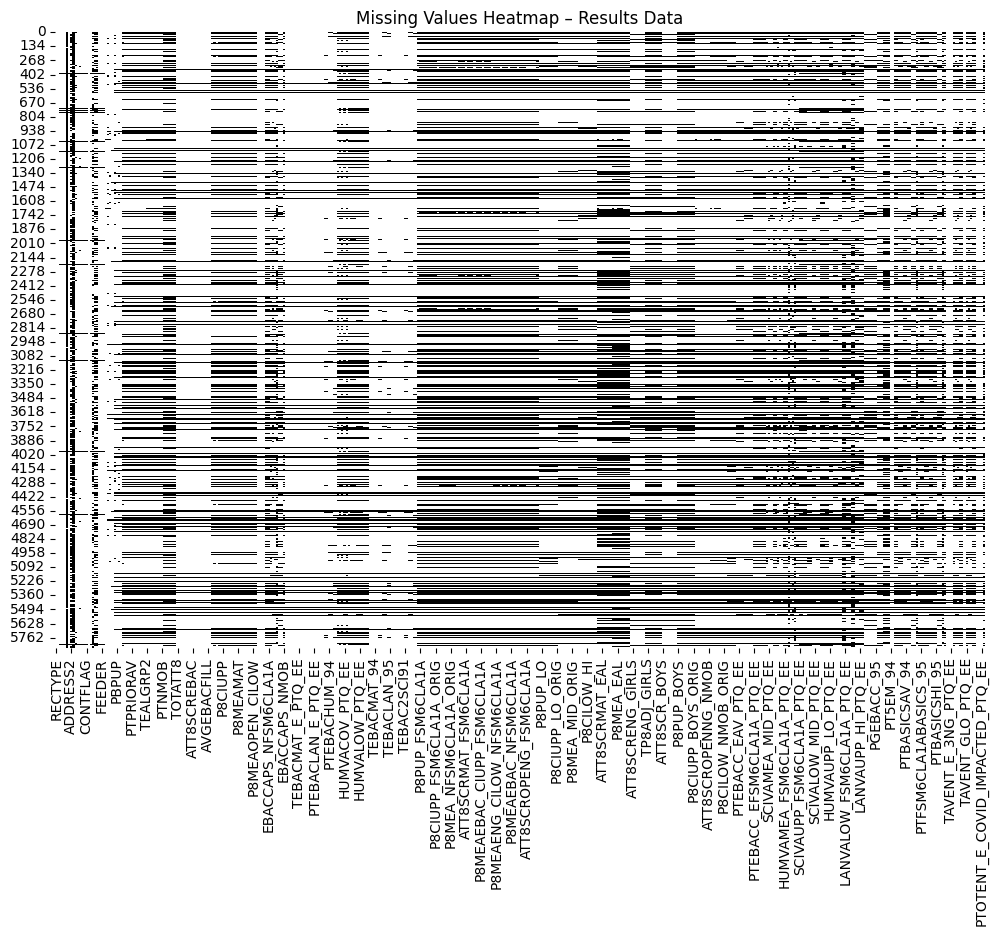

In [ ]:
data_frames = {
    'Census Data': census_df,
    'Pupdest Data': pupdest_df,
    'Results Data': results_df
}

for name, df in data_frames.items():
    # Create a DataFrame where NaNs are 1 and everything else is 0
    data_for_heatmap = df.isnull().astype(int)

    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(data_for_heatmap, cbar=False, cmap='binary')
    plt.title(f'Missing Values Heatmap – {name}')
    plt.show()

## 5.2 Joining Datasets

### 5.2.1 Identifier Type Conversion

In [ ]:
# List your datasets
datasets = [census_df, results_df, pupdest_df]
# Loop through and clean URNs properly

for i in range(len(datasets)):
    datasets[i] = datasets[i].copy()                                            # Make sure it's not a view
    datasets[i]['URN'] = datasets[i]['URN'].astype(str)                         # Ensure string
    datasets[i]['URN'] = datasets[i]['URN'].str.replace('.0', '', regex=False)  # Remove .0 if there
    datasets[i]['URN'] = datasets[i]['URN'].str.strip()                         # Remove spaces
    datasets[i] = datasets[i][datasets[i]['URN'].str.isnumeric()]               # Keep only rows where URN is numeric
    datasets[i].loc[:, 'URN'] = datasets[i]['URN'].astype(int)                  # Now safe to convert

#double reassign to force conversion (not really needed)
census_df, results_df, pupdest_df = datasets

### 5.2.2 Merging of data

In [ ]:
# Now merge
pre_merged_df = pd.merge(census_df, pupdest_df, on='URN', how='inner')
merged_df = pd.merge(pre_merged_df, results_df, on='URN', how='inner')
merged_df.shape


(3946, 532)

In [ ]:
# Merge as you were doing
# merged_df = pd.merge(census_df, results_df, on='URN', how='inner')
# merged_df = pd.merge(merged_df, pupdest_df, on='URN', how='inner')

# Now fix duplicate columns (_x and _y)

# List of columns you want to keep from census_df version
columns_to_keep = ['RECTYPE_x', 'LEA_x', 'ICLOSE_x', 'NFTYPE_x']

# Drop the '_y' versions (coming from results_df or pupdest_df)
merged_df = merged_df.drop(columns=[col for col in merged_df.columns if col.endswith('_y')])

# Rename the kept '_x' columns back to original names
merged_df = merged_df.rename(columns={
    'RECTYPE_x': 'RECTYPE',
    'LEA_x': 'LEA',
    'ICLOSE_x': 'ICLOSE',
    'NFTYPE_x': 'NFTYPE'
})

## 5.3 Data Cleaning

Before modelling, essential data cleaning steps are performed to ensure that inputs are in a usable, consistent format. This includes standardising numeric fields, handling missing or suppressed values, and calculating key derived features. Careful preparation at this stage improves model reliability and minimises potential biases introduced by inconsistent data structures.

### 5.3.1 Column Extraction

To enhance the predictive power of the dataset, two new derived features are introduced:
- RISK_RATIO: the proportion of pupils not sustaining destinations relative to those staying in education, providing a measure of relative dropout risk.
- SUS_per: the proportion of the cohort that successfully sustains education, which is used as the primary target variable for modelling.

Additionally, a focused set of columns is retained, prioritising core school characteristics and outcome measures while excluding redundant percentage columns where integer counts are already available. This careful feature selection aims to streamline the modelling process without losing meaningful information.

In [ ]:
# Ensure numeric types
merged_df["NOT_SUSTAINED"] = pd.to_numeric(merged_df["NOT_SUSTAINED"], errors="coerce")
merged_df["EDUCATION"] = pd.to_numeric(merged_df["EDUCATION"], errors="coerce")

# Calculate risk ratio
merged_df["RISK_RATIO"] = merged_df["NOT_SUSTAINED"] / merged_df["EDUCATION"].replace(0, pd.NA)
merged_df["SUS_per"] = merged_df["EDUCATION"] / merged_df["COHORT"].replace(0, pd.NA)
# Keep the columns i want, not keeping columns such as % columns where the Integer value has been provided
cols_keep = [
    "LA", "Estab", "SCHOOLTYPE", 
    "NOR", "PNORG", "PNORB",
    "PSENELSE", "PSENELK", 
    "PNUMEAL", "PNUMENGFL", "PNUMENGFL",
    "PNUMFSMEVER",
    "RECTYPE", "ICLOSE", "NFTYPE",
    "KS2ASS", "ATT8SCR", "TAVENT_G_PTQ_EE", 'SUS_per'
]
# Target Variable
cols_target = ["SUS_per"]

| Column | Dataset | Keep Reason |
|:---|:---|:---|
| LA | census_df | Local authority code — useful for regional analysis or grouping schools geographically. |
| Estab | census_df | Establishment number — used alongside LA to create a unique school ID (LAESTAB). |
| SCHOOLTYPE | census_df | School type (e.g., secondary, special) — important contextual factor for outcomes and comparison. |
| NOR | census_df | Number on roll (total pupils) — critical indicator of school size and potential institutional capacity. |
| PNORG | census_df | Percentage of girls — provides a normalized measure of gender balance within the school. |
| PNORB | census_df | Percentage of boys — complements PNORG, offering a complete gender profile. |
| PSENELSE | census_df | Percentage of pupils receiving SEN support — key measure for understanding additional support needs across schools. |
| PSENELK | census_df | Percentage of pupils with an EHCP (Education, Health, and Care Plan) — captures severity of SEN need. |
| PNUMEAL | census_df | Percentage of pupils with English as an Additional Language (EAL) — proxy for linguistic diversity and integration challenges. |
| PNUMENGFL | census_df | Percentage of pupils whose first language is English — contextual balance against EAL pupils. |
| PNUMENGFL | census_df | Percentage of pupils with unknown first language — useful for assessing data completeness and reporting quality. |
| PNUMFSMEVER | census_df | Percentage of pupils ever eligible for Free School Meals — strong proxy for long-term socioeconomic disadvantage. |
| RECTYPE | census_df | Record type — assists in filtering datasets for active, closed, or special case schools. |
| ICLOSE | census_df | Indicator for whether the school has closed — important for cleaning and filtering active datasets. |
| NFTYPE | census_df | National funding type — reflects school governance and potential funding differences (e.g., academies vs maintained schools). |
| KS2ASS | results_df | Key Stage 2 average prior attainment — an essential baseline control variable for progress-based measures. |
| ATT8SCR | results_df | Attainment 8 score — broad measure of pupil achievement across core and additional subjects. |
| TAVENT_G_PTQ_EE | pupdest_df | Progression to education, employment, or training — critical indicator of post-16 success. |
| SUS_per | derived | Proportion of the cohort successfully sustaining education — main target variable for predictive modelling. |


The results_df dataset contains performance measures such as Progress 8 and Attainment 8 scores, but it is inherently narrower in scope compared to the census or destination datasets. It focuses primarily on academic outcomes at Key Stage 4 and includes only a limited number of summary indicators. As a result, while critical for understanding attainment, results_df offers fewer variables overall and is primarily used to complement the richer contextual information available in the other datasets.


### 5.3.2 Changing Data types

Before modelling, it is crucial to ensure that all features are in appropriate formats for analysis. Many important variables were initially stored as text, often including formatting artifacts like percentage signs. In this step, key columns are cleaned and converted into numeric types where necessary. This standardisation allows later stages, such as scaling and regression, to process the data correctly and ensures that no hidden formatting errors compromise model performance.

#### 5.3.2.1 Column Data Type Identification

In [ ]:
old_data = merged_df[cols_keep].dtypes.to_frame('dtype')
old_data

dtype
LA               float64
Estab             object
SCHOOLTYPE        object
NOR                int64
PNORG             object
PNORB             object
PSENELSE          object
PSENELK           object
PNUMEAL           object
PNUMENGFL         object
PNUMENGFL         object
PNUMFSMEVER       object
RECTYPE           object
ICLOSE           float64
NFTYPE            object
KS2ASS            object
ATT8SCR           object
TAVENT_G_PTQ_EE   object
SUS_per          float64

#### 5.3.2.2 Conversion of % Columns

In [ ]:
# List of columns that are percentages stored as strings
percent_cols = ['PNORG', 'PNORB', 'PSENELSE', 'PSENELK', 'PNUMEAL', 'PNUMENGFL', 'PNUMENGFL', 'PNUMFSMEVER']

# Clean them: remove '%' and convert to float
for col in percent_cols:
    if merged_df[col].dtype == 'object':  # Only fix if column is object (string)
        merged_df[col] = merged_df[col].str.replace('%', '').astype(float)

In [ ]:
new_data = merged_df[cols_keep].dtypes.to_frame('dtype')
new_data

dtype
LA               float64
Estab             object
SCHOOLTYPE        object
NOR                int64
PNORG            float64
PNORB            float64
PSENELSE         float64
PSENELK          float64
PNUMEAL          float64
PNUMENGFL        float64
PNUMENGFL        float64
PNUMFSMEVER      float64
RECTYPE           object
ICLOSE           float64
NFTYPE            object
KS2ASS            object
ATT8SCR           object
TAVENT_G_PTQ_EE   object
SUS_per          float64

In [ ]:
# Combine two DataFrames side-by-side
def side_by_side(*dfs, titles=()):
    html_str = ''
    for i, df in enumerate(dfs):
        title = titles[i] if i < len(titles) else ''
        html_str += f'<div style="display:inline-block; padding:10px;">'
        html_str += f'<h3>{title}</h3>'
        html_str += df.to_html()
        html_str += '</div>'
    display_html(html_str, raw=True)

# Example use
side_by_side(old_data, new_data, titles=['Old Data', 'New Data'])

Old Data 
 
 
 
 dtype 
 
 
 
 
 LA 
 float64 
 
 
 Estab 
 object 
 
 
 SCHOOLTYPE 
 object 
 
 
 NOR 
 int64 
 
 
 PNORG 
 object 
 
 
 PNORB 
 object 
 
 
 PSENELSE 
 object 
 
 
 PSENELK 
 object 
 
 
 PNUMEAL 
 object 
 
 
 PNUMENGFL 
 object 
 
 
 PNUMENGFL 
 object 
 
 
 PNUMFSMEVER 
 object 
 
 
 RECTYPE 
 object 
 
 
 ICLOSE 
 float64 
 
 
 NFTYPE 
 object 
 
 
 KS2ASS 
 object 
 
 
 ATT8SCR 
 object 
 
 
 TAVENT_G_PTQ_EE 
 object 
 
 
 SUS_per 
 float64 
 
 
 New Data 
 
 
 
 dtype 
 
 
 
 
 LA 
 float64 
 
 
 Estab 
 object 
 
 
 SCHOOLTYPE 
 object 
 
 
 NOR 
 int64 
 
 
 PNORG 
 float64 
 
 
 PNORB 
 float64 
 
 
 PSENELSE 
 float64 
 
 
 PSENELK 
 float64 
 
 
 PNUMEAL 
 float64 
 
 
 PNUMENGFL 
 float64 
 
 
 PNUMENGFL 
 float64 
 
 
 PNUMFSMEVER 
 float64 
 
 
 RECTYPE 
 object 
 
 
 ICLOSE 
 float64 
 
 
 NFTYPE 
 object 
 
 
 KS2ASS 
 object 
 
 
 ATT8SCR 
 object 
 
 
 TAVENT_G_PTQ_EE 
 object 
 
 
 SUS_per 
 float64

### 5.3.3 Feature Categorisation

To prepare the dataset for modelling, features are first separated into numeric and categorical groups based on their data types. This distinction is important for preprocessing, as numeric features will require scaling, while categorical features will be one-hot encoded. Automating this classification ensures that the transformation pipeline can handle each variable correctly and consistently.

#### 5.3.3.1 Split Features by Data Type

In [ ]:
cutdown_merged_df = merged_df[cols_keep]

numeric_features = cutdown_merged_df.select_dtypes(include=["number"]).columns.tolist()
categorical_features = cutdown_merged_df.select_dtypes(include=["object"]).columns.tolist()

print(numeric_features)
print(categorical_features)

['LA', 'NOR', 'PNORG', 'PNORB', 'PSENELSE', 'PSENELK', 'PNUMEAL', 'PNUMENGFL', 'PNUMENGFL', 'PNUMFSMEVER', 'ICLOSE', 'SUS_per']
['Estab', 'SCHOOLTYPE', 'RECTYPE', 'NFTYPE', 'KS2ASS', 'ATT8SCR', 'TAVENT_G_PTQ_EE']


In [ ]:
merged_df[cols_keep].head()

LA Estab              SCHOOLTYPE   NOR  PNORG  PNORB  PSENELSE  PSENELK  \
0  202.0  4104  State-funded secondary   973   43.1   56.9       3.6     19.1   
1  202.0  4166  State-funded secondary  1218   94.6    5.4       1.9     14.9   
2  202.0  4196  State-funded secondary  1076   43.5   56.5       4.1     16.7   
3  202.0  4275  State-funded secondary  1287   49.6   50.4       2.7     12.0   
4  202.0  4285  State-funded secondary  1166   35.2   64.8       6.7     16.0   

   PNUMEAL  PNUMENGFL  PNUMENGFL  PNUMFSMEVER RECTYPE  ICLOSE NFTYPE KS2ASS  \
0     52.1       46.9       46.9         72.4       1     0.0     CY    104   
1     32.5       66.9       66.9         36.9       1     0.0     CY  107.4   
2     59.0       41.0       41.0         66.6       1     0.0     CY  104.5   
3     33.1       66.9       66.9         50.8       1     0.0     CY    104   
4     22.6       67.0       67.0         40.4       1     0.0     CY  107.2   

  ATT8SCR TAVENT_G_PTQ_EE   SUS_per  
0    44.2             6.1  0.945312  
1    58.9             8.1  0.962963  
2    44.5             7.7  0.942529  
3    41.2             6.7  0.953368  
4    50.4             7.5  0.920245

#### 5.3.3.2 Swapping Misaligned Columns

In [ ]:
# Loop through each item
for col in ['LA', 'ICLOSE', 'SUS_per']:
    if col in numeric_features:
        numeric_features.remove(col)
numeric_features

['NOR',
 'PNORG',
 'PNORB',
 'PSENELSE',
 'PSENELK',
 'PNUMEAL',
 'PNUMENGFL',
 'PNUMENGFL',
 'PNUMFSMEVER']

In [ ]:
merged_df[numeric_features].dtypes.to_frame('dtype')

dtype
NOR            int64
PNORG        float64
PNORB        float64
PSENELSE     float64
PSENELK      float64
PNUMEAL      float64
PNUMENGFL    float64
PNUMENGFL    float64
PNUMFSMEVER  float64

In [ ]:
for col in ['LA', 'ICLOSE']:
    categorical_features.append(col)
categorical_features

['Estab',
 'SCHOOLTYPE',
 'RECTYPE',
 'NFTYPE',
 'KS2ASS',
 'ATT8SCR',
 'TAVENT_G_PTQ_EE',
 'LA',
 'ICLOSE']

In [ ]:
merged_df[categorical_features].dtypes.to_frame('dtype')

dtype
Estab             object
SCHOOLTYPE        object
RECTYPE           object
NFTYPE            object
KS2ASS            object
ATT8SCR           object
TAVENT_G_PTQ_EE   object
LA               float64
ICLOSE           float64

In [ ]:
for col in ['KS2ASS', 'ATT8SCR', 'TAVENT_G_PTQ_EE', 'RISK_RATIO']:
    if col in categorical_features:
        categorical_features.remove(col)
categorical_features

['Estab', 'SCHOOLTYPE', 'RECTYPE', 'NFTYPE', 'LA', 'ICLOSE']

In [ ]:
for col in ['KS2ASS', 'ATT8SCR', 'TAVENT_G_PTQ_EE']:
    numeric_features.append(col)
numeric_features

['NOR',
 'PNORG',
 'PNORB',
 'PSENELSE',
 'PSENELK',
 'PNUMEAL',
 'PNUMENGFL',
 'PNUMENGFL',
 'PNUMFSMEVER',
 'KS2ASS',
 'ATT8SCR',
 'TAVENT_G_PTQ_EE']

In [ ]:
merged_df[numeric_features].dtypes.to_frame('dtype')

dtype
NOR                int64
PNORG            float64
PNORB            float64
PSENELSE         float64
PSENELK          float64
PNUMEAL          float64
PNUMENGFL        float64
PNUMENGFL        float64
PNUMFSMEVER      float64
KS2ASS            object
ATT8SCR           object
TAVENT_G_PTQ_EE   object

#### 5.3.3.3 Data Type Conversion After Column Swap

In [ ]:
# List of columns to convert
columns_to_convert = ['KS2ASS', 'ATT8SCR', 'TAVENT_G_PTQ_EE']

# Convert them to numeric, forcing invalid parsing (e.g., 'NP') into NaN
for col in columns_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

merged_df[numeric_features].dtypes.to_frame('dtype')

dtype
NOR                int64
PNORG            float64
PNORB            float64
PSENELSE         float64
PSENELK          float64
PNUMEAL          float64
PNUMENGFL        float64
PNUMENGFL        float64
PNUMFSMEVER      float64
KS2ASS           float64
ATT8SCR          float64
TAVENT_G_PTQ_EE  float64

In [ ]:
merged_df[categorical_features].dtypes.to_frame('dtype')

dtype
Estab        object
SCHOOLTYPE   object
RECTYPE      object
NFTYPE       object
LA          float64
ICLOSE      float64

### 5.3.4 Handling of Null Values

Missing values are addressed to ensure that the modelling pipeline runs smoothly without interruptions or data leakage. Depending on the nature of each feature, missing values are either filled with appropriate defaults (e.g., zero or mean) or left for the pipeline to impute. This step is essential for maintaining data integrity and avoiding model errors during training or evaluation.

In [ ]:
merged_df[cols_keep].isnull().sum().sort_values(ascending=False)

TAVENT_G_PTQ_EE    435
ATT8SCR            435
KS2ASS             121
SUS_per             91
PNUMENGFL            0
NFTYPE               0
ICLOSE               0
RECTYPE              0
PNUMFSMEVER          0
LA                   0
Estab                0
PNUMEAL              0
PSENELK              0
PSENELSE             0
PNORB                0
PNORG                0
NOR                  0
SCHOOLTYPE           0
PNUMENGFL            0
dtype: int64

In [ ]:
merged_df[cols_keep].isna().sum().sort_values(ascending=False)

TAVENT_G_PTQ_EE    435
ATT8SCR            435
KS2ASS             121
SUS_per             91
PNUMENGFL            0
NFTYPE               0
ICLOSE               0
RECTYPE              0
PNUMFSMEVER          0
LA                   0
Estab                0
PNUMEAL              0
PSENELK              0
PSENELSE             0
PNORB                0
PNORG                0
NOR                  0
SCHOOLTYPE           0
PNUMENGFL            0
dtype: int64

In [ ]:
merged_df['TAVENT_G_PTQ_EE'] = merged_df['TAVENT_G_PTQ_EE'].fillna(merged_df['TAVENT_G_PTQ_EE'].mean())
merged_df['ATT8SCR'] = merged_df['ATT8SCR'].fillna(merged_df['ATT8SCR'].mean())
merged_df['KS2ASS'] = merged_df['KS2ASS'].fillna(merged_df['KS2ASS'].mean())
merged_df['SUS_per'] = merged_df['SUS_per'].fillna(merged_df['SUS_per'].mean())

In [ ]:
merged_df[cols_keep].isnull().sum().sort_values(ascending=False)

LA                 0
PNUMENGFL          0
TAVENT_G_PTQ_EE    0
ATT8SCR            0
KS2ASS             0
NFTYPE             0
ICLOSE             0
RECTYPE            0
PNUMFSMEVER        0
PNUMENGFL          0
Estab              0
PNUMEAL            0
PSENELK            0
PSENELSE           0
PNORB              0
PNORG              0
NOR                0
SCHOOLTYPE         0
SUS_per            0
dtype: int64

### 5.3.5 Handling Inf Values

As part of final data cleaning, this step addresses any infinite (inf or -inf) values that may have resulted from division operations, such as when calculating ratios with zero denominators. Infinite values can disrupt scaling, model training, and performance metrics. They are systematically replaced with NaN and then handled using the same strategies applied to missing data. This ensures the dataset is fully numeric, finite, and safe for downstream modelling.

In [ ]:
# Check where values are inf or -inf
inf_mask = merged_df[cols_keep].isin([np.inf, -np.inf])

# Print a summary
print(inf_mask.sum().sort_values(ascending=False))

LA                 0
PNUMENGFL          0
TAVENT_G_PTQ_EE    0
ATT8SCR            0
KS2ASS             0
NFTYPE             0
ICLOSE             0
RECTYPE            0
PNUMFSMEVER        0
PNUMENGFL          0
Estab              0
PNUMEAL            0
PSENELK            0
PSENELSE           0
PNORB              0
PNORG              0
NOR                0
SCHOOLTYPE         0
SUS_per            0
dtype: int64


## 5.4 Feature Engineering

With the core datasets cleaned and merged, the next step is to engineer additional features that capture deeper structural patterns within the data. Feature engineering transforms raw information into more meaningful variables that can improve model performance and interpretability.

This stage focuses on creating new ratios, proportions, and interaction terms, for example, gender imbalance ratios, SEN-to-EAL ratios, and risk indicators, designed to reflect school context more precisely. These derived features aim to enhance the model’s ability to identify at-risk schools and to better account for the diverse challenges that different institutions face.

### 5.4.1 Creating Derived Features

In [ ]:
# Gender imbalance
merged_df['GENDER_IMBALANCE_RATIO'] = merged_df['PNORG'] / merged_df['PNORB']

# SEN to EAL ratio
merged_df['SEN_TO_EAL_RATIO'] = merged_df['PSENELSE'] / (merged_df['PNUMEAL'] + 1e-5)  # Avoid division by zero

# Deprivation-SEN interaction
merged_df['SEN_FSM_INTERACTION'] = merged_df['PSENELSE'] * merged_df['PNUMFSMEVER']

# Non-English speaking %
merged_df['PCT_NON_ENG_SPEAKERS'] = 100 - merged_df['PNUMENGFL']

# Small school indicator
merged_df['SMALL_SCHOOL_FLAG'] = (merged_df['NOR'] < 100).astype(int)

# Funding type flag (adjust depending on how NFTYPE is coded)
#df['IS_ACADEMY'] = (merged_df['NFTYPE'] == 'Academy').astype(int)

new_features = [
    "GENDER_IMBALANCE_RATIO",
    "SEN_TO_EAL_RATIO",
    "SEN_FSM_INTERACTION",
    "PCT_NON_ENG_SPEAKERS",
    "SMALL_SCHOOL_FLAG"
]

### 5.4.2 Sorting Derived Features

In [ ]:
cols_keep = cols_keep + new_features
cols_keep

['LA',
 'Estab',
 'SCHOOLTYPE',
 'NOR',
 'PNORG',
 'PNORB',
 'PSENELSE',
 'PSENELK',
 'PNUMEAL',
 'PNUMENGFL',
 'PNUMENGFL',
 'PNUMFSMEVER',
 'RECTYPE',
 'ICLOSE',
 'NFTYPE',
 'KS2ASS',
 'ATT8SCR',
 'TAVENT_G_PTQ_EE',
 'SUS_per',
 'GENDER_IMBALANCE_RATIO',
 'SEN_TO_EAL_RATIO',
 'SEN_FSM_INTERACTION',
 'PCT_NON_ENG_SPEAKERS',
 'SMALL_SCHOOL_FLAG']

In [ ]:
# Check where values are inf or -inf
inf_mask = merged_df[cols_keep].isin([np.inf, -np.inf])

# Print a summary
print(inf_mask.sum().sort_values(ascending=False))

GENDER_IMBALANCE_RATIO    118
LA                          0
Estab                       0
PCT_NON_ENG_SPEAKERS        0
SEN_FSM_INTERACTION         0
SEN_TO_EAL_RATIO            0
SUS_per                     0
TAVENT_G_PTQ_EE             0
ATT8SCR                     0
KS2ASS                      0
NFTYPE                      0
ICLOSE                      0
RECTYPE                     0
PNUMFSMEVER                 0
PNUMENGFL                   0
PNUMENGFL                   0
PNUMEAL                     0
PSENELK                     0
PSENELSE                    0
PNORB                       0
PNORG                       0
NOR                         0
SCHOOLTYPE                  0
SMALL_SCHOOL_FLAG           0
dtype: int64


In [ ]:
numeric_features = numeric_features + new_features
numeric_features.remove("SMALL_SCHOOL_FLAG")
numeric_features

['NOR',
 'PNORG',
 'PNORB',
 'PSENELSE',
 'PSENELK',
 'PNUMEAL',
 'PNUMENGFL',
 'PNUMENGFL',
 'PNUMFSMEVER',
 'KS2ASS',
 'ATT8SCR',
 'TAVENT_G_PTQ_EE',
 'GENDER_IMBALANCE_RATIO',
 'SEN_TO_EAL_RATIO',
 'SEN_FSM_INTERACTION',
 'PCT_NON_ENG_SPEAKERS']

In [ ]:
categorical_features.append("SMALL_SCHOOL_FLAG")
categorical_features

['Estab',
 'SCHOOLTYPE',
 'RECTYPE',
 'NFTYPE',
 'LA',
 'ICLOSE',
 'SMALL_SCHOOL_FLAG']

In [ ]:
merged_df[numeric_features].dtypes.to_frame('dtype')

dtype
NOR                       int64
PNORG                   float64
PNORB                   float64
PSENELSE                float64
PSENELK                 float64
PNUMEAL                 float64
PNUMENGFL               float64
PNUMENGFL               float64
PNUMFSMEVER             float64
KS2ASS                  float64
ATT8SCR                 float64
TAVENT_G_PTQ_EE         float64
GENDER_IMBALANCE_RATIO  float64
SEN_TO_EAL_RATIO        float64
SEN_FSM_INTERACTION     float64
PCT_NON_ENG_SPEAKERS    float64

In [ ]:
merged_df[numeric_features].isna().sum()

NOR                       0
PNORG                     0
PNORB                     0
PSENELSE                  0
PSENELK                   0
PNUMEAL                   0
PNUMENGFL                 0
PNUMENGFL                 0
PNUMFSMEVER               0
KS2ASS                    0
ATT8SCR                   0
TAVENT_G_PTQ_EE           0
GENDER_IMBALANCE_RATIO    0
SEN_TO_EAL_RATIO          0
SEN_FSM_INTERACTION       0
PCT_NON_ENG_SPEAKERS      0
dtype: int64

### 5.4.3 Handle missing data

In [ ]:
merged_df[numeric_features].isna().sum()

NOR                       0
PNORG                     0
PNORB                     0
PSENELSE                  0
PSENELK                   0
PNUMEAL                   0
PNUMENGFL                 0
PNUMENGFL                 0
PNUMFSMEVER               0
KS2ASS                    0
ATT8SCR                   0
TAVENT_G_PTQ_EE           0
GENDER_IMBALANCE_RATIO    0
SEN_TO_EAL_RATIO          0
SEN_FSM_INTERACTION       0
PCT_NON_ENG_SPEAKERS      0
dtype: int64

In [ ]:
# Fill missing values in numeric columns with the mean
merged_df['KS2ASS'] = merged_df['KS2ASS'].fillna(merged_df['KS2ASS'].mean())
merged_df['ATT8SCR'] = merged_df['ATT8SCR'].fillna(merged_df['ATT8SCR'].mean())
merged_df['TAVENT_G_PTQ_EE'] = merged_df['TAVENT_G_PTQ_EE'].fillna(merged_df['TAVENT_G_PTQ_EE'].mean())

In [ ]:
merged_df_medium = merged_df.copy()

In [ ]:
# Fill missing values with the median
merged_df_medium['KS2ASS'] = merged_df_medium['KS2ASS'].fillna(merged_df_medium['KS2ASS'].median())
merged_df_medium['ATT8SCR'] = merged_df_medium['ATT8SCR'].fillna(merged_df_medium['ATT8SCR'].median())
merged_df_medium['TAVENT_G_PTQ_EE'] = merged_df_medium['TAVENT_G_PTQ_EE'].fillna(merged_df_medium['TAVENT_G_PTQ_EE'].median())

In [ ]:
merged_df[numeric_features].isna().sum()

NOR                       0
PNORG                     0
PNORB                     0
PSENELSE                  0
PSENELK                   0
PNUMEAL                   0
PNUMENGFL                 0
PNUMENGFL                 0
PNUMFSMEVER               0
KS2ASS                    0
ATT8SCR                   0
TAVENT_G_PTQ_EE           0
GENDER_IMBALANCE_RATIO    0
SEN_TO_EAL_RATIO          0
SEN_FSM_INTERACTION       0
PCT_NON_ENG_SPEAKERS      0
dtype: int64

## 5.5 Regression Model

Throughout the earlier data exploration, the analysis consistently pointed towards the importance of sustained destination rates, the percentage of pupils remaining in education or employment after Key Stage as a critical outcome indicator. One of the driving motivations for building a predictive model is to identify schools at risk, particularly those where structural or contextual factors might be undermining pupil success beyond compulsory schooling.

This section translates that goal into a practical modelling framework. Using the cleaned and feature-engineered dataset, a series of regression models are trained to predict the sustained destination percentage (SUS_per) based on school-level features such as cohort size, SEN rates, FSM eligibility, and academic performance measures.

The modelling pipeline includes tailored preprocessing for numeric and categorical features, the training of a range of regression algorithms, and evaluation based on metrics such as Root Mean Squared Error (RMSE) and R². The aim is not only to achieve predictive accuracy but also to surface the key factors most associated with positive or negative pupil destinations, offering insights that can guide more equitable intervention strategies.


### 5.5.1 Missing Value Check

In [ ]:
x = merged_df.copy()
x.head()

URN     LA Estab              SCHOOLTYPE   NOR  NORG  NORB  PNORG  \
0  100049  202.0  4104  State-funded secondary   973   419   554   43.1   
1  100050  202.0  4166  State-funded secondary  1218  1152    66   94.6   
2  100051  202.0  4196  State-funded secondary  1076   468   608   43.5   
3  100052  202.0  4275  State-funded secondary  1287   638   649   49.6   
4  100053  202.0  4285  State-funded secondary  1166   411   755   35.2   

   PNORB  TSENELSE  ...  TTOTENT_E_COVID_IMPACTED_PTQ_EE  \
0   56.9        35  ...                                0   
1    5.4        23  ...                                0   
2   56.5        44  ...                                0   
3   50.4        35  ...                                0   
4   64.8        78  ...                                0   

   PTOTENT_E_COVID_IMPACTED_PTQ_EE          P8_BANDING  RISK_RATIO   SUS_per  \
0                               0%             Average    0.033058  0.945312   
1                               0%  Well above average    0.032051  0.962963   
2                               0%       Below average    0.036585  0.942529   
3                               0%       Below average    0.032609  0.953368   
4                               0%       Below average    0.046667  0.920245   

   GENDER_IMBALANCE_RATIO  SEN_TO_EAL_RATIO  SEN_FSM_INTERACTION  \
0                0.757469          0.069098               260.64   
1               17.518519          0.058462                70.11   
2                0.769912          0.069492               273.06   
3                0.984127          0.081571               137.16   
4                0.543210          0.296460               270.68   

  PCT_NON_ENG_SPEAKERS  SMALL_SCHOOL_FLAG  
0                 53.1                  0  
1                 33.1                  0  
2                 59.0                  0  
3                 33.1                  0  
4                 33.0                  0  

[5 rows x 533 columns]

In [ ]:
x[cols_keep].isna().sum()

LA                        0
Estab                     0
SCHOOLTYPE                0
NOR                       0
PNORG                     0
PNORB                     0
PSENELSE                  0
PSENELK                   0
PNUMEAL                   0
PNUMENGFL                 0
PNUMENGFL                 0
PNUMFSMEVER               0
RECTYPE                   0
ICLOSE                    0
NFTYPE                    0
KS2ASS                    0
ATT8SCR                   0
TAVENT_G_PTQ_EE           0
SUS_per                   0
GENDER_IMBALANCE_RATIO    0
SEN_TO_EAL_RATIO          0
SEN_FSM_INTERACTION       0
PCT_NON_ENG_SPEAKERS      0
SMALL_SCHOOL_FLAG         0
dtype: int64

### 5.5.2 Inf Value Check

In [ ]:
# Check where values are inf or -inf
inf_mask = x[cols_keep].isin([np.inf, -np.inf])

# Print a summary
print(inf_mask.sum().sort_values(ascending=False))

GENDER_IMBALANCE_RATIO    118
LA                          0
Estab                       0
PCT_NON_ENG_SPEAKERS        0
SEN_FSM_INTERACTION         0
SEN_TO_EAL_RATIO            0
SUS_per                     0
TAVENT_G_PTQ_EE             0
ATT8SCR                     0
KS2ASS                      0
NFTYPE                      0
ICLOSE                      0
RECTYPE                     0
PNUMFSMEVER                 0
PNUMENGFL                   0
PNUMENGFL                   0
PNUMEAL                     0
PSENELK                     0
PSENELSE                    0
PNORB                       0
PNORG                       0
NOR                         0
SCHOOLTYPE                  0
SMALL_SCHOOL_FLAG           0
dtype: int64


In [ ]:
x['GENDER_IMBALANCE_RATIO'] = x['GENDER_IMBALANCE_RATIO'].replace([np.inf, -np.inf], np.nan)
x['GENDER_IMBALANCE_RATIO'] = x['GENDER_IMBALANCE_RATIO'].fillna(0)

In [ ]:
# Check where values are inf or -inf
inf_mask = x[cols_keep].isin([np.inf, -np.inf])

# Print a summary
print(inf_mask.sum().sort_values(ascending=False))

LA                        0
Estab                     0
PCT_NON_ENG_SPEAKERS      0
SEN_FSM_INTERACTION       0
SEN_TO_EAL_RATIO          0
GENDER_IMBALANCE_RATIO    0
SUS_per                   0
TAVENT_G_PTQ_EE           0
ATT8SCR                   0
KS2ASS                    0
NFTYPE                    0
ICLOSE                    0
RECTYPE                   0
PNUMFSMEVER               0
PNUMENGFL                 0
PNUMENGFL                 0
PNUMEAL                   0
PSENELK                   0
PSENELSE                  0
PNORB                     0
PNORG                     0
NOR                       0
SCHOOLTYPE                0
SMALL_SCHOOL_FLAG         0
dtype: int64


### 5.5.3 Pipeline Declaration

In line with the project’s core objective, predicting the percentage of pupils sustaining education or employment after Key Stage 4 (SUS_per), a full preprocessing and modelling pipeline was built.

The pipeline includes:
- Scaling numeric features and one-hot encoding categorical features to prepare inputs for modelling.
- Filling missing values with zeros to ensure a complete feature matrix.
- Random Forest Regression as the baseline model, chosen for its ability to capture non-linear relationships without strong assumptions about feature interactions.

The dataset was split into training and test sets (80/20 split), and the model was evaluated on its ability to predict SUS_per accurately.

Two performance metrics were used:
- R² Score — indicating how much of the variation in sustained destinations can be explained by school-level features.
- Root Mean Squared Error (RMSE) — measuring the typical size of prediction errors.

This baseline model provides an initial benchmark for assessing how well structural and demographic variables predict positive pupil outcomes, and sets the stage for further model tuning and comparison.

In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Full pipeline including a model (you can swap for any classifier)
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", RandomForestRegressor(random_state=42))
])
# Remove duplicates while keeping order
numeric_features = list(dict.fromkeys(numeric_features))

# Fill missing values
#x = pd.DataFrame(x, columns=numeric_features + categorical_features) # convert back to a pandas data frame
x[numeric_features + categorical_features] = x[numeric_features + categorical_features].fillna(0)

x[cols_target] = x[cols_target].fillna(0)

# Now reassign X and y AFTER cleaning
X = x[numeric_features + categorical_features]
y = x[cols_target]

# Check again
print(X.isna().sum().sum())
print(y.isna().sum().sum())

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate and print scores
print("Test R2 score:", pipeline.score(X_test, y_test))

# Now calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

0
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Test R2 score: 0.5085774209273449
Test RMSE: 0.06931326389796776


In [ ]:
x['RISK_RATIO'].max()

7.0

In [ ]:
x['RISK_RATIO'].min()

0.0

In [ ]:
y_test

SUS_per
2659  0.949438
1110  1.000000
2440  0.941860
70    1.000000
1517  0.797619
...        ...
736   0.967742
3281  0.875000
3086  0.877470
3765  0.843750
1406  0.832298

[790 rows x 1 columns]

In [ ]:
merged_df.iloc[1110][['EDUCATION','COHORT']]

EDUCATION    8.0
COHORT         8
Name: 1110, dtype: object

In [ ]:
y_pred.round(2)

array([0.91, 0.97, 0.88, 0.96, 0.8 , 0.75, 0.79, 0.81, 0.8 , 0.93, 0.84,
       0.87, 0.48, 0.85, 0.88, 0.96, 0.82, 0.86, 0.78, 0.98, 0.95, 0.96,
       0.97, 0.94, 0.93, 0.56, 0.81, 0.88, 0.86, 0.84, 0.92, 0.84, 0.88,
       0.91, 0.87, 0.85, 0.84, 0.96, 0.94, 0.78, 0.83, 0.86, 0.98, 0.96,
       0.84, 0.97, 0.86, 0.89, 0.88, 0.91, 0.81, 0.9 , 0.85, 0.86, 0.81,
       0.91, 0.93, 0.9 , 0.9 , 0.8 , 0.8 , 0.86, 0.82, 0.82, 0.83, 0.92,
       0.82, 0.89, 0.86, 0.94, 0.82, 0.93, 0.9 , 0.76, 0.84, 0.83, 0.85,
       0.83, 0.78, 0.79, 0.96, 0.84, 0.96, 0.97, 0.8 , 0.78, 0.94, 0.87,
       0.83, 0.87, 0.99, 0.9 , 0.79, 0.89, 0.92, 0.82, 0.91, 0.97, 0.79,
       0.81, 0.83, 0.77, 0.8 , 0.79, 0.9 , 0.95, 0.79, 0.95, 0.9 , 0.81,
       0.92, 0.86, 0.83, 0.89, 0.92, 0.95, 0.87, 0.9 , 0.79, 0.97, 0.9 ,
       0.86, 0.88, 0.91, 0.91, 0.68, 0.95, 0.91, 0.78, 0.87, 0.89, 0.89,
       0.8 , 0.85, 0.86, 0.96, 0.86, 0.86, 0.92, 0.74, 0.82, 0.82, 0.97,
       0.81, 0.87, 0.83, 0.77, 0.9 , 0.76, 0.83, 0.

### 5.5.4 Regression Model Evaluation

In [ ]:
# Base preprocessing step
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Pipelines for different models
pipelines = {
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    
    'GradientBoosting': Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(random_state=42, verbosity=0))  # <--- Added here
    ]),
    
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsRegressor())
    ]),
    
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('model', Ridge())
    ]),
    
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso())
    ]),
    
    'ElasticNet': Pipeline([
        ('preprocessor', preprocessor),
        ('model', ElasticNet())
    ]),
    
    'DecisionTree': Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeRegressor(random_state=42))
    ]),
    
    'AdaBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', AdaBoostRegressor(random_state=42))
    ]),
    
    'ExtraTrees': Pipeline([
        ('preprocessor', preprocessor),
        ('model', ExtraTreesRegressor(random_state=42))
    ]),
    
    'SVR': Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVR())
    ]),
    
    'DummyRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('model', DummyRegressor(strategy="mean"))
    ])
}

In [169]:
# Dictionary to store cross-validation results
cv_results = {}

# Cross-validate each pipeline
for name, model_pipeline in pipelines.items():
    print(f"Running cross-validation for {name}...")
    scores = cross_val_score(
        model_pipeline, 
        X_train, 
        y_train.values.ravel(),
        cv=5,   # 5-fold CV
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1
    )
    mean_rmse = -np.mean(scores)  # Remember: scores are negative RMSE
    cv_results[name] = mean_rmse

# Sort models by their CV RMSE
sorted_cv_results = sorted(cv_results.items(), key=lambda x: x[1])

# Print nicely
print("\nCross-Validation Results (Sorted by RMSE):")
for model_name, rmse in sorted_cv_results:
    print(f"{model_name}: Mean CV RMSE = {rmse:.4f}")

Running cross-validation for RandomForest...
Running cross-validation for GradientBoosting...
Running cross-validation for XGBoost...
Running cross-validation for KNN...
Running cross-validation for LinearRegression...
Running cross-validation for Ridge...
Running cross-validation for Lasso...
Running cross-validation for ElasticNet...
Running cross-validation for DecisionTree...
Running cross-validation for AdaBoost...
Running cross-validation for ExtraTrees...
Running cross-validation for SVR...
Running cross-validation for DummyRegressor...

Cross-Validation Results (Sorted by RMSE):
ExtraTrees: Mean CV RMSE = 0.0657
RandomForest: Mean CV RMSE = 0.0667
GradientBoosting: Mean CV RMSE = 0.0667
XGBoost: Mean CV RMSE = 0.0674
KNN: Mean CV RMSE = 0.0713
SVR: Mean CV RMSE = 0.0734
Ridge: Mean CV RMSE = 0.0753
LinearRegression: Mean CV RMSE = 0.0795
AdaBoost: Mean CV RMSE = 0.0833
DecisionTree: Mean CV RMSE = 0.0885
Lasso: Mean CV RMSE = 0.1056
ElasticNet: Mean CV RMSE = 0.1056
DummyRegres

### 5.5.5 Fine-Tuning Models (Hyperparameter Search)

In [ ]:


param_grids = {
    'RandomForest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.05],
        'model__max_depth': [3, 5]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear']
    }
}

top_3_models = ['RandomForest', 'GradientBoosting', 'SVR']

# Dictionary to hold best tuned models
best_models = {}

for model_name in top_3_models:
    print(f"\nRunning GridSearchCV for {model_name}...")

    grid_search = GridSearchCV(
        pipelines[model_name],                  # Use pipeline for model
        param_grids[model_name],                 # Use correct param grid
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    #grid_search.fit(X_train, y_train)
    grid_search.fit(X_train, y_train.values.ravel())
    
    # Save best estimator
    best_models[model_name] = grid_search.best_estimator_

    # Print best params
    print(f"Best params for {model_name}: {grid_search.best_params_}")
    print(f"Best CV RMSE for {model_name}: {-grid_search.best_score_:.4f}")


Running GridSearchCV for RandomForest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params for RandomForest: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV RMSE for RandomForest: 0.0662

Running GridSearchCV for GradientBoosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for GradientBoosting: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
Best CV RMSE for GradientBoosting: 0.0655

Running GridSearchCV for SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for SVR: {'model__C': 10, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best CV RMSE for SVR: 0.0727


In [ ]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} -> Test RMSE: {rmse:.4f} | Test R2: {r2:.4f}")

RandomForest -> Test RMSE: 0.0691 | Test R2: 0.5115
GradientBoosting -> Test RMSE: 0.0710 | Test R2: 0.4843
SVR -> Test RMSE: 0.0714 | Test R2: 0.4778


### 5.5.6 Feature Importance

After training a model to predict sustained destination rates, it becomes important to ask: **what factors are actually influencing those predictions?** Feature importance provides a window into the model’s reasoning, revealing which school-level characteristics carry the most predictive weight.

Understanding these drivers isn't just technically useful, it supports more informed decision-making. If certain variables, such as attainment scores or indicators of disadvantage, consistently emerge as key predictors, they can help explain why some schools may be struggling and guide where support might be most impactful.

The following chart ranks the top 20 features by their contribution to the model's accuracy, offering a data-driven perspective on the conditions most associated with stronger or weaker outcomes.

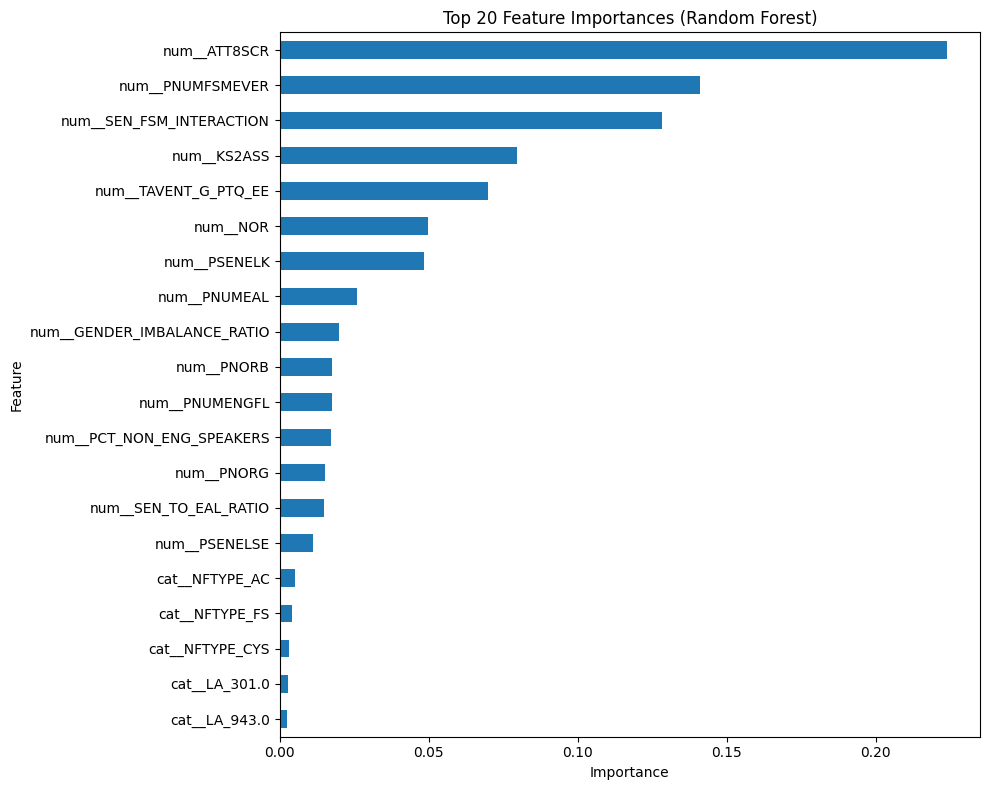

In [ ]:
# Get feature importances from best fitted model
importances = best_models['RandomForest'].named_steps['model'].feature_importances_

# Get feature names from the fitted preprocessor inside best_models
feature_names = best_models['RandomForest'].named_steps['preprocessor'].get_feature_names_out()

# Match names to importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Display
# Plot top 20 most important features
feature_importance_df.head(20).plot(
    kind='barh',
    x='feature',
    y='importance',
    figsize=(10, 8),
    legend=False
)

plt.gca().invert_yaxis()  # Most important at the top
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

- **`num__ATT8SCR` (Attainment 8 Score)**  
  This is by far the most influential predictor. It reinforces the idea that academic attainment is closely linked to sustained post-16 outcomes. Higher-performing schools academically tend to have more pupils moving into education, employment, or training.

- **`num__PNUMFSMEVER` (% Ever FSM Eligible)**  
  As highlighted throughout the data exploration, long-term deprivation (FSM eligibility) significantly influences sustained destination outcomes. Its high importance here quantifies that impact.

- **`num__SEN_FSM_INTERACTION` (SEN × FSM)**  
  This engineered feature captures compounding vulnerability — pupils who are both disadvantaged and have special needs. Its position in the top 3 underscores how layered disadvantage is a strong signal of risk.

- **`num__KS2ASS` (Key Stage 2 Prior Attainment)**  
  This confirms that starting points matter. Pupils with lower prior attainment tend to face more challenges at secondary school and beyond.

- **`num__TAVENT_G_PTQ_EE` (Post-16 Destinations)**  
  While part of the target structure, this outcome-related measure shows how closely aligned some post-16 metrics are, especially for feedback or policy reflection.

- **`num__NOR` (Cohort Size)**  
  Larger schools may offer more stability or support capacity, again tying into earlier visualisations showing better outcomes in bigger cohorts.

- **`num__PSENELK` & `num__PNUMEAL` (SEN EHCP and EAL)**  
  These further reinforce the role of pupil need and diversity in outcome variance. Higher SEN levels and language needs are correlated with lower sustained destinations, especially without adequate support structures.

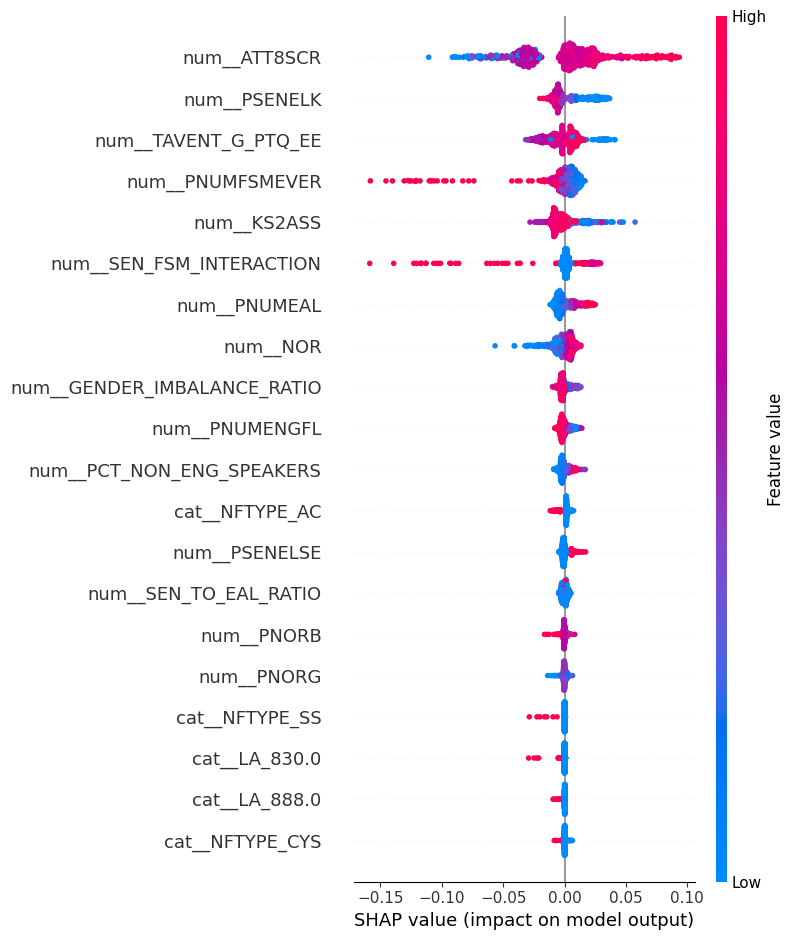

In [ ]:
# Select model and fitted preprocessor
model = best_models['RandomForest'].named_steps['model']
preprocessor = best_models['RandomForest'].named_steps['preprocessor']

# Transform X_test using the fitted preprocessor
X_test_transformed = preprocessor.transform(X_test)

# If output is sparse or object, convert to dense float32
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# If dtype is object, cast it to float
if X_test_transformed.dtype == 'O':
    X_test_transformed = X_test_transformed.astype(np.float32)

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

The SHAP summary plot offers deeper insight into not just **which features matter most**, but **how their values influence predictions**, and crucially, **how consistent or variable those effects are across schools**.

- **`num__ATT8SCR` (Attainment 8 Score)**  
  A tight, high-impact cluster is visible around positive SHAP values, confirming that higher Attainment 8 scores consistently raise the predicted sustained destination percentage. This reinforces a clear pattern observed earlier: academic strength is strongly associated with positive outcomes.

- **`num__PSENELK` (EHCP %)**  
  High values (in pink) tend to *reduce* model output, while low values (blue) push it up. This reinforces the disadvantage faced by schools with a high proportion of high-needs pupils — even more clearly than feature importance alone.

- **`num__TAVENT_G_PTQ_EE` (Destination Rate)**  
  A sharp linear relationship is observed: higher known destination rates strongly predict better outcomes, as expected. This may reflect feedback effects between short-term and long-term measures.

- **`num__PNUMFSMEVER` (% Ever FSM Eligible)**  
  The direction is again intuitive: schools with higher deprivation (pink) see lower predictions. The spread here is wider, suggesting its impact varies more depending on context — perhaps interacting with other factors like SEN or school type.

- **`num__SEN_FSM_INTERACTION`**  
  As in previous models, the SHAP spread confirms its nuanced role. Red dots dominate the left tail (negative impact), revealing that schools with pupils facing *both* disadvantage and SEN are systematically predicted to struggle more.

- **`num__KS2ASS` (Prior Attainment)**  
  A wide horizontal spread shows that the impact of prior attainment varies significantly across schools — likely reflecting differing trajectories for low-attaining vs. high-attaining pupils across contexts.

 
> This SHAP plot complements earlier data exploration by showing *not just what matters*, but how feature values themselves shape model outputs. The consistent down-pressure from high SEN or FSM values, and the lifting effect from attainment measures, mirror the themes developed across scatterplots and risk matrices. 